# Speech-based Emotion Recognition for Voice Comms.
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D
*   See AugmentData.ipynb for augmentation scripts  

Models:
* Pytorch MLP
* Example sklearn RandomForest, MLP

In [413]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from torch import nn
import torch.optim as optim

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.utils import shuffle

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Data handling, feature extract

In [414]:
#device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # should always be 16kHz
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [6]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    "calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    "surprised" # in TESS specifies pleasant surprise
}

# map emotion to 2D space
circumplex_model = {
    "neutral":[(0.0, 0.0), "grey"],
    "calm":[(0.5,-0.7),"cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"purple"],
    "sad":[(-0.8, -0.3),"blue"],
    "angry":[(-0.2,0.7),"red"],
    "fearful":[(-0.4,0.7),"magenta"], #circumplex afraid
    "disgust":[(-0.41,0.6),"green"], #circumplex annoyed
    "surprised":[(0.3,0.7),"orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

# map emotion to 3d space
pad_model = {
    
}

In [631]:
# load data and extract features
X, y = [], []
Xa, ya = [], []

## RAVDESS clean
for file in glob.glob("data/RAVDESS-nosil/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only circumplex model emotions
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    X.append(features)
    y.append(circumplex_coord)

## RAVDESS augmented
# white noise
for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xa.append(features)
    ya.append(circumplex_coord)
    
# background noise
for file in glob.glob("data/augment-bg/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xa.append(features)
    ya.append(circumplex_coord)
    
# reverb
for file in glob.glob("data/augment-reverb/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xa.append(features)
    ya.append(circumplex_coord)

# overdrive
for file in glob.glob("data/augment-overdrive/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file, mfcc=True)
    # add to data
    Xa.append(features)
    ya.append(circumplex_coord)
    
# # CREMA-D clean
# for file in glob.glob("data/CREMA-D/*.wav"):
#     # get the base name of the audio file
#     basename = os.path.basename(file)
#     # get the emotion label
#     emotion = cemotion[basename.split("_")[2]]
#     # we allow only AVAILABLE_EMOTIONS we set
#     if emotion not in AVAILABLE_EMOTIONS:
#         continue
#     # map coords
#     circumplex_coord = circumplex_model[emotion][0]
#     # extract features
#     features = extract_feature(file, mfcc=True)
#     # add to data
#     X.append(features)
#     y.append(circumplex_coord)

# scale features [1, -1]
X /= np.max(np.abs(X),axis=0)

# collect clean data
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=420, stratify=y)

# scale features [1, -1]
Xa /= np.max(np.abs(Xa),axis=0)

# collect augmented data
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(np.array(Xa),np.array(ya), test_size=0.1, random_state=420, stratify=ya)



# # label encoding for y
# label_encoder = preprocessing.LabelEncoder()
# label_encoder.fit(y)
# print("Class mapping: ")
# for i, item in enumerate(label_encoder.classes_):
#     print(item, "-->", i)

# encoded_labels = label_encoder.transform(y)
# print("Labels =", labels)
# print("Encoded labels =", list(encoded_labels))

# # split the data to training and testing and return it
# return train_test_split(np.array(X), np.array(y), test_size=test_size, random_state=420, stratify=y)

In [531]:
# # load dataset(s), 80% training 20% testing
# X_train, X_test, y_train, y_test = load_data(test_size=0.2)

In [632]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train_a.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# vector of features extracted 
# using extract_features() function
print("[+] Number of features:", X_train_a.shape[1])

[+] Number of training samples: 5184
[+] Number of testing samples: 288
[+] Number of features: 40


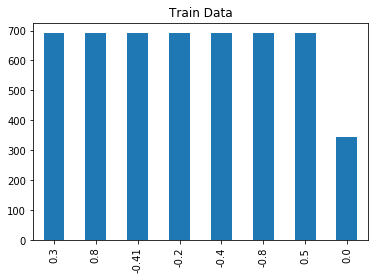

In [633]:
y_test_df = pd.DataFrame(data=y_train_a, columns=['X','Y',])
y_test_df['X'].value_counts().plot.bar(title='Train Data')

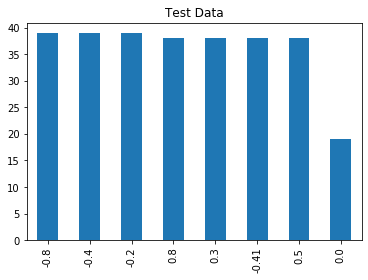

In [634]:
y_test_df = pd.DataFrame(data=y_test, columns=['X','Y',])
y_test_df['X'].value_counts().plot.bar(title='Test Data')

# MLP PyTorch

In [635]:
#defining utility class
#by defining this, you only have to write "for loop" to load minibatch data
class DataLoader(object):
    def __init__(self, x, y, batch_size, shuffle):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x,batch_y)

In [643]:
train_loader = DataLoader(X_train_a, y_train_a,
                         batch_size=X_train_a.shape[0],
                          shuffle=True)# create your dataloader

test_loader = DataLoader(X_test, y_test,
                        batch_size=X_train_a.shape[0],
                          shuffle=True)# create your dataloader

# Checking the dataset
for features, labels in train_loader:  
    print('features dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break

# Checking the dataset
for features, labels in test_loader:  
    print('features dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break

features dimensions: torch.Size([5184, 40])
label dimensions: torch.Size([5184, 2])
features dimensions: torch.Size([288, 40])
label dimensions: torch.Size([288, 2])


In [644]:
#defining MLP model
#generally out_dim is more than 1, but this model only allows 1.
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim=2):
        super(MLP, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.out_dim = out_dim
        
        ### 1st hidden layer
        self.linear_1 = nn.Linear(self.in_dim, self.hidden_dim_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        
        ## Out layer
        self.linear_out = nn.Linear(self.hidden_dim_2, self.out_dim)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    
    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_out(out)
        #x = x.squeeze(1)
        return out

In [645]:
#instantiate model
mlp = MLP(X_train_a.shape[1], 28, 20, y_train_a.shape[1]).to(device)
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)

In [646]:
# MAE loss
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [647]:
# MSE loss
def mse_loss(y_pred, y_true):
    mse = torch.square(y_true - y_pred).mean() 
    return mse

In [648]:
# training phase
epochs = 20000
# to plot loss curve after training
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_loader.data_size // train_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        
        y_pred = mlp(batch_x)

        loss = mse_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = test_loader.data_size // test_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(test_loader):
    
        y_pred = mlp(batch_x)
        loss = mse_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.model')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))


Valid Loss:0.0000
Epoch:2 Batch:0/2 Loss:0.2933 Time:0m0.01s
Valid Loss:0.2875
Epoch:3 Batch:0/2 Loss:0.2879 Time:0m0.01s
Valid Loss:0.2831
Epoch:4 Batch:0/2 Loss:0.2835 Time:0m0.01s
Valid Loss:0.2796
Epoch:5 Batch:0/2 Loss:0.2800 Time:0m0.01s
Valid Loss:0.2768
Epoch:6 Batch:0/2 Loss:0.2771 Time:0m0.01s
Valid Loss:0.2745
Epoch:7 Batch:0/2 Loss:0.2749 Time:0m0.01s
Valid Loss:0.2726
Epoch:8 Batch:0/2 Loss:0.2730 Time:0m0.01s
Valid Loss:0.2711
Epoch:9 Batch:0/2 Loss:0.2715 Time:0m0.01s
Valid Loss:0.2700
Epoch:10 Batch:0/2 Loss:0.2704 Time:0m0.01s
Valid Loss:0.2690
Epoch:11 Batch:0/2 Loss:0.2694 Time:0m0.04s
Valid Loss:0.2682
Epoch:12 Batch:0/2 Loss:0.2686 Time:0m0.01s
Valid Loss:0.2676
Epoch:13 Batch:0/2 Loss:0.2680 Time:0m0.00s
Valid Loss:0.2671
Epoch:14 Batch:0/2 Loss:0.2675 Time:0m0.00s
Valid Loss:0.2667
Epoch:15 Batch:0/2 Loss:0.2671 Time:0m0.00s
Valid Loss:0.2663
Epoch:16 Batch:0/2 Loss:0.2667 Time:0m0.00s
Valid Loss:0.2661
Epoch:17 Batch:0/2 Loss:0.2665 Time:0m0.01s
Valid Loss:0.26

Epoch:152 Batch:0/2 Loss:0.2627 Time:0m0.01s
Valid Loss:0.2617
Epoch:153 Batch:0/2 Loss:0.2627 Time:0m0.01s
Valid Loss:0.2617
Epoch:154 Batch:0/2 Loss:0.2627 Time:0m0.01s
Valid Loss:0.2616
Epoch:155 Batch:0/2 Loss:0.2626 Time:0m0.00s
Valid Loss:0.2616
Epoch:156 Batch:0/2 Loss:0.2626 Time:0m0.00s
Valid Loss:0.2616
Epoch:157 Batch:0/2 Loss:0.2626 Time:0m0.00s
Valid Loss:0.2615
Epoch:158 Batch:0/2 Loss:0.2626 Time:0m0.00s
Valid Loss:0.2615
Epoch:159 Batch:0/2 Loss:0.2625 Time:0m0.00s
Valid Loss:0.2615
Epoch:160 Batch:0/2 Loss:0.2625 Time:0m0.00s
Valid Loss:0.2614
Epoch:161 Batch:0/2 Loss:0.2625 Time:0m0.00s
Valid Loss:0.2614
Epoch:162 Batch:0/2 Loss:0.2625 Time:0m0.00s
Valid Loss:0.2614
Epoch:163 Batch:0/2 Loss:0.2624 Time:0m0.00s
Valid Loss:0.2613
Epoch:164 Batch:0/2 Loss:0.2624 Time:0m0.00s
Valid Loss:0.2613
Epoch:165 Batch:0/2 Loss:0.2624 Time:0m0.00s
Valid Loss:0.2613
Epoch:166 Batch:0/2 Loss:0.2623 Time:0m0.00s
Valid Loss:0.2612
Epoch:167 Batch:0/2 Loss:0.2623 Time:0m0.00s
Valid Loss

Epoch:297 Batch:0/2 Loss:0.2563 Time:0m0.00s
Valid Loss:0.2534
Epoch:298 Batch:0/2 Loss:0.2562 Time:0m0.01s
Valid Loss:0.2533
Epoch:299 Batch:0/2 Loss:0.2561 Time:0m0.01s
Valid Loss:0.2532
Epoch:300 Batch:0/2 Loss:0.2561 Time:0m0.00s
Valid Loss:0.2531
Epoch:301 Batch:0/2 Loss:0.2560 Time:0m0.01s
Valid Loss:0.2530
Epoch:302 Batch:0/2 Loss:0.2559 Time:0m0.00s
Valid Loss:0.2529
Epoch:303 Batch:0/2 Loss:0.2558 Time:0m0.00s
Valid Loss:0.2528
Epoch:304 Batch:0/2 Loss:0.2557 Time:0m0.00s
Valid Loss:0.2527
Epoch:305 Batch:0/2 Loss:0.2557 Time:0m0.00s
Valid Loss:0.2526
Epoch:306 Batch:0/2 Loss:0.2556 Time:0m0.00s
Valid Loss:0.2525
Epoch:307 Batch:0/2 Loss:0.2555 Time:0m0.00s
Valid Loss:0.2524
Epoch:308 Batch:0/2 Loss:0.2554 Time:0m0.00s
Valid Loss:0.2523
Epoch:309 Batch:0/2 Loss:0.2554 Time:0m0.01s
Valid Loss:0.2522
Epoch:310 Batch:0/2 Loss:0.2553 Time:0m0.00s
Valid Loss:0.2521
Epoch:311 Batch:0/2 Loss:0.2552 Time:0m0.00s
Valid Loss:0.2520
Epoch:312 Batch:0/2 Loss:0.2551 Time:0m0.00s
Valid Loss

Epoch:429 Batch:0/2 Loss:0.2435 Time:0m0.01s
Valid Loss:0.2381
Epoch:430 Batch:0/2 Loss:0.2434 Time:0m0.01s
Valid Loss:0.2380
Epoch:431 Batch:0/2 Loss:0.2433 Time:0m0.01s
Valid Loss:0.2379
Epoch:432 Batch:0/2 Loss:0.2432 Time:0m0.01s
Valid Loss:0.2378
Epoch:433 Batch:0/2 Loss:0.2431 Time:0m0.01s
Valid Loss:0.2377
Epoch:434 Batch:0/2 Loss:0.2430 Time:0m0.02s
Valid Loss:0.2376
Epoch:435 Batch:0/2 Loss:0.2429 Time:0m0.00s
Valid Loss:0.2375
Epoch:436 Batch:0/2 Loss:0.2428 Time:0m0.00s
Valid Loss:0.2374
Epoch:437 Batch:0/2 Loss:0.2427 Time:0m0.01s
Valid Loss:0.2373
Epoch:438 Batch:0/2 Loss:0.2426 Time:0m0.00s
Valid Loss:0.2372
Epoch:439 Batch:0/2 Loss:0.2425 Time:0m0.00s
Valid Loss:0.2371
Epoch:440 Batch:0/2 Loss:0.2424 Time:0m0.00s
Valid Loss:0.2370
Epoch:441 Batch:0/2 Loss:0.2423 Time:0m0.00s
Valid Loss:0.2369
Epoch:442 Batch:0/2 Loss:0.2422 Time:0m0.00s
Valid Loss:0.2368
Epoch:443 Batch:0/2 Loss:0.2421 Time:0m0.00s
Valid Loss:0.2367
Epoch:444 Batch:0/2 Loss:0.2420 Time:0m0.00s
Valid Loss

Epoch:567 Batch:0/2 Loss:0.2337 Time:0m0.00s
Valid Loss:0.2295
Epoch:568 Batch:0/2 Loss:0.2336 Time:0m0.01s
Valid Loss:0.2295
Epoch:569 Batch:0/2 Loss:0.2336 Time:0m0.01s
Valid Loss:0.2295
Epoch:570 Batch:0/2 Loss:0.2335 Time:0m0.01s
Valid Loss:0.2294
Epoch:571 Batch:0/2 Loss:0.2335 Time:0m0.01s
Valid Loss:0.2294
Epoch:572 Batch:0/2 Loss:0.2335 Time:0m0.00s
Valid Loss:0.2294
Epoch:573 Batch:0/2 Loss:0.2334 Time:0m0.00s
Valid Loss:0.2293
Epoch:574 Batch:0/2 Loss:0.2334 Time:0m0.00s
Valid Loss:0.2293
Epoch:575 Batch:0/2 Loss:0.2333 Time:0m0.01s
Valid Loss:0.2293
Epoch:576 Batch:0/2 Loss:0.2333 Time:0m0.01s
Valid Loss:0.2292
Epoch:577 Batch:0/2 Loss:0.2332 Time:0m0.01s
Valid Loss:0.2292
Epoch:578 Batch:0/2 Loss:0.2332 Time:0m0.01s
Valid Loss:0.2292
Epoch:579 Batch:0/2 Loss:0.2332 Time:0m0.01s
Valid Loss:0.2291
Epoch:580 Batch:0/2 Loss:0.2331 Time:0m0.01s
Valid Loss:0.2291
Epoch:581 Batch:0/2 Loss:0.2331 Time:0m0.01s
Valid Loss:0.2291
Epoch:582 Batch:0/2 Loss:0.2330 Time:0m0.01s
Valid Loss

Epoch:706 Batch:0/2 Loss:0.2291 Time:0m0.01s
Valid Loss:0.2253
Epoch:707 Batch:0/2 Loss:0.2291 Time:0m0.01s
Valid Loss:0.2253
Epoch:708 Batch:0/2 Loss:0.2290 Time:0m0.01s
Valid Loss:0.2253
Epoch:709 Batch:0/2 Loss:0.2290 Time:0m0.01s
Valid Loss:0.2252
Epoch:710 Batch:0/2 Loss:0.2290 Time:0m0.01s
Valid Loss:0.2252
Epoch:711 Batch:0/2 Loss:0.2290 Time:0m0.01s
Valid Loss:0.2252
Epoch:712 Batch:0/2 Loss:0.2289 Time:0m0.01s
Valid Loss:0.2252
Epoch:713 Batch:0/2 Loss:0.2289 Time:0m0.01s
Valid Loss:0.2251
Epoch:714 Batch:0/2 Loss:0.2289 Time:0m0.01s
Valid Loss:0.2251
Epoch:715 Batch:0/2 Loss:0.2289 Time:0m0.01s
Valid Loss:0.2251
Epoch:716 Batch:0/2 Loss:0.2288 Time:0m0.01s
Valid Loss:0.2250
Epoch:717 Batch:0/2 Loss:0.2288 Time:0m0.01s
Valid Loss:0.2250
Epoch:718 Batch:0/2 Loss:0.2288 Time:0m0.01s
Valid Loss:0.2250
Epoch:719 Batch:0/2 Loss:0.2288 Time:0m0.01s
Valid Loss:0.2250
Epoch:720 Batch:0/2 Loss:0.2287 Time:0m0.01s
Valid Loss:0.2249
Epoch:721 Batch:0/2 Loss:0.2287 Time:0m0.01s
Valid Loss

Valid Loss:0.2214
Epoch:848 Batch:0/2 Loss:0.2261 Time:0m0.01s
Valid Loss:0.2213
Epoch:849 Batch:0/2 Loss:0.2261 Time:0m0.02s
Valid Loss:0.2213
Epoch:850 Batch:0/2 Loss:0.2260 Time:0m0.01s
Valid Loss:0.2213
Epoch:851 Batch:0/2 Loss:0.2260 Time:0m0.01s
Valid Loss:0.2213
Epoch:852 Batch:0/2 Loss:0.2260 Time:0m0.01s
Valid Loss:0.2212
Epoch:853 Batch:0/2 Loss:0.2260 Time:0m0.01s
Valid Loss:0.2212
Epoch:854 Batch:0/2 Loss:0.2260 Time:0m0.02s
Valid Loss:0.2212
Epoch:855 Batch:0/2 Loss:0.2260 Time:0m0.01s
Valid Loss:0.2212
Epoch:856 Batch:0/2 Loss:0.2259 Time:0m0.01s
Valid Loss:0.2211
Epoch:857 Batch:0/2 Loss:0.2259 Time:0m0.01s
Valid Loss:0.2211
Epoch:858 Batch:0/2 Loss:0.2259 Time:0m0.01s
Valid Loss:0.2211
Epoch:859 Batch:0/2 Loss:0.2259 Time:0m0.01s
Valid Loss:0.2211
Epoch:860 Batch:0/2 Loss:0.2259 Time:0m0.01s
Valid Loss:0.2210
Epoch:861 Batch:0/2 Loss:0.2259 Time:0m0.02s
Valid Loss:0.2210
Epoch:862 Batch:0/2 Loss:0.2258 Time:0m0.03s
Valid Loss:0.2210
Epoch:863 Batch:0/2 Loss:0.2258 Time:

Epoch:980 Batch:0/2 Loss:0.2240 Time:0m0.01s
Valid Loss:0.2184
Epoch:981 Batch:0/2 Loss:0.2240 Time:0m0.01s
Valid Loss:0.2184
Epoch:982 Batch:0/2 Loss:0.2240 Time:0m0.01s
Valid Loss:0.2184
Epoch:983 Batch:0/2 Loss:0.2240 Time:0m0.01s
Valid Loss:0.2183
Epoch:984 Batch:0/2 Loss:0.2240 Time:0m0.01s
Valid Loss:0.2183
Epoch:985 Batch:0/2 Loss:0.2240 Time:0m0.02s
Valid Loss:0.2183
Epoch:986 Batch:0/2 Loss:0.2239 Time:0m0.01s
Valid Loss:0.2183
Epoch:987 Batch:0/2 Loss:0.2239 Time:0m0.01s
Valid Loss:0.2183
Epoch:988 Batch:0/2 Loss:0.2239 Time:0m0.00s
Valid Loss:0.2182
Epoch:989 Batch:0/2 Loss:0.2239 Time:0m0.01s
Valid Loss:0.2182
Epoch:990 Batch:0/2 Loss:0.2239 Time:0m0.00s
Valid Loss:0.2182
Epoch:991 Batch:0/2 Loss:0.2239 Time:0m0.01s
Valid Loss:0.2182
Epoch:992 Batch:0/2 Loss:0.2239 Time:0m0.01s
Valid Loss:0.2182
Epoch:993 Batch:0/2 Loss:0.2239 Time:0m0.01s
Valid Loss:0.2182
Epoch:994 Batch:0/2 Loss:0.2238 Time:0m0.01s
Valid Loss:0.2181
Epoch:995 Batch:0/2 Loss:0.2238 Time:0m0.01s
Valid Loss

Epoch:1113 Batch:0/2 Loss:0.2223 Time:0m0.01s
Valid Loss:0.2162
Epoch:1114 Batch:0/2 Loss:0.2223 Time:0m0.01s
Valid Loss:0.2162
Epoch:1115 Batch:0/2 Loss:0.2223 Time:0m0.01s
Valid Loss:0.2162
Epoch:1116 Batch:0/2 Loss:0.2223 Time:0m0.01s
Valid Loss:0.2162
Epoch:1117 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2162
Epoch:1118 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2162
Epoch:1119 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2161
Epoch:1120 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2161
Epoch:1121 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2161
Epoch:1122 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2161
Epoch:1123 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2161
Epoch:1124 Batch:0/2 Loss:0.2222 Time:0m0.01s
Valid Loss:0.2161
Epoch:1125 Batch:0/2 Loss:0.2221 Time:0m0.01s
Valid Loss:0.2161
Epoch:1126 Batch:0/2 Loss:0.2221 Time:0m0.01s
Valid Loss:0.2160
Epoch:1127 Batch:0/2 Loss:0.2221 Time:0m0.00s
Valid Loss:0.2160
Epoch:1128 Batch:0/2 Loss:0.2221 Time:0m

Epoch:1251 Batch:0/2 Loss:0.2205 Time:0m0.01s
Valid Loss:0.2144
Epoch:1252 Batch:0/2 Loss:0.2205 Time:0m0.01s
Valid Loss:0.2144
Epoch:1253 Batch:0/2 Loss:0.2205 Time:0m0.01s
Valid Loss:0.2144
Epoch:1254 Batch:0/2 Loss:0.2205 Time:0m0.01s
Valid Loss:0.2144
Epoch:1255 Batch:0/2 Loss:0.2205 Time:0m0.01s
Valid Loss:0.2144
Epoch:1256 Batch:0/2 Loss:0.2205 Time:0m0.01s
Valid Loss:0.2143
Epoch:1257 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1258 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1259 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1260 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1261 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1262 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1263 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1264 Batch:0/2 Loss:0.2204 Time:0m0.01s
Valid Loss:0.2143
Epoch:1265 Batch:0/2 Loss:0.2203 Time:0m0.01s
Valid Loss:0.2142
Epoch:1266 Batch:0/2 Loss:0.2203 Time:0m

Epoch:1384 Batch:0/2 Loss:0.2189 Time:0m0.00s
Valid Loss:0.2130
Epoch:1385 Batch:0/2 Loss:0.2188 Time:0m0.01s
Valid Loss:0.2130
Epoch:1386 Batch:0/2 Loss:0.2188 Time:0m0.01s
Valid Loss:0.2129
Epoch:1387 Batch:0/2 Loss:0.2188 Time:0m0.00s
Valid Loss:0.2129
Epoch:1388 Batch:0/2 Loss:0.2188 Time:0m0.01s
Valid Loss:0.2129
Epoch:1389 Batch:0/2 Loss:0.2188 Time:0m0.00s
Valid Loss:0.2129
Epoch:1390 Batch:0/2 Loss:0.2188 Time:0m0.00s
Valid Loss:0.2129
Epoch:1391 Batch:0/2 Loss:0.2188 Time:0m0.00s
Valid Loss:0.2129
Epoch:1392 Batch:0/2 Loss:0.2188 Time:0m0.00s
Valid Loss:0.2129
Epoch:1393 Batch:0/2 Loss:0.2187 Time:0m0.00s
Valid Loss:0.2129
Epoch:1394 Batch:0/2 Loss:0.2187 Time:0m0.00s
Valid Loss:0.2128
Epoch:1395 Batch:0/2 Loss:0.2187 Time:0m0.00s
Valid Loss:0.2128
Epoch:1396 Batch:0/2 Loss:0.2187 Time:0m0.00s
Valid Loss:0.2128
Epoch:1397 Batch:0/2 Loss:0.2187 Time:0m0.01s
Valid Loss:0.2128
Epoch:1398 Batch:0/2 Loss:0.2187 Time:0m0.00s
Valid Loss:0.2128
Epoch:1399 Batch:0/2 Loss:0.2187 Time:0m

Epoch:1531 Batch:0/2 Loss:0.2170 Time:0m0.00s
Valid Loss:0.2112
Epoch:1532 Batch:0/2 Loss:0.2170 Time:0m0.01s
Valid Loss:0.2112
Epoch:1533 Batch:0/2 Loss:0.2170 Time:0m0.01s
Valid Loss:0.2112
Epoch:1534 Batch:0/2 Loss:0.2169 Time:0m0.01s
Valid Loss:0.2111
Epoch:1535 Batch:0/2 Loss:0.2169 Time:0m0.02s
Valid Loss:0.2111
Epoch:1536 Batch:0/2 Loss:0.2169 Time:0m0.00s
Valid Loss:0.2111
Epoch:1537 Batch:0/2 Loss:0.2169 Time:0m0.00s
Valid Loss:0.2111
Epoch:1538 Batch:0/2 Loss:0.2169 Time:0m0.00s
Valid Loss:0.2111
Epoch:1539 Batch:0/2 Loss:0.2169 Time:0m0.00s
Valid Loss:0.2111
Epoch:1540 Batch:0/2 Loss:0.2169 Time:0m0.00s
Valid Loss:0.2111
Epoch:1541 Batch:0/2 Loss:0.2169 Time:0m0.01s
Valid Loss:0.2111
Epoch:1542 Batch:0/2 Loss:0.2168 Time:0m0.00s
Valid Loss:0.2111
Epoch:1543 Batch:0/2 Loss:0.2168 Time:0m0.01s
Valid Loss:0.2111
Epoch:1544 Batch:0/2 Loss:0.2168 Time:0m0.01s
Valid Loss:0.2110
Epoch:1545 Batch:0/2 Loss:0.2168 Time:0m0.01s
Valid Loss:0.2110
Epoch:1546 Batch:0/2 Loss:0.2168 Time:0m

Epoch:1674 Batch:0/2 Loss:0.2152 Time:0m0.01s
Valid Loss:0.2096
Epoch:1675 Batch:0/2 Loss:0.2152 Time:0m0.01s
Valid Loss:0.2096
Epoch:1676 Batch:0/2 Loss:0.2152 Time:0m0.01s
Valid Loss:0.2096
Epoch:1677 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2096
Epoch:1678 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2096
Epoch:1679 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2096
Epoch:1680 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2095
Epoch:1681 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2095
Epoch:1682 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2095
Epoch:1683 Batch:0/2 Loss:0.2151 Time:0m0.01s
Valid Loss:0.2095
Epoch:1684 Batch:0/2 Loss:0.2151 Time:0m0.00s
Valid Loss:0.2095
Epoch:1685 Batch:0/2 Loss:0.2150 Time:0m0.01s
Valid Loss:0.2095
Epoch:1686 Batch:0/2 Loss:0.2150 Time:0m0.00s
Valid Loss:0.2095
Epoch:1687 Batch:0/2 Loss:0.2150 Time:0m0.00s
Valid Loss:0.2095
Epoch:1688 Batch:0/2 Loss:0.2150 Time:0m0.01s
Valid Loss:0.2094
Epoch:1689 Batch:0/2 Loss:0.2150 Time:0m

Valid Loss:0.2081
Epoch:1806 Batch:0/2 Loss:0.2135 Time:0m0.02s
Valid Loss:0.2081
Epoch:1807 Batch:0/2 Loss:0.2135 Time:0m0.06s
Valid Loss:0.2081
Epoch:1808 Batch:0/2 Loss:0.2135 Time:0m0.04s
Valid Loss:0.2080
Epoch:1809 Batch:0/2 Loss:0.2135 Time:0m0.02s
Valid Loss:0.2080
Epoch:1810 Batch:0/2 Loss:0.2134 Time:0m0.01s
Valid Loss:0.2080
Epoch:1811 Batch:0/2 Loss:0.2134 Time:0m0.01s
Valid Loss:0.2080
Epoch:1812 Batch:0/2 Loss:0.2134 Time:0m0.01s
Valid Loss:0.2080
Epoch:1813 Batch:0/2 Loss:0.2134 Time:0m0.02s
Valid Loss:0.2080
Epoch:1814 Batch:0/2 Loss:0.2134 Time:0m0.01s
Valid Loss:0.2080
Epoch:1815 Batch:0/2 Loss:0.2134 Time:0m0.01s
Valid Loss:0.2080
Epoch:1816 Batch:0/2 Loss:0.2134 Time:0m0.01s
Valid Loss:0.2079
Epoch:1817 Batch:0/2 Loss:0.2134 Time:0m0.02s
Valid Loss:0.2079
Epoch:1818 Batch:0/2 Loss:0.2133 Time:0m0.01s
Valid Loss:0.2079
Epoch:1819 Batch:0/2 Loss:0.2133 Time:0m0.02s
Valid Loss:0.2079
Epoch:1820 Batch:0/2 Loss:0.2133 Time:0m0.01s
Valid Loss:0.2079
Epoch:1821 Batch:0/2 L

Epoch:1947 Batch:0/2 Loss:0.2117 Time:0m0.00s
Valid Loss:0.2064
Epoch:1948 Batch:0/2 Loss:0.2117 Time:0m0.01s
Valid Loss:0.2064
Epoch:1949 Batch:0/2 Loss:0.2117 Time:0m0.01s
Valid Loss:0.2064
Epoch:1950 Batch:0/2 Loss:0.2116 Time:0m0.01s
Valid Loss:0.2063
Epoch:1951 Batch:0/2 Loss:0.2116 Time:0m0.01s
Valid Loss:0.2063
Epoch:1952 Batch:0/2 Loss:0.2116 Time:0m0.00s
Valid Loss:0.2063
Epoch:1953 Batch:0/2 Loss:0.2116 Time:0m0.01s
Valid Loss:0.2063
Epoch:1954 Batch:0/2 Loss:0.2116 Time:0m0.01s
Valid Loss:0.2063
Epoch:1955 Batch:0/2 Loss:0.2116 Time:0m0.00s
Valid Loss:0.2063
Epoch:1956 Batch:0/2 Loss:0.2116 Time:0m0.00s
Valid Loss:0.2063
Epoch:1957 Batch:0/2 Loss:0.2115 Time:0m0.00s
Valid Loss:0.2063
Epoch:1958 Batch:0/2 Loss:0.2115 Time:0m0.00s
Valid Loss:0.2062
Epoch:1959 Batch:0/2 Loss:0.2115 Time:0m0.00s
Valid Loss:0.2062
Epoch:1960 Batch:0/2 Loss:0.2115 Time:0m0.00s
Valid Loss:0.2062
Epoch:1961 Batch:0/2 Loss:0.2115 Time:0m0.00s
Valid Loss:0.2062
Epoch:1962 Batch:0/2 Loss:0.2115 Time:0m

Epoch:2081 Batch:0/2 Loss:0.2099 Time:0m0.01s
Valid Loss:0.2046
Epoch:2082 Batch:0/2 Loss:0.2099 Time:0m0.01s
Valid Loss:0.2046
Epoch:2083 Batch:0/2 Loss:0.2099 Time:0m0.01s
Valid Loss:0.2046
Epoch:2084 Batch:0/2 Loss:0.2099 Time:0m0.01s
Valid Loss:0.2045
Epoch:2085 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2045
Epoch:2086 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2045
Epoch:2087 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2045
Epoch:2088 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2045
Epoch:2089 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2045
Epoch:2090 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2045
Epoch:2091 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2044
Epoch:2092 Batch:0/2 Loss:0.2098 Time:0m0.01s
Valid Loss:0.2044
Epoch:2093 Batch:0/2 Loss:0.2097 Time:0m0.01s
Valid Loss:0.2044
Epoch:2094 Batch:0/2 Loss:0.2097 Time:0m0.01s
Valid Loss:0.2044
Epoch:2095 Batch:0/2 Loss:0.2097 Time:0m0.01s
Valid Loss:0.2044
Epoch:2096 Batch:0/2 Loss:0.2097 Time:0m

Epoch:2217 Batch:0/2 Loss:0.2080 Time:0m0.01s
Valid Loss:0.2026
Epoch:2218 Batch:0/2 Loss:0.2080 Time:0m0.01s
Valid Loss:0.2025
Epoch:2219 Batch:0/2 Loss:0.2080 Time:0m0.01s
Valid Loss:0.2025
Epoch:2220 Batch:0/2 Loss:0.2080 Time:0m0.01s
Valid Loss:0.2025
Epoch:2221 Batch:0/2 Loss:0.2080 Time:0m0.01s
Valid Loss:0.2025
Epoch:2222 Batch:0/2 Loss:0.2080 Time:0m0.01s
Valid Loss:0.2024
Epoch:2223 Batch:0/2 Loss:0.2079 Time:0m0.00s
Valid Loss:0.2024
Epoch:2224 Batch:0/2 Loss:0.2079 Time:0m0.00s
Valid Loss:0.2024
Epoch:2225 Batch:0/2 Loss:0.2079 Time:0m0.00s
Valid Loss:0.2024
Epoch:2226 Batch:0/2 Loss:0.2079 Time:0m0.00s
Valid Loss:0.2024
Epoch:2227 Batch:0/2 Loss:0.2079 Time:0m0.00s
Valid Loss:0.2024
Epoch:2228 Batch:0/2 Loss:0.2079 Time:0m0.01s
Valid Loss:0.2024
Epoch:2229 Batch:0/2 Loss:0.2079 Time:0m0.00s
Valid Loss:0.2023
Epoch:2230 Batch:0/2 Loss:0.2078 Time:0m0.01s
Valid Loss:0.2023
Epoch:2231 Batch:0/2 Loss:0.2078 Time:0m0.01s
Valid Loss:0.2023
Epoch:2232 Batch:0/2 Loss:0.2078 Time:0m

Valid Loss:0.2006
Epoch:2352 Batch:0/2 Loss:0.2061 Time:0m0.02s
Valid Loss:0.2006
Epoch:2353 Batch:0/2 Loss:0.2061 Time:0m0.01s
Valid Loss:0.2006
Epoch:2354 Batch:0/2 Loss:0.2061 Time:0m0.01s
Valid Loss:0.2005
Epoch:2355 Batch:0/2 Loss:0.2061 Time:0m0.00s
Valid Loss:0.2005
Epoch:2356 Batch:0/2 Loss:0.2060 Time:0m0.00s
Valid Loss:0.2005
Epoch:2357 Batch:0/2 Loss:0.2060 Time:0m0.01s
Valid Loss:0.2005
Epoch:2358 Batch:0/2 Loss:0.2060 Time:0m0.00s
Valid Loss:0.2005
Epoch:2359 Batch:0/2 Loss:0.2060 Time:0m0.00s
Valid Loss:0.2005
Epoch:2360 Batch:0/2 Loss:0.2060 Time:0m0.00s
Valid Loss:0.2004
Epoch:2361 Batch:0/2 Loss:0.2060 Time:0m0.00s
Valid Loss:0.2004
Epoch:2362 Batch:0/2 Loss:0.2060 Time:0m0.00s
Valid Loss:0.2004
Epoch:2363 Batch:0/2 Loss:0.2059 Time:0m0.01s
Valid Loss:0.2004
Epoch:2364 Batch:0/2 Loss:0.2059 Time:0m0.01s
Valid Loss:0.2004
Epoch:2365 Batch:0/2 Loss:0.2059 Time:0m0.01s
Valid Loss:0.2004
Epoch:2366 Batch:0/2 Loss:0.2059 Time:0m0.01s
Valid Loss:0.2004
Epoch:2367 Batch:0/2 L

Epoch:2487 Batch:0/2 Loss:0.2041 Time:0m0.01s
Valid Loss:0.1984
Epoch:2488 Batch:0/2 Loss:0.2041 Time:0m0.01s
Valid Loss:0.1984
Epoch:2489 Batch:0/2 Loss:0.2041 Time:0m0.02s
Valid Loss:0.1984
Epoch:2490 Batch:0/2 Loss:0.2041 Time:0m0.00s
Valid Loss:0.1984
Epoch:2491 Batch:0/2 Loss:0.2041 Time:0m0.01s
Valid Loss:0.1984
Epoch:2492 Batch:0/2 Loss:0.2041 Time:0m0.01s
Valid Loss:0.1984
Epoch:2493 Batch:0/2 Loss:0.2040 Time:0m0.00s
Valid Loss:0.1984
Epoch:2494 Batch:0/2 Loss:0.2040 Time:0m0.00s
Valid Loss:0.1983
Epoch:2495 Batch:0/2 Loss:0.2040 Time:0m0.00s
Valid Loss:0.1983
Epoch:2496 Batch:0/2 Loss:0.2040 Time:0m0.00s
Valid Loss:0.1983
Epoch:2497 Batch:0/2 Loss:0.2040 Time:0m0.00s
Valid Loss:0.1983
Epoch:2498 Batch:0/2 Loss:0.2040 Time:0m0.01s
Valid Loss:0.1983
Epoch:2499 Batch:0/2 Loss:0.2040 Time:0m0.00s
Valid Loss:0.1983
Epoch:2500 Batch:0/2 Loss:0.2039 Time:0m0.00s
Valid Loss:0.1982
Epoch:2501 Batch:0/2 Loss:0.2039 Time:0m0.01s
Valid Loss:0.1982
Epoch:2502 Batch:0/2 Loss:0.2039 Time:0m

Epoch:2616 Batch:0/2 Loss:0.2022 Time:0m0.01s
Valid Loss:0.1962
Epoch:2617 Batch:0/2 Loss:0.2022 Time:0m0.01s
Valid Loss:0.1962
Epoch:2618 Batch:0/2 Loss:0.2022 Time:0m0.01s
Valid Loss:0.1962
Epoch:2619 Batch:0/2 Loss:0.2022 Time:0m0.01s
Valid Loss:0.1962
Epoch:2620 Batch:0/2 Loss:0.2022 Time:0m0.01s
Valid Loss:0.1961
Epoch:2621 Batch:0/2 Loss:0.2021 Time:0m0.01s
Valid Loss:0.1961
Epoch:2622 Batch:0/2 Loss:0.2021 Time:0m0.01s
Valid Loss:0.1961
Epoch:2623 Batch:0/2 Loss:0.2021 Time:0m0.01s
Valid Loss:0.1961
Epoch:2624 Batch:0/2 Loss:0.2021 Time:0m0.01s
Valid Loss:0.1961
Epoch:2625 Batch:0/2 Loss:0.2021 Time:0m0.01s
Valid Loss:0.1960
Epoch:2626 Batch:0/2 Loss:0.2021 Time:0m0.01s
Valid Loss:0.1960
Epoch:2627 Batch:0/2 Loss:0.2021 Time:0m0.00s
Valid Loss:0.1960
Epoch:2628 Batch:0/2 Loss:0.2020 Time:0m0.00s
Valid Loss:0.1960
Epoch:2629 Batch:0/2 Loss:0.2020 Time:0m0.00s
Valid Loss:0.1960
Epoch:2630 Batch:0/2 Loss:0.2020 Time:0m0.00s
Valid Loss:0.1959
Epoch:2631 Batch:0/2 Loss:0.2020 Time:0m

Epoch:2754 Batch:0/2 Loss:0.2001 Time:0m0.00s
Valid Loss:0.1938
Epoch:2755 Batch:0/2 Loss:0.2001 Time:0m0.01s
Valid Loss:0.1937
Epoch:2756 Batch:0/2 Loss:0.2001 Time:0m0.01s
Valid Loss:0.1937
Epoch:2757 Batch:0/2 Loss:0.2001 Time:0m0.01s
Valid Loss:0.1937
Epoch:2758 Batch:0/2 Loss:0.2001 Time:0m0.00s
Valid Loss:0.1937
Epoch:2759 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1937
Epoch:2760 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1937
Epoch:2761 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1937
Epoch:2762 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1937
Epoch:2763 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1936
Epoch:2764 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1936
Epoch:2765 Batch:0/2 Loss:0.2000 Time:0m0.01s
Valid Loss:0.1936
Epoch:2766 Batch:0/2 Loss:0.1999 Time:0m0.01s
Valid Loss:0.1936
Epoch:2767 Batch:0/2 Loss:0.1999 Time:0m0.00s
Valid Loss:0.1936
Epoch:2768 Batch:0/2 Loss:0.1999 Time:0m0.01s
Valid Loss:0.1936
Epoch:2769 Batch:0/2 Loss:0.1999 Time:0m

Epoch:2894 Batch:0/2 Loss:0.1980 Time:0m0.00s
Valid Loss:0.1913
Epoch:2895 Batch:0/2 Loss:0.1980 Time:0m0.01s
Valid Loss:0.1913
Epoch:2896 Batch:0/2 Loss:0.1980 Time:0m0.01s
Valid Loss:0.1913
Epoch:2897 Batch:0/2 Loss:0.1980 Time:0m0.01s
Valid Loss:0.1912
Epoch:2898 Batch:0/2 Loss:0.1979 Time:0m0.01s
Valid Loss:0.1912
Epoch:2899 Batch:0/2 Loss:0.1979 Time:0m0.01s
Valid Loss:0.1912
Epoch:2900 Batch:0/2 Loss:0.1979 Time:0m0.01s
Valid Loss:0.1912
Epoch:2901 Batch:0/2 Loss:0.1979 Time:0m0.00s
Valid Loss:0.1912
Epoch:2902 Batch:0/2 Loss:0.1979 Time:0m0.00s
Valid Loss:0.1912
Epoch:2903 Batch:0/2 Loss:0.1979 Time:0m0.00s
Valid Loss:0.1912
Epoch:2904 Batch:0/2 Loss:0.1978 Time:0m0.00s
Valid Loss:0.1911
Epoch:2905 Batch:0/2 Loss:0.1978 Time:0m0.00s
Valid Loss:0.1911
Epoch:2906 Batch:0/2 Loss:0.1978 Time:0m0.00s
Valid Loss:0.1911
Epoch:2907 Batch:0/2 Loss:0.1978 Time:0m0.00s
Valid Loss:0.1911
Epoch:2908 Batch:0/2 Loss:0.1978 Time:0m0.01s
Valid Loss:0.1911
Epoch:2909 Batch:0/2 Loss:0.1978 Time:0m

Epoch:3025 Batch:0/2 Loss:0.1960 Time:0m0.02s
Valid Loss:0.1892
Epoch:3026 Batch:0/2 Loss:0.1960 Time:0m0.03s
Valid Loss:0.1892
Epoch:3027 Batch:0/2 Loss:0.1960 Time:0m0.02s
Valid Loss:0.1892
Epoch:3028 Batch:0/2 Loss:0.1960 Time:0m0.01s
Valid Loss:0.1892
Epoch:3029 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1892
Epoch:3030 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1891
Epoch:3031 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1891
Epoch:3032 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1891
Epoch:3033 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1891
Epoch:3034 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1891
Epoch:3035 Batch:0/2 Loss:0.1959 Time:0m0.01s
Valid Loss:0.1891
Epoch:3036 Batch:0/2 Loss:0.1958 Time:0m0.00s
Valid Loss:0.1891
Epoch:3037 Batch:0/2 Loss:0.1958 Time:0m0.01s
Valid Loss:0.1890
Epoch:3038 Batch:0/2 Loss:0.1958 Time:0m0.00s
Valid Loss:0.1890
Epoch:3039 Batch:0/2 Loss:0.1958 Time:0m0.01s
Valid Loss:0.1890
Epoch:3040 Batch:0/2 Loss:0.1958 Time:0m

Epoch:3164 Batch:0/2 Loss:0.1939 Time:0m0.01s
Valid Loss:0.1870
Epoch:3165 Batch:0/2 Loss:0.1939 Time:0m0.01s
Valid Loss:0.1870
Epoch:3166 Batch:0/2 Loss:0.1938 Time:0m0.01s
Valid Loss:0.1869
Epoch:3167 Batch:0/2 Loss:0.1938 Time:0m0.01s
Valid Loss:0.1869
Epoch:3168 Batch:0/2 Loss:0.1938 Time:0m0.01s
Valid Loss:0.1869
Epoch:3169 Batch:0/2 Loss:0.1938 Time:0m0.01s
Valid Loss:0.1869
Epoch:3170 Batch:0/2 Loss:0.1938 Time:0m0.00s
Valid Loss:0.1869
Epoch:3171 Batch:0/2 Loss:0.1938 Time:0m0.00s
Valid Loss:0.1869
Epoch:3172 Batch:0/2 Loss:0.1938 Time:0m0.00s
Valid Loss:0.1869
Epoch:3173 Batch:0/2 Loss:0.1937 Time:0m0.01s
Valid Loss:0.1868
Epoch:3174 Batch:0/2 Loss:0.1937 Time:0m0.00s
Valid Loss:0.1868
Epoch:3175 Batch:0/2 Loss:0.1937 Time:0m0.00s
Valid Loss:0.1868
Epoch:3176 Batch:0/2 Loss:0.1937 Time:0m0.00s
Valid Loss:0.1868
Epoch:3177 Batch:0/2 Loss:0.1937 Time:0m0.01s
Valid Loss:0.1868
Epoch:3178 Batch:0/2 Loss:0.1937 Time:0m0.01s
Valid Loss:0.1868
Epoch:3179 Batch:0/2 Loss:0.1936 Time:0m

Epoch:3299 Batch:0/2 Loss:0.1918 Time:0m0.01s
Valid Loss:0.1849
Epoch:3300 Batch:0/2 Loss:0.1917 Time:0m0.02s
Valid Loss:0.1848
Epoch:3301 Batch:0/2 Loss:0.1917 Time:0m0.02s
Valid Loss:0.1848
Epoch:3302 Batch:0/2 Loss:0.1917 Time:0m0.01s
Valid Loss:0.1848
Epoch:3303 Batch:0/2 Loss:0.1917 Time:0m0.01s
Valid Loss:0.1848
Epoch:3304 Batch:0/2 Loss:0.1917 Time:0m0.01s
Valid Loss:0.1848
Epoch:3305 Batch:0/2 Loss:0.1917 Time:0m0.01s
Valid Loss:0.1848
Epoch:3306 Batch:0/2 Loss:0.1916 Time:0m0.01s
Valid Loss:0.1847
Epoch:3307 Batch:0/2 Loss:0.1916 Time:0m0.02s
Valid Loss:0.1847
Epoch:3308 Batch:0/2 Loss:0.1916 Time:0m0.02s
Valid Loss:0.1847
Epoch:3309 Batch:0/2 Loss:0.1916 Time:0m0.03s
Valid Loss:0.1847
Epoch:3310 Batch:0/2 Loss:0.1916 Time:0m0.01s
Valid Loss:0.1847
Epoch:3311 Batch:0/2 Loss:0.1916 Time:0m0.01s
Valid Loss:0.1847
Epoch:3312 Batch:0/2 Loss:0.1915 Time:0m0.01s
Valid Loss:0.1846
Epoch:3313 Batch:0/2 Loss:0.1915 Time:0m0.01s
Valid Loss:0.1846
Epoch:3314 Batch:0/2 Loss:0.1915 Time:0m

Valid Loss:0.1825
Epoch:3432 Batch:0/2 Loss:0.1897 Time:0m0.02s
Valid Loss:0.1824
Epoch:3433 Batch:0/2 Loss:0.1896 Time:0m0.02s
Valid Loss:0.1825
Epoch:3434 Batch:0/2 Loss:0.1896 Time:0m0.02s
Valid Loss:0.1824
Epoch:3435 Batch:0/2 Loss:0.1896 Time:0m0.01s
Valid Loss:0.1824
Epoch:3436 Batch:0/2 Loss:0.1896 Time:0m0.02s
Valid Loss:0.1824
Epoch:3437 Batch:0/2 Loss:0.1896 Time:0m0.04s
Valid Loss:0.1824
Epoch:3438 Batch:0/2 Loss:0.1896 Time:0m0.03s
Valid Loss:0.1823
Epoch:3439 Batch:0/2 Loss:0.1895 Time:0m0.04s
Valid Loss:0.1823
Epoch:3440 Batch:0/2 Loss:0.1895 Time:0m0.03s
Valid Loss:0.1823
Epoch:3441 Batch:0/2 Loss:0.1895 Time:0m0.04s
Valid Loss:0.1823
Epoch:3442 Batch:0/2 Loss:0.1895 Time:0m0.03s
Valid Loss:0.1823
Epoch:3443 Batch:0/2 Loss:0.1895 Time:0m0.03s
Valid Loss:0.1822
Epoch:3444 Batch:0/2 Loss:0.1895 Time:0m0.03s
Valid Loss:0.1822
Epoch:3445 Batch:0/2 Loss:0.1894 Time:0m0.02s
Valid Loss:0.1822
Epoch:3446 Batch:0/2 Loss:0.1894 Time:0m0.06s
Valid Loss:0.1822
Epoch:3447 Batch:0/2 L

Epoch:3560 Batch:0/2 Loss:0.1876 Time:0m0.02s
Valid Loss:0.1801
Epoch:3561 Batch:0/2 Loss:0.1876 Time:0m0.02s
Valid Loss:0.1799
Epoch:3562 Batch:0/2 Loss:0.1876 Time:0m0.02s
Valid Loss:0.1800
Epoch:3563 Batch:0/2 Loss:0.1875 Time:0m0.01s
Valid Loss:0.1799
Epoch:3564 Batch:0/2 Loss:0.1875 Time:0m0.01s
Valid Loss:0.1800
Epoch:3565 Batch:0/2 Loss:0.1875 Time:0m0.01s
Valid Loss:0.1799
Epoch:3566 Batch:0/2 Loss:0.1875 Time:0m0.01s
Valid Loss:0.1799
Epoch:3567 Batch:0/2 Loss:0.1875 Time:0m0.01s
Valid Loss:0.1799
Epoch:3568 Batch:0/2 Loss:0.1875 Time:0m0.01s
Valid Loss:0.1799
Epoch:3569 Batch:0/2 Loss:0.1874 Time:0m0.04s
Valid Loss:0.1798
Epoch:3570 Batch:0/2 Loss:0.1874 Time:0m0.05s
Valid Loss:0.1798
Epoch:3571 Batch:0/2 Loss:0.1874 Time:0m0.05s
Valid Loss:0.1798
Epoch:3572 Batch:0/2 Loss:0.1874 Time:0m0.03s
Valid Loss:0.1798
Epoch:3573 Batch:0/2 Loss:0.1874 Time:0m0.05s
Valid Loss:0.1798
Epoch:3574 Batch:0/2 Loss:0.1874 Time:0m0.05s
Valid Loss:0.1798
Epoch:3575 Batch:0/2 Loss:0.1873 Time:0m

Epoch:3695 Batch:0/2 Loss:0.1854 Time:0m0.01s
Valid Loss:0.1775
Epoch:3696 Batch:0/2 Loss:0.1854 Time:0m0.02s
Valid Loss:0.1777
Epoch:3697 Batch:0/2 Loss:0.1854 Time:0m0.01s
Valid Loss:0.1775
Epoch:3698 Batch:0/2 Loss:0.1854 Time:0m0.01s
Valid Loss:0.1777
Epoch:3699 Batch:0/2 Loss:0.1854 Time:0m0.01s
Valid Loss:0.1774
Epoch:3700 Batch:0/2 Loss:0.1853 Time:0m0.01s
Valid Loss:0.1777
Epoch:3701 Batch:0/2 Loss:0.1853 Time:0m0.02s
Valid Loss:0.1774
Epoch:3702 Batch:0/2 Loss:0.1853 Time:0m0.01s
Valid Loss:0.1776
Epoch:3703 Batch:0/2 Loss:0.1853 Time:0m0.01s
Valid Loss:0.1773
Epoch:3704 Batch:0/2 Loss:0.1853 Time:0m0.01s
Valid Loss:0.1776
Epoch:3705 Batch:0/2 Loss:0.1853 Time:0m0.06s
Valid Loss:0.1773
Epoch:3706 Batch:0/2 Loss:0.1853 Time:0m0.03s
Valid Loss:0.1776
Epoch:3707 Batch:0/2 Loss:0.1852 Time:0m0.06s
Valid Loss:0.1773
Epoch:3708 Batch:0/2 Loss:0.1852 Time:0m0.02s
Valid Loss:0.1775
Epoch:3709 Batch:0/2 Loss:0.1852 Time:0m0.02s
Valid Loss:0.1772
Epoch:3710 Batch:0/2 Loss:0.1852 Time:0m

Epoch:3829 Batch:0/2 Loss:0.1834 Time:0m0.01s
Valid Loss:0.1752
Epoch:3830 Batch:0/2 Loss:0.1834 Time:0m0.02s
Valid Loss:0.1755
Epoch:3831 Batch:0/2 Loss:0.1833 Time:0m0.03s
Valid Loss:0.1751
Epoch:3832 Batch:0/2 Loss:0.1833 Time:0m0.02s
Valid Loss:0.1755
Epoch:3833 Batch:0/2 Loss:0.1833 Time:0m0.02s
Valid Loss:0.1751
Epoch:3834 Batch:0/2 Loss:0.1833 Time:0m0.04s
Valid Loss:0.1754
Epoch:3835 Batch:0/2 Loss:0.1833 Time:0m0.07s
Valid Loss:0.1750
Epoch:3836 Batch:0/2 Loss:0.1833 Time:0m0.02s
Valid Loss:0.1754
Epoch:3837 Batch:0/2 Loss:0.1832 Time:0m0.02s
Valid Loss:0.1750
Epoch:3838 Batch:0/2 Loss:0.1832 Time:0m0.02s
Valid Loss:0.1754
Epoch:3839 Batch:0/2 Loss:0.1832 Time:0m0.01s
Valid Loss:0.1749
Epoch:3840 Batch:0/2 Loss:0.1832 Time:0m0.02s
Valid Loss:0.1754
Epoch:3841 Batch:0/2 Loss:0.1832 Time:0m0.01s
Valid Loss:0.1749
Epoch:3842 Batch:0/2 Loss:0.1832 Time:0m0.01s
Valid Loss:0.1753
Epoch:3843 Batch:0/2 Loss:0.1832 Time:0m0.01s
Valid Loss:0.1749
Epoch:3844 Batch:0/2 Loss:0.1831 Time:0m

Valid Loss:0.1734
Epoch:3961 Batch:0/2 Loss:0.1814 Time:0m0.02s
Valid Loss:0.1732
Epoch:3962 Batch:0/2 Loss:0.1814 Time:0m0.02s
Valid Loss:0.1734
Epoch:3963 Batch:0/2 Loss:0.1813 Time:0m0.02s
Valid Loss:0.1732
Epoch:3964 Batch:0/2 Loss:0.1813 Time:0m0.02s
Valid Loss:0.1734
Epoch:3965 Batch:0/2 Loss:0.1813 Time:0m0.05s
Valid Loss:0.1732
Epoch:3966 Batch:0/2 Loss:0.1813 Time:0m0.07s
Valid Loss:0.1733
Epoch:3967 Batch:0/2 Loss:0.1813 Time:0m0.06s
Valid Loss:0.1731
Epoch:3968 Batch:0/2 Loss:0.1813 Time:0m0.03s
Valid Loss:0.1733
Epoch:3969 Batch:0/2 Loss:0.1813 Time:0m0.03s
Valid Loss:0.1731
Epoch:3970 Batch:0/2 Loss:0.1812 Time:0m0.03s
Valid Loss:0.1732
Epoch:3971 Batch:0/2 Loss:0.1812 Time:0m0.03s
Valid Loss:0.1731
Epoch:3972 Batch:0/2 Loss:0.1812 Time:0m0.03s
Valid Loss:0.1732
Epoch:3973 Batch:0/2 Loss:0.1812 Time:0m0.03s
Valid Loss:0.1730
Epoch:3974 Batch:0/2 Loss:0.1812 Time:0m0.02s
Valid Loss:0.1732
Epoch:3975 Batch:0/2 Loss:0.1812 Time:0m0.03s
Valid Loss:0.1730
Epoch:3976 Batch:0/2 L

Valid Loss:0.1725
Epoch:4093 Batch:0/2 Loss:0.1795 Time:0m0.04s
Valid Loss:0.1701
Epoch:4094 Batch:0/2 Loss:0.1795 Time:0m0.05s
Valid Loss:0.1725
Epoch:4095 Batch:0/2 Loss:0.1795 Time:0m0.05s
Valid Loss:0.1701
Epoch:4096 Batch:0/2 Loss:0.1795 Time:0m0.02s
Valid Loss:0.1725
Epoch:4097 Batch:0/2 Loss:0.1794 Time:0m0.02s
Valid Loss:0.1700
Epoch:4098 Batch:0/2 Loss:0.1794 Time:0m0.04s
Valid Loss:0.1725
Epoch:4099 Batch:0/2 Loss:0.1794 Time:0m0.03s
Valid Loss:0.1700
Epoch:4100 Batch:0/2 Loss:0.1794 Time:0m0.02s
Valid Loss:0.1725
Epoch:4101 Batch:0/2 Loss:0.1794 Time:0m0.01s
Valid Loss:0.1699
Epoch:4102 Batch:0/2 Loss:0.1794 Time:0m0.02s
Valid Loss:0.1725
Epoch:4103 Batch:0/2 Loss:0.1794 Time:0m0.03s
Valid Loss:0.1699
Epoch:4104 Batch:0/2 Loss:0.1793 Time:0m0.04s
Valid Loss:0.1725
Epoch:4105 Batch:0/2 Loss:0.1793 Time:0m0.01s
Valid Loss:0.1699
Epoch:4106 Batch:0/2 Loss:0.1793 Time:0m0.01s
Valid Loss:0.1725
Epoch:4107 Batch:0/2 Loss:0.1793 Time:0m0.02s
Valid Loss:0.1699
Epoch:4108 Batch:0/2 L

Epoch:4229 Batch:0/2 Loss:0.1781 Time:0m0.02s
Valid Loss:0.1663
Epoch:4230 Batch:0/2 Loss:0.1781 Time:0m0.02s
Valid Loss:0.1739
Epoch:4231 Batch:0/2 Loss:0.1781 Time:0m0.03s
Valid Loss:0.1663
Epoch:4232 Batch:0/2 Loss:0.1781 Time:0m0.09s
Valid Loss:0.1738
Epoch:4233 Batch:0/2 Loss:0.1780 Time:0m0.02s
Valid Loss:0.1663
Epoch:4234 Batch:0/2 Loss:0.1780 Time:0m0.01s
Valid Loss:0.1738
Epoch:4235 Batch:0/2 Loss:0.1780 Time:0m0.02s
Valid Loss:0.1662
Epoch:4236 Batch:0/2 Loss:0.1780 Time:0m0.02s
Valid Loss:0.1738
Epoch:4237 Batch:0/2 Loss:0.1780 Time:0m0.01s
Valid Loss:0.1662
Epoch:4238 Batch:0/2 Loss:0.1780 Time:0m0.01s
Valid Loss:0.1738
Epoch:4239 Batch:0/2 Loss:0.1780 Time:0m0.01s
Valid Loss:0.1662
Epoch:4240 Batch:0/2 Loss:0.1780 Time:0m0.01s
Valid Loss:0.1738
Epoch:4241 Batch:0/2 Loss:0.1779 Time:0m0.02s
Valid Loss:0.1661
Epoch:4242 Batch:0/2 Loss:0.1779 Time:0m0.02s
Valid Loss:0.1738
Epoch:4243 Batch:0/2 Loss:0.1779 Time:0m0.02s
Valid Loss:0.1661
Epoch:4244 Batch:0/2 Loss:0.1779 Time:0m

Valid Loss:0.1630
Epoch:4358 Batch:0/2 Loss:0.1776 Time:0m0.02s
Valid Loss:0.1762
Epoch:4359 Batch:0/2 Loss:0.1774 Time:0m0.01s
Valid Loss:0.1630
Epoch:4360 Batch:0/2 Loss:0.1776 Time:0m0.01s
Valid Loss:0.1762
Epoch:4361 Batch:0/2 Loss:0.1774 Time:0m0.01s
Valid Loss:0.1629
Epoch:4362 Batch:0/2 Loss:0.1775 Time:0m0.01s
Valid Loss:0.1762
Epoch:4363 Batch:0/2 Loss:0.1774 Time:0m0.01s
Valid Loss:0.1629
Epoch:4364 Batch:0/2 Loss:0.1775 Time:0m0.01s
Valid Loss:0.1762
Epoch:4365 Batch:0/2 Loss:0.1774 Time:0m0.01s
Valid Loss:0.1629
Epoch:4366 Batch:0/2 Loss:0.1775 Time:0m0.02s
Valid Loss:0.1762
Epoch:4367 Batch:0/2 Loss:0.1774 Time:0m0.05s
Valid Loss:0.1628
Epoch:4368 Batch:0/2 Loss:0.1775 Time:0m0.04s
Valid Loss:0.1761
Epoch:4369 Batch:0/2 Loss:0.1773 Time:0m0.01s
Valid Loss:0.1628
Epoch:4370 Batch:0/2 Loss:0.1774 Time:0m0.02s
Valid Loss:0.1761
Epoch:4371 Batch:0/2 Loss:0.1773 Time:0m0.03s
Valid Loss:0.1628
Epoch:4372 Batch:0/2 Loss:0.1774 Time:0m0.01s
Valid Loss:0.1761
Epoch:4373 Batch:0/2 L

Epoch:4486 Batch:0/2 Loss:0.1765 Time:0m0.06s
Valid Loss:0.1761
Epoch:4487 Batch:0/2 Loss:0.1763 Time:0m0.06s
Valid Loss:0.1608
Epoch:4488 Batch:0/2 Loss:0.1765 Time:0m0.03s
Valid Loss:0.1762
Epoch:4489 Batch:0/2 Loss:0.1763 Time:0m0.01s
Valid Loss:0.1608
Epoch:4490 Batch:0/2 Loss:0.1765 Time:0m0.01s
Valid Loss:0.1762
Epoch:4491 Batch:0/2 Loss:0.1763 Time:0m0.01s
Valid Loss:0.1607
Epoch:4492 Batch:0/2 Loss:0.1765 Time:0m0.01s
Valid Loss:0.1763
Epoch:4493 Batch:0/2 Loss:0.1763 Time:0m0.02s
Valid Loss:0.1607
Epoch:4494 Batch:0/2 Loss:0.1765 Time:0m0.02s
Valid Loss:0.1764
Epoch:4495 Batch:0/2 Loss:0.1764 Time:0m0.03s
Valid Loss:0.1606
Epoch:4496 Batch:0/2 Loss:0.1765 Time:0m0.14s
Valid Loss:0.1764
Epoch:4497 Batch:0/2 Loss:0.1763 Time:0m0.02s
Valid Loss:0.1606
Epoch:4498 Batch:0/2 Loss:0.1765 Time:0m0.01s
Valid Loss:0.1764
Epoch:4499 Batch:0/2 Loss:0.1763 Time:0m0.01s
Valid Loss:0.1605
Epoch:4500 Batch:0/2 Loss:0.1765 Time:0m0.01s
Valid Loss:0.1764
Epoch:4501 Batch:0/2 Loss:0.1763 Time:0m

Epoch:4618 Batch:0/2 Loss:0.1758 Time:0m0.01s
Valid Loss:0.1767
Epoch:4619 Batch:0/2 Loss:0.1756 Time:0m0.01s
Valid Loss:0.1585
Epoch:4620 Batch:0/2 Loss:0.1758 Time:0m0.01s
Valid Loss:0.1767
Epoch:4621 Batch:0/2 Loss:0.1755 Time:0m0.01s
Valid Loss:0.1584
Epoch:4622 Batch:0/2 Loss:0.1758 Time:0m0.01s
Valid Loss:0.1766
Epoch:4623 Batch:0/2 Loss:0.1755 Time:0m0.01s
Valid Loss:0.1584
Epoch:4624 Batch:0/2 Loss:0.1758 Time:0m0.01s
Valid Loss:0.1765
Epoch:4625 Batch:0/2 Loss:0.1755 Time:0m0.01s
Valid Loss:0.1584
Epoch:4626 Batch:0/2 Loss:0.1757 Time:0m0.01s
Valid Loss:0.1765
Epoch:4627 Batch:0/2 Loss:0.1754 Time:0m0.01s
Valid Loss:0.1584
Epoch:4628 Batch:0/2 Loss:0.1757 Time:0m0.01s
Valid Loss:0.1765
Epoch:4629 Batch:0/2 Loss:0.1754 Time:0m0.01s
Valid Loss:0.1583
Epoch:4630 Batch:0/2 Loss:0.1757 Time:0m0.01s
Valid Loss:0.1765
Epoch:4631 Batch:0/2 Loss:0.1754 Time:0m0.02s
Valid Loss:0.1583
Epoch:4632 Batch:0/2 Loss:0.1757 Time:0m0.01s
Valid Loss:0.1765
Epoch:4633 Batch:0/2 Loss:0.1754 Time:0m

Epoch:4756 Batch:0/2 Loss:0.1750 Time:0m0.01s
Valid Loss:0.1765
Epoch:4757 Batch:0/2 Loss:0.1746 Time:0m0.02s
Valid Loss:0.1566
Epoch:4758 Batch:0/2 Loss:0.1750 Time:0m0.02s
Valid Loss:0.1764
Epoch:4759 Batch:0/2 Loss:0.1746 Time:0m0.01s
Valid Loss:0.1565
Epoch:4760 Batch:0/2 Loss:0.1749 Time:0m0.01s
Valid Loss:0.1762
Epoch:4761 Batch:0/2 Loss:0.1745 Time:0m0.01s
Valid Loss:0.1565
Epoch:4762 Batch:0/2 Loss:0.1749 Time:0m0.01s
Valid Loss:0.1761
Epoch:4763 Batch:0/2 Loss:0.1745 Time:0m0.01s
Valid Loss:0.1565
Epoch:4764 Batch:0/2 Loss:0.1748 Time:0m0.01s
Valid Loss:0.1760
Epoch:4765 Batch:0/2 Loss:0.1744 Time:0m0.01s
Valid Loss:0.1565
Epoch:4766 Batch:0/2 Loss:0.1747 Time:0m0.01s
Valid Loss:0.1759
Epoch:4767 Batch:0/2 Loss:0.1744 Time:0m0.01s
Valid Loss:0.1565
Epoch:4768 Batch:0/2 Loss:0.1747 Time:0m0.01s
Valid Loss:0.1758
Epoch:4769 Batch:0/2 Loss:0.1743 Time:0m0.01s
Valid Loss:0.1565
Epoch:4770 Batch:0/2 Loss:0.1746 Time:0m0.01s
Valid Loss:0.1756
Epoch:4771 Batch:0/2 Loss:0.1742 Time:0m

Epoch:4895 Batch:0/2 Loss:0.1731 Time:0m0.02s
Valid Loss:0.1551
Epoch:4896 Batch:0/2 Loss:0.1734 Time:0m0.02s
Valid Loss:0.1746
Epoch:4897 Batch:0/2 Loss:0.1730 Time:0m0.01s
Valid Loss:0.1551
Epoch:4898 Batch:0/2 Loss:0.1733 Time:0m0.01s
Valid Loss:0.1745
Epoch:4899 Batch:0/2 Loss:0.1729 Time:0m0.01s
Valid Loss:0.1551
Epoch:4900 Batch:0/2 Loss:0.1733 Time:0m0.01s
Valid Loss:0.1744
Epoch:4901 Batch:0/2 Loss:0.1729 Time:0m0.01s
Valid Loss:0.1551
Epoch:4902 Batch:0/2 Loss:0.1732 Time:0m0.01s
Valid Loss:0.1744
Epoch:4903 Batch:0/2 Loss:0.1729 Time:0m0.01s
Valid Loss:0.1550
Epoch:4904 Batch:0/2 Loss:0.1732 Time:0m0.01s
Valid Loss:0.1745
Epoch:4905 Batch:0/2 Loss:0.1729 Time:0m0.03s
Valid Loss:0.1550
Epoch:4906 Batch:0/2 Loss:0.1733 Time:0m0.02s
Valid Loss:0.1747
Epoch:4907 Batch:0/2 Loss:0.1730 Time:0m0.01s
Valid Loss:0.1550
Epoch:4908 Batch:0/2 Loss:0.1734 Time:0m0.01s
Valid Loss:0.1748
Epoch:4909 Batch:0/2 Loss:0.1730 Time:0m0.01s
Valid Loss:0.1549
Epoch:4910 Batch:0/2 Loss:0.1734 Time:0m

Epoch:5024 Batch:0/2 Loss:0.1720 Time:0m0.02s
Valid Loss:0.1730
Epoch:5025 Batch:0/2 Loss:0.1716 Time:0m0.02s
Valid Loss:0.1539
Epoch:5026 Batch:0/2 Loss:0.1719 Time:0m0.03s
Valid Loss:0.1730
Epoch:5027 Batch:0/2 Loss:0.1715 Time:0m0.02s
Valid Loss:0.1538
Epoch:5028 Batch:0/2 Loss:0.1719 Time:0m0.02s
Valid Loss:0.1730
Epoch:5029 Batch:0/2 Loss:0.1715 Time:0m0.01s
Valid Loss:0.1538
Epoch:5030 Batch:0/2 Loss:0.1719 Time:0m0.02s
Valid Loss:0.1731
Epoch:5031 Batch:0/2 Loss:0.1715 Time:0m0.01s
Valid Loss:0.1538
Epoch:5032 Batch:0/2 Loss:0.1719 Time:0m0.02s
Valid Loss:0.1731
Epoch:5033 Batch:0/2 Loss:0.1716 Time:0m0.01s
Valid Loss:0.1537
Epoch:5034 Batch:0/2 Loss:0.1720 Time:0m0.02s
Valid Loss:0.1733
Epoch:5035 Batch:0/2 Loss:0.1716 Time:0m0.01s
Valid Loss:0.1537
Epoch:5036 Batch:0/2 Loss:0.1720 Time:0m0.01s
Valid Loss:0.1735
Epoch:5037 Batch:0/2 Loss:0.1717 Time:0m0.01s
Valid Loss:0.1537
Epoch:5038 Batch:0/2 Loss:0.1721 Time:0m0.01s
Valid Loss:0.1738
Epoch:5039 Batch:0/2 Loss:0.1718 Time:0m

Epoch:5154 Batch:0/2 Loss:0.1711 Time:0m0.01s
Valid Loss:0.1724
Epoch:5155 Batch:0/2 Loss:0.1706 Time:0m0.01s
Valid Loss:0.1526
Epoch:5156 Batch:0/2 Loss:0.1710 Time:0m0.01s
Valid Loss:0.1722
Epoch:5157 Batch:0/2 Loss:0.1705 Time:0m0.01s
Valid Loss:0.1526
Epoch:5158 Batch:0/2 Loss:0.1709 Time:0m0.01s
Valid Loss:0.1720
Epoch:5159 Batch:0/2 Loss:0.1704 Time:0m0.00s
Valid Loss:0.1526
Epoch:5160 Batch:0/2 Loss:0.1708 Time:0m0.01s
Valid Loss:0.1718
Epoch:5161 Batch:0/2 Loss:0.1703 Time:0m0.01s
Valid Loss:0.1526
Epoch:5162 Batch:0/2 Loss:0.1707 Time:0m0.01s
Valid Loss:0.1716
Epoch:5163 Batch:0/2 Loss:0.1702 Time:0m0.01s
Valid Loss:0.1526
Epoch:5164 Batch:0/2 Loss:0.1706 Time:0m0.01s
Valid Loss:0.1715
Epoch:5165 Batch:0/2 Loss:0.1702 Time:0m0.01s
Valid Loss:0.1526
Epoch:5166 Batch:0/2 Loss:0.1705 Time:0m0.00s
Valid Loss:0.1714
Epoch:5167 Batch:0/2 Loss:0.1701 Time:0m0.00s
Valid Loss:0.1525
Epoch:5168 Batch:0/2 Loss:0.1705 Time:0m0.00s
Valid Loss:0.1714
Epoch:5169 Batch:0/2 Loss:0.1701 Time:0m

Epoch:5300 Batch:0/2 Loss:0.1699 Time:0m0.01s
Valid Loss:0.1714
Epoch:5301 Batch:0/2 Loss:0.1694 Time:0m0.01s
Valid Loss:0.1515
Epoch:5302 Batch:0/2 Loss:0.1698 Time:0m0.01s
Valid Loss:0.1712
Epoch:5303 Batch:0/2 Loss:0.1693 Time:0m0.01s
Valid Loss:0.1515
Epoch:5304 Batch:0/2 Loss:0.1697 Time:0m0.01s
Valid Loss:0.1711
Epoch:5305 Batch:0/2 Loss:0.1692 Time:0m0.01s
Valid Loss:0.1515
Epoch:5306 Batch:0/2 Loss:0.1696 Time:0m0.01s
Valid Loss:0.1710
Epoch:5307 Batch:0/2 Loss:0.1691 Time:0m0.01s
Valid Loss:0.1514
Epoch:5308 Batch:0/2 Loss:0.1695 Time:0m0.01s
Valid Loss:0.1709
Epoch:5309 Batch:0/2 Loss:0.1691 Time:0m0.01s
Valid Loss:0.1514
Epoch:5310 Batch:0/2 Loss:0.1695 Time:0m0.00s
Valid Loss:0.1708
Epoch:5311 Batch:0/2 Loss:0.1691 Time:0m0.01s
Valid Loss:0.1514
Epoch:5312 Batch:0/2 Loss:0.1695 Time:0m0.00s
Valid Loss:0.1709
Epoch:5313 Batch:0/2 Loss:0.1691 Time:0m0.00s
Valid Loss:0.1514
Epoch:5314 Batch:0/2 Loss:0.1695 Time:0m0.01s
Valid Loss:0.1709
Epoch:5315 Batch:0/2 Loss:0.1691 Time:0m

Epoch:5446 Batch:0/2 Loss:0.1687 Time:0m0.01s
Valid Loss:0.1703
Epoch:5447 Batch:0/2 Loss:0.1682 Time:0m0.01s
Valid Loss:0.1502
Epoch:5448 Batch:0/2 Loss:0.1687 Time:0m0.01s
Valid Loss:0.1703
Epoch:5449 Batch:0/2 Loss:0.1682 Time:0m0.01s
Valid Loss:0.1502
Epoch:5450 Batch:0/2 Loss:0.1686 Time:0m0.01s
Valid Loss:0.1701
Epoch:5451 Batch:0/2 Loss:0.1681 Time:0m0.01s
Valid Loss:0.1502
Epoch:5452 Batch:0/2 Loss:0.1685 Time:0m0.01s
Valid Loss:0.1700
Epoch:5453 Batch:0/2 Loss:0.1681 Time:0m0.01s
Valid Loss:0.1502
Epoch:5454 Batch:0/2 Loss:0.1685 Time:0m0.00s
Valid Loss:0.1699
Epoch:5455 Batch:0/2 Loss:0.1680 Time:0m0.00s
Valid Loss:0.1502
Epoch:5456 Batch:0/2 Loss:0.1684 Time:0m0.00s
Valid Loss:0.1697
Epoch:5457 Batch:0/2 Loss:0.1679 Time:0m0.00s
Valid Loss:0.1501
Epoch:5458 Batch:0/2 Loss:0.1683 Time:0m0.00s
Valid Loss:0.1696
Epoch:5459 Batch:0/2 Loss:0.1678 Time:0m0.00s
Valid Loss:0.1501
Epoch:5460 Batch:0/2 Loss:0.1682 Time:0m0.01s
Valid Loss:0.1694
Epoch:5461 Batch:0/2 Loss:0.1677 Time:0m

Epoch:5594 Batch:0/2 Loss:0.1672 Time:0m0.01s
Valid Loss:0.1686
Epoch:5595 Batch:0/2 Loss:0.1668 Time:0m0.01s
Valid Loss:0.1490
Epoch:5596 Batch:0/2 Loss:0.1673 Time:0m0.01s
Valid Loss:0.1687
Epoch:5597 Batch:0/2 Loss:0.1668 Time:0m0.01s
Valid Loss:0.1490
Epoch:5598 Batch:0/2 Loss:0.1673 Time:0m0.01s
Valid Loss:0.1686
Epoch:5599 Batch:0/2 Loss:0.1668 Time:0m0.01s
Valid Loss:0.1490
Epoch:5600 Batch:0/2 Loss:0.1673 Time:0m0.01s
Valid Loss:0.1685
Epoch:5601 Batch:0/2 Loss:0.1668 Time:0m0.01s
Valid Loss:0.1490
Epoch:5602 Batch:0/2 Loss:0.1673 Time:0m0.01s
Valid Loss:0.1685
Epoch:5603 Batch:0/2 Loss:0.1667 Time:0m0.01s
Valid Loss:0.1490
Epoch:5604 Batch:0/2 Loss:0.1672 Time:0m0.01s
Valid Loss:0.1684
Epoch:5605 Batch:0/2 Loss:0.1667 Time:0m0.01s
Valid Loss:0.1489
Epoch:5606 Batch:0/2 Loss:0.1671 Time:0m0.00s
Valid Loss:0.1683
Epoch:5607 Batch:0/2 Loss:0.1666 Time:0m0.00s
Valid Loss:0.1489
Epoch:5608 Batch:0/2 Loss:0.1671 Time:0m0.01s
Valid Loss:0.1682
Epoch:5609 Batch:0/2 Loss:0.1666 Time:0m

Epoch:5728 Batch:0/2 Loss:0.1660 Time:0m0.01s
Valid Loss:0.1667
Epoch:5729 Batch:0/2 Loss:0.1655 Time:0m0.01s
Valid Loss:0.1479
Epoch:5730 Batch:0/2 Loss:0.1659 Time:0m0.01s
Valid Loss:0.1666
Epoch:5731 Batch:0/2 Loss:0.1654 Time:0m0.01s
Valid Loss:0.1479
Epoch:5732 Batch:0/2 Loss:0.1659 Time:0m0.01s
Valid Loss:0.1666
Epoch:5733 Batch:0/2 Loss:0.1654 Time:0m0.00s
Valid Loss:0.1479
Epoch:5734 Batch:0/2 Loss:0.1658 Time:0m0.00s
Valid Loss:0.1664
Epoch:5735 Batch:0/2 Loss:0.1653 Time:0m0.00s
Valid Loss:0.1479
Epoch:5736 Batch:0/2 Loss:0.1657 Time:0m0.00s
Valid Loss:0.1662
Epoch:5737 Batch:0/2 Loss:0.1652 Time:0m0.00s
Valid Loss:0.1478
Epoch:5738 Batch:0/2 Loss:0.1656 Time:0m0.00s
Valid Loss:0.1660
Epoch:5739 Batch:0/2 Loss:0.1651 Time:0m0.00s
Valid Loss:0.1478
Epoch:5740 Batch:0/2 Loss:0.1655 Time:0m0.00s
Valid Loss:0.1659
Epoch:5741 Batch:0/2 Loss:0.1650 Time:0m0.01s
Valid Loss:0.1478
Epoch:5742 Batch:0/2 Loss:0.1654 Time:0m0.01s
Valid Loss:0.1657
Epoch:5743 Batch:0/2 Loss:0.1650 Time:0m

Valid Loss:0.1469
Epoch:5870 Batch:0/2 Loss:0.1644 Time:0m0.01s
Valid Loss:0.1648
Epoch:5871 Batch:0/2 Loss:0.1640 Time:0m0.01s
Valid Loss:0.1469
Epoch:5872 Batch:0/2 Loss:0.1644 Time:0m0.01s
Valid Loss:0.1649
Epoch:5873 Batch:0/2 Loss:0.1640 Time:0m0.00s
Valid Loss:0.1469
Epoch:5874 Batch:0/2 Loss:0.1645 Time:0m0.00s
Valid Loss:0.1651
Epoch:5875 Batch:0/2 Loss:0.1641 Time:0m0.00s
Valid Loss:0.1469
Epoch:5876 Batch:0/2 Loss:0.1646 Time:0m0.01s
Valid Loss:0.1653
Epoch:5877 Batch:0/2 Loss:0.1642 Time:0m0.00s
Valid Loss:0.1469
Epoch:5878 Batch:0/2 Loss:0.1648 Time:0m0.01s
Valid Loss:0.1657
Epoch:5879 Batch:0/2 Loss:0.1644 Time:0m0.00s
Valid Loss:0.1469
Epoch:5880 Batch:0/2 Loss:0.1649 Time:0m0.01s
Valid Loss:0.1660
Epoch:5881 Batch:0/2 Loss:0.1645 Time:0m0.00s
Valid Loss:0.1469
Epoch:5882 Batch:0/2 Loss:0.1651 Time:0m0.00s
Valid Loss:0.1662
Epoch:5883 Batch:0/2 Loss:0.1646 Time:0m0.00s
Valid Loss:0.1469
Epoch:5884 Batch:0/2 Loss:0.1652 Time:0m0.00s
Valid Loss:0.1663
Epoch:5885 Batch:0/2 L

Epoch:5998 Batch:0/2 Loss:0.1640 Time:0m0.01s
Valid Loss:0.1646
Epoch:5999 Batch:0/2 Loss:0.1634 Time:0m0.01s
Valid Loss:0.1460
Epoch:6000 Batch:0/2 Loss:0.1638 Time:0m0.01s
Valid Loss:0.1643
Epoch:6001 Batch:0/2 Loss:0.1632 Time:0m0.01s
Valid Loss:0.1460
Epoch:6002 Batch:0/2 Loss:0.1637 Time:0m0.00s
Valid Loss:0.1639
Epoch:6003 Batch:0/2 Loss:0.1630 Time:0m0.00s
Valid Loss:0.1459
Epoch:6004 Batch:0/2 Loss:0.1635 Time:0m0.00s
Valid Loss:0.1638
Epoch:6005 Batch:0/2 Loss:0.1629 Time:0m0.01s
Valid Loss:0.1459
Epoch:6006 Batch:0/2 Loss:0.1633 Time:0m0.00s
Valid Loss:0.1636
Epoch:6007 Batch:0/2 Loss:0.1629 Time:0m0.00s
Valid Loss:0.1459
Epoch:6008 Batch:0/2 Loss:0.1633 Time:0m0.00s
Valid Loss:0.1635
Epoch:6009 Batch:0/2 Loss:0.1628 Time:0m0.00s
Valid Loss:0.1458
Epoch:6010 Batch:0/2 Loss:0.1632 Time:0m0.00s
Valid Loss:0.1635
Epoch:6011 Batch:0/2 Loss:0.1628 Time:0m0.00s
Valid Loss:0.1458
Epoch:6012 Batch:0/2 Loss:0.1633 Time:0m0.00s
Valid Loss:0.1636
Epoch:6013 Batch:0/2 Loss:0.1628 Time:0m

Epoch:6132 Batch:0/2 Loss:0.1633 Time:0m0.01s
Valid Loss:0.1641
Epoch:6133 Batch:0/2 Loss:0.1626 Time:0m0.01s
Valid Loss:0.1454
Epoch:6134 Batch:0/2 Loss:0.1631 Time:0m0.01s
Valid Loss:0.1638
Epoch:6135 Batch:0/2 Loss:0.1624 Time:0m0.01s
Valid Loss:0.1454
Epoch:6136 Batch:0/2 Loss:0.1629 Time:0m0.00s
Valid Loss:0.1634
Epoch:6137 Batch:0/2 Loss:0.1622 Time:0m0.01s
Valid Loss:0.1453
Epoch:6138 Batch:0/2 Loss:0.1626 Time:0m0.00s
Valid Loss:0.1630
Epoch:6139 Batch:0/2 Loss:0.1620 Time:0m0.01s
Valid Loss:0.1453
Epoch:6140 Batch:0/2 Loss:0.1624 Time:0m0.01s
Valid Loss:0.1626
Epoch:6141 Batch:0/2 Loss:0.1618 Time:0m0.01s
Valid Loss:0.1452
Epoch:6142 Batch:0/2 Loss:0.1622 Time:0m0.01s
Valid Loss:0.1624
Epoch:6143 Batch:0/2 Loss:0.1617 Time:0m0.01s
Valid Loss:0.1452
Epoch:6144 Batch:0/2 Loss:0.1620 Time:0m0.01s
Valid Loss:0.1622
Epoch:6145 Batch:0/2 Loss:0.1616 Time:0m0.01s
Valid Loss:0.1452
Epoch:6146 Batch:0/2 Loss:0.1620 Time:0m0.01s
Valid Loss:0.1622
Epoch:6147 Batch:0/2 Loss:0.1615 Time:0m

Epoch:6278 Batch:0/2 Loss:0.1613 Time:0m0.00s
Valid Loss:0.1614
Epoch:6279 Batch:0/2 Loss:0.1607 Time:0m0.01s
Valid Loss:0.1445
Epoch:6280 Batch:0/2 Loss:0.1611 Time:0m0.01s
Valid Loss:0.1611
Epoch:6281 Batch:0/2 Loss:0.1605 Time:0m0.01s
Valid Loss:0.1445
Epoch:6282 Batch:0/2 Loss:0.1609 Time:0m0.01s
Valid Loss:0.1607
Epoch:6283 Batch:0/2 Loss:0.1603 Time:0m0.01s
Valid Loss:0.1444
Epoch:6284 Batch:0/2 Loss:0.1607 Time:0m0.01s
Valid Loss:0.1605
Epoch:6285 Batch:0/2 Loss:0.1602 Time:0m0.01s
Valid Loss:0.1444
Epoch:6286 Batch:0/2 Loss:0.1605 Time:0m0.01s
Valid Loss:0.1605
Epoch:6287 Batch:0/2 Loss:0.1602 Time:0m0.01s
Valid Loss:0.1444
Epoch:6288 Batch:0/2 Loss:0.1605 Time:0m0.01s
Valid Loss:0.1605
Epoch:6289 Batch:0/2 Loss:0.1602 Time:0m0.01s
Valid Loss:0.1444
Epoch:6290 Batch:0/2 Loss:0.1606 Time:0m0.01s
Valid Loss:0.1607
Epoch:6291 Batch:0/2 Loss:0.1603 Time:0m0.01s
Valid Loss:0.1444
Epoch:6292 Batch:0/2 Loss:0.1608 Time:0m0.00s
Valid Loss:0.1608
Epoch:6293 Batch:0/2 Loss:0.1603 Time:0m

Epoch:6409 Batch:0/2 Loss:0.1610 Time:0m0.01s
Valid Loss:0.1442
Epoch:6410 Batch:0/2 Loss:0.1618 Time:0m0.01s
Valid Loss:0.1627
Epoch:6411 Batch:0/2 Loss:0.1611 Time:0m0.01s
Valid Loss:0.1442
Epoch:6412 Batch:0/2 Loss:0.1618 Time:0m0.01s
Valid Loss:0.1627
Epoch:6413 Batch:0/2 Loss:0.1611 Time:0m0.01s
Valid Loss:0.1442
Epoch:6414 Batch:0/2 Loss:0.1618 Time:0m0.00s
Valid Loss:0.1625
Epoch:6415 Batch:0/2 Loss:0.1610 Time:0m0.00s
Valid Loss:0.1441
Epoch:6416 Batch:0/2 Loss:0.1616 Time:0m0.00s
Valid Loss:0.1621
Epoch:6417 Batch:0/2 Loss:0.1608 Time:0m0.00s
Valid Loss:0.1440
Epoch:6418 Batch:0/2 Loss:0.1613 Time:0m0.00s
Valid Loss:0.1617
Epoch:6419 Batch:0/2 Loss:0.1606 Time:0m0.01s
Valid Loss:0.1439
Epoch:6420 Batch:0/2 Loss:0.1611 Time:0m0.00s
Valid Loss:0.1614
Epoch:6421 Batch:0/2 Loss:0.1604 Time:0m0.00s
Valid Loss:0.1439
Epoch:6422 Batch:0/2 Loss:0.1609 Time:0m0.00s
Valid Loss:0.1611
Epoch:6423 Batch:0/2 Loss:0.1602 Time:0m0.00s
Valid Loss:0.1438
Epoch:6424 Batch:0/2 Loss:0.1607 Time:0m

Epoch:6541 Batch:0/2 Loss:0.1591 Time:0m0.01s
Valid Loss:0.1432
Epoch:6542 Batch:0/2 Loss:0.1597 Time:0m0.02s
Valid Loss:0.1601
Epoch:6543 Batch:0/2 Loss:0.1593 Time:0m0.01s
Valid Loss:0.1433
Epoch:6544 Batch:0/2 Loss:0.1600 Time:0m0.01s
Valid Loss:0.1604
Epoch:6545 Batch:0/2 Loss:0.1595 Time:0m0.01s
Valid Loss:0.1433
Epoch:6546 Batch:0/2 Loss:0.1601 Time:0m0.01s
Valid Loss:0.1606
Epoch:6547 Batch:0/2 Loss:0.1596 Time:0m0.01s
Valid Loss:0.1433
Epoch:6548 Batch:0/2 Loss:0.1602 Time:0m0.01s
Valid Loss:0.1606
Epoch:6549 Batch:0/2 Loss:0.1596 Time:0m0.01s
Valid Loss:0.1433
Epoch:6550 Batch:0/2 Loss:0.1602 Time:0m0.01s
Valid Loss:0.1606
Epoch:6551 Batch:0/2 Loss:0.1595 Time:0m0.01s
Valid Loss:0.1433
Epoch:6552 Batch:0/2 Loss:0.1601 Time:0m0.01s
Valid Loss:0.1604
Epoch:6553 Batch:0/2 Loss:0.1595 Time:0m0.01s
Valid Loss:0.1433
Epoch:6554 Batch:0/2 Loss:0.1600 Time:0m0.01s
Valid Loss:0.1603
Epoch:6555 Batch:0/2 Loss:0.1594 Time:0m0.01s
Valid Loss:0.1432
Epoch:6556 Batch:0/2 Loss:0.1599 Time:0m

Valid Loss:0.1423
Epoch:6686 Batch:0/2 Loss:0.1578 Time:0m0.01s
Valid Loss:0.1571
Epoch:6687 Batch:0/2 Loss:0.1573 Time:0m0.01s
Valid Loss:0.1422
Epoch:6688 Batch:0/2 Loss:0.1576 Time:0m0.01s
Valid Loss:0.1570
Epoch:6689 Batch:0/2 Loss:0.1572 Time:0m0.01s
Valid Loss:0.1422
Epoch:6690 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1570
Epoch:6691 Batch:0/2 Loss:0.1572 Time:0m0.01s
Valid Loss:0.1422
Epoch:6692 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1571
Epoch:6693 Batch:0/2 Loss:0.1572 Time:0m0.01s
Valid Loss:0.1422
Epoch:6694 Batch:0/2 Loss:0.1576 Time:0m0.01s
Valid Loss:0.1572
Epoch:6695 Batch:0/2 Loss:0.1573 Time:0m0.01s
Valid Loss:0.1422
Epoch:6696 Batch:0/2 Loss:0.1577 Time:0m0.01s
Valid Loss:0.1575
Epoch:6697 Batch:0/2 Loss:0.1574 Time:0m0.01s
Valid Loss:0.1423
Epoch:6698 Batch:0/2 Loss:0.1579 Time:0m0.01s
Valid Loss:0.1578
Epoch:6699 Batch:0/2 Loss:0.1576 Time:0m0.01s
Valid Loss:0.1424
Epoch:6700 Batch:0/2 Loss:0.1581 Time:0m0.01s
Valid Loss:0.1583
Epoch:6701 Batch:0/2 L

Epoch:6827 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1422
Epoch:6828 Batch:0/2 Loss:0.1580 Time:0m0.01s
Valid Loss:0.1583
Epoch:6829 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1422
Epoch:6830 Batch:0/2 Loss:0.1580 Time:0m0.00s
Valid Loss:0.1583
Epoch:6831 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1422
Epoch:6832 Batch:0/2 Loss:0.1580 Time:0m0.01s
Valid Loss:0.1583
Epoch:6833 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1422
Epoch:6834 Batch:0/2 Loss:0.1580 Time:0m0.01s
Valid Loss:0.1583
Epoch:6835 Batch:0/2 Loss:0.1575 Time:0m0.01s
Valid Loss:0.1422
Epoch:6836 Batch:0/2 Loss:0.1580 Time:0m0.01s
Valid Loss:0.1581
Epoch:6837 Batch:0/2 Loss:0.1574 Time:0m0.01s
Valid Loss:0.1421
Epoch:6838 Batch:0/2 Loss:0.1579 Time:0m0.01s
Valid Loss:0.1580
Epoch:6839 Batch:0/2 Loss:0.1573 Time:0m0.01s
Valid Loss:0.1421
Epoch:6840 Batch:0/2 Loss:0.1578 Time:0m0.01s
Valid Loss:0.1578
Epoch:6841 Batch:0/2 Loss:0.1572 Time:0m0.01s
Valid Loss:0.1421
Epoch:6842 Batch:0/2 Loss:0.1576 Time:0m

Epoch:6962 Batch:0/2 Loss:0.1571 Time:0m0.00s
Valid Loss:0.1573
Epoch:6963 Batch:0/2 Loss:0.1566 Time:0m0.01s
Valid Loss:0.1416
Epoch:6964 Batch:0/2 Loss:0.1570 Time:0m0.01s
Valid Loss:0.1571
Epoch:6965 Batch:0/2 Loss:0.1565 Time:0m0.01s
Valid Loss:0.1416
Epoch:6966 Batch:0/2 Loss:0.1569 Time:0m0.01s
Valid Loss:0.1569
Epoch:6967 Batch:0/2 Loss:0.1564 Time:0m0.01s
Valid Loss:0.1415
Epoch:6968 Batch:0/2 Loss:0.1568 Time:0m0.01s
Valid Loss:0.1567
Epoch:6969 Batch:0/2 Loss:0.1563 Time:0m0.01s
Valid Loss:0.1415
Epoch:6970 Batch:0/2 Loss:0.1567 Time:0m0.02s
Valid Loss:0.1566
Epoch:6971 Batch:0/2 Loss:0.1562 Time:0m0.01s
Valid Loss:0.1414
Epoch:6972 Batch:0/2 Loss:0.1566 Time:0m0.01s
Valid Loss:0.1565
Epoch:6973 Batch:0/2 Loss:0.1561 Time:0m0.01s
Valid Loss:0.1414
Epoch:6974 Batch:0/2 Loss:0.1566 Time:0m0.01s
Valid Loss:0.1565
Epoch:6975 Batch:0/2 Loss:0.1561 Time:0m0.02s
Valid Loss:0.1414
Epoch:6976 Batch:0/2 Loss:0.1565 Time:0m0.01s
Valid Loss:0.1565
Epoch:6977 Batch:0/2 Loss:0.1561 Time:0m

Epoch:7100 Batch:0/2 Loss:0.1557 Time:0m0.01s
Valid Loss:0.1557
Epoch:7101 Batch:0/2 Loss:0.1552 Time:0m0.01s
Valid Loss:0.1409
Epoch:7102 Batch:0/2 Loss:0.1556 Time:0m0.01s
Valid Loss:0.1555
Epoch:7103 Batch:0/2 Loss:0.1550 Time:0m0.01s
Valid Loss:0.1408
Epoch:7104 Batch:0/2 Loss:0.1555 Time:0m0.01s
Valid Loss:0.1554
Epoch:7105 Batch:0/2 Loss:0.1549 Time:0m0.01s
Valid Loss:0.1408
Epoch:7106 Batch:0/2 Loss:0.1554 Time:0m0.00s
Valid Loss:0.1552
Epoch:7107 Batch:0/2 Loss:0.1548 Time:0m0.00s
Valid Loss:0.1408
Epoch:7108 Batch:0/2 Loss:0.1553 Time:0m0.00s
Valid Loss:0.1552
Epoch:7109 Batch:0/2 Loss:0.1548 Time:0m0.01s
Valid Loss:0.1407
Epoch:7110 Batch:0/2 Loss:0.1553 Time:0m0.00s
Valid Loss:0.1552
Epoch:7111 Batch:0/2 Loss:0.1548 Time:0m0.00s
Valid Loss:0.1408
Epoch:7112 Batch:0/2 Loss:0.1553 Time:0m0.00s
Valid Loss:0.1552
Epoch:7113 Batch:0/2 Loss:0.1548 Time:0m0.01s
Valid Loss:0.1408
Epoch:7114 Batch:0/2 Loss:0.1553 Time:0m0.01s
Valid Loss:0.1554
Epoch:7115 Batch:0/2 Loss:0.1549 Time:0m

Epoch:7237 Batch:0/2 Loss:0.1550 Time:0m0.01s
Valid Loss:0.1407
Epoch:7238 Batch:0/2 Loss:0.1557 Time:0m0.01s
Valid Loss:0.1565
Epoch:7239 Batch:0/2 Loss:0.1551 Time:0m0.01s
Valid Loss:0.1407
Epoch:7240 Batch:0/2 Loss:0.1558 Time:0m0.01s
Valid Loss:0.1566
Epoch:7241 Batch:0/2 Loss:0.1552 Time:0m0.00s
Valid Loss:0.1408
Epoch:7242 Batch:0/2 Loss:0.1558 Time:0m0.01s
Valid Loss:0.1566
Epoch:7243 Batch:0/2 Loss:0.1552 Time:0m0.00s
Valid Loss:0.1407
Epoch:7244 Batch:0/2 Loss:0.1558 Time:0m0.00s
Valid Loss:0.1566
Epoch:7245 Batch:0/2 Loss:0.1551 Time:0m0.00s
Valid Loss:0.1407
Epoch:7246 Batch:0/2 Loss:0.1557 Time:0m0.00s
Valid Loss:0.1564
Epoch:7247 Batch:0/2 Loss:0.1550 Time:0m0.00s
Valid Loss:0.1407
Epoch:7248 Batch:0/2 Loss:0.1556 Time:0m0.00s
Valid Loss:0.1562
Epoch:7249 Batch:0/2 Loss:0.1549 Time:0m0.00s
Valid Loss:0.1406
Epoch:7250 Batch:0/2 Loss:0.1554 Time:0m0.00s
Valid Loss:0.1560
Epoch:7251 Batch:0/2 Loss:0.1548 Time:0m0.01s
Valid Loss:0.1405
Epoch:7252 Batch:0/2 Loss:0.1553 Time:0m

Epoch:7374 Batch:0/2 Loss:0.1541 Time:0m0.02s
Valid Loss:0.1548
Epoch:7375 Batch:0/2 Loss:0.1536 Time:0m0.01s
Valid Loss:0.1400
Epoch:7376 Batch:0/2 Loss:0.1541 Time:0m0.02s
Valid Loss:0.1548
Epoch:7377 Batch:0/2 Loss:0.1536 Time:0m0.01s
Valid Loss:0.1400
Epoch:7378 Batch:0/2 Loss:0.1542 Time:0m0.01s
Valid Loss:0.1549
Epoch:7379 Batch:0/2 Loss:0.1537 Time:0m0.01s
Valid Loss:0.1400
Epoch:7380 Batch:0/2 Loss:0.1543 Time:0m0.01s
Valid Loss:0.1551
Epoch:7381 Batch:0/2 Loss:0.1538 Time:0m0.01s
Valid Loss:0.1401
Epoch:7382 Batch:0/2 Loss:0.1544 Time:0m0.01s
Valid Loss:0.1552
Epoch:7383 Batch:0/2 Loss:0.1538 Time:0m0.01s
Valid Loss:0.1401
Epoch:7384 Batch:0/2 Loss:0.1544 Time:0m0.02s
Valid Loss:0.1552
Epoch:7385 Batch:0/2 Loss:0.1539 Time:0m0.01s
Valid Loss:0.1401
Epoch:7386 Batch:0/2 Loss:0.1545 Time:0m0.01s
Valid Loss:0.1553
Epoch:7387 Batch:0/2 Loss:0.1539 Time:0m0.01s
Valid Loss:0.1401
Epoch:7388 Batch:0/2 Loss:0.1545 Time:0m0.01s
Valid Loss:0.1552
Epoch:7389 Batch:0/2 Loss:0.1538 Time:0m

Epoch:7503 Batch:0/2 Loss:0.1523 Time:0m0.01s
Valid Loss:0.1393
Epoch:7504 Batch:0/2 Loss:0.1528 Time:0m0.01s
Valid Loss:0.1535
Epoch:7505 Batch:0/2 Loss:0.1524 Time:0m0.02s
Valid Loss:0.1394
Epoch:7506 Batch:0/2 Loss:0.1530 Time:0m0.01s
Valid Loss:0.1538
Epoch:7507 Batch:0/2 Loss:0.1526 Time:0m0.01s
Valid Loss:0.1395
Epoch:7508 Batch:0/2 Loss:0.1533 Time:0m0.01s
Valid Loss:0.1542
Epoch:7509 Batch:0/2 Loss:0.1528 Time:0m0.01s
Valid Loss:0.1396
Epoch:7510 Batch:0/2 Loss:0.1536 Time:0m0.01s
Valid Loss:0.1546
Epoch:7511 Batch:0/2 Loss:0.1531 Time:0m0.01s
Valid Loss:0.1397
Epoch:7512 Batch:0/2 Loss:0.1538 Time:0m0.01s
Valid Loss:0.1548
Epoch:7513 Batch:0/2 Loss:0.1533 Time:0m0.01s
Valid Loss:0.1398
Epoch:7514 Batch:0/2 Loss:0.1540 Time:0m0.01s
Valid Loss:0.1550
Epoch:7515 Batch:0/2 Loss:0.1534 Time:0m0.01s
Valid Loss:0.1398
Epoch:7516 Batch:0/2 Loss:0.1541 Time:0m0.01s
Valid Loss:0.1550
Epoch:7517 Batch:0/2 Loss:0.1534 Time:0m0.01s
Valid Loss:0.1398
Epoch:7518 Batch:0/2 Loss:0.1541 Time:0m

Valid Loss:0.1390
Epoch:7640 Batch:0/2 Loss:0.1526 Time:0m0.01s
Valid Loss:0.1530
Epoch:7641 Batch:0/2 Loss:0.1519 Time:0m0.01s
Valid Loss:0.1389
Epoch:7642 Batch:0/2 Loss:0.1524 Time:0m0.01s
Valid Loss:0.1527
Epoch:7643 Batch:0/2 Loss:0.1517 Time:0m0.01s
Valid Loss:0.1388
Epoch:7644 Batch:0/2 Loss:0.1522 Time:0m0.01s
Valid Loss:0.1524
Epoch:7645 Batch:0/2 Loss:0.1516 Time:0m0.01s
Valid Loss:0.1387
Epoch:7646 Batch:0/2 Loss:0.1520 Time:0m0.01s
Valid Loss:0.1522
Epoch:7647 Batch:0/2 Loss:0.1514 Time:0m0.01s
Valid Loss:0.1387
Epoch:7648 Batch:0/2 Loss:0.1518 Time:0m0.01s
Valid Loss:0.1520
Epoch:7649 Batch:0/2 Loss:0.1513 Time:0m0.01s
Valid Loss:0.1386
Epoch:7650 Batch:0/2 Loss:0.1517 Time:0m0.01s
Valid Loss:0.1519
Epoch:7651 Batch:0/2 Loss:0.1512 Time:0m0.01s
Valid Loss:0.1386
Epoch:7652 Batch:0/2 Loss:0.1517 Time:0m0.01s
Valid Loss:0.1519
Epoch:7653 Batch:0/2 Loss:0.1512 Time:0m0.01s
Valid Loss:0.1386
Epoch:7654 Batch:0/2 Loss:0.1517 Time:0m0.01s
Valid Loss:0.1520
Epoch:7655 Batch:0/2 L

Valid Loss:0.1511
Epoch:7777 Batch:0/2 Loss:0.1503 Time:0m0.01s
Valid Loss:0.1381
Epoch:7778 Batch:0/2 Loss:0.1508 Time:0m0.01s
Valid Loss:0.1513
Epoch:7779 Batch:0/2 Loss:0.1504 Time:0m0.01s
Valid Loss:0.1381
Epoch:7780 Batch:0/2 Loss:0.1509 Time:0m0.01s
Valid Loss:0.1515
Epoch:7781 Batch:0/2 Loss:0.1505 Time:0m0.01s
Valid Loss:0.1382
Epoch:7782 Batch:0/2 Loss:0.1511 Time:0m0.01s
Valid Loss:0.1517
Epoch:7783 Batch:0/2 Loss:0.1506 Time:0m0.01s
Valid Loss:0.1382
Epoch:7784 Batch:0/2 Loss:0.1512 Time:0m0.01s
Valid Loss:0.1519
Epoch:7785 Batch:0/2 Loss:0.1508 Time:0m0.01s
Valid Loss:0.1383
Epoch:7786 Batch:0/2 Loss:0.1514 Time:0m0.01s
Valid Loss:0.1522
Epoch:7787 Batch:0/2 Loss:0.1510 Time:0m0.01s
Valid Loss:0.1383
Epoch:7788 Batch:0/2 Loss:0.1516 Time:0m0.01s
Valid Loss:0.1525
Epoch:7789 Batch:0/2 Loss:0.1512 Time:0m0.01s
Valid Loss:0.1384
Epoch:7790 Batch:0/2 Loss:0.1519 Time:0m0.00s
Valid Loss:0.1528
Epoch:7791 Batch:0/2 Loss:0.1514 Time:0m0.00s
Valid Loss:0.1386
Epoch:7792 Batch:0/2 L

Epoch:7908 Batch:0/2 Loss:0.1514 Time:0m0.01s
Valid Loss:0.1522
Epoch:7909 Batch:0/2 Loss:0.1507 Time:0m0.01s
Valid Loss:0.1380
Epoch:7910 Batch:0/2 Loss:0.1513 Time:0m0.01s
Valid Loss:0.1522
Epoch:7911 Batch:0/2 Loss:0.1507 Time:0m0.01s
Valid Loss:0.1380
Epoch:7912 Batch:0/2 Loss:0.1513 Time:0m0.01s
Valid Loss:0.1521
Epoch:7913 Batch:0/2 Loss:0.1506 Time:0m0.01s
Valid Loss:0.1379
Epoch:7914 Batch:0/2 Loss:0.1512 Time:0m0.01s
Valid Loss:0.1520
Epoch:7915 Batch:0/2 Loss:0.1505 Time:0m0.01s
Valid Loss:0.1378
Epoch:7916 Batch:0/2 Loss:0.1511 Time:0m0.01s
Valid Loss:0.1517
Epoch:7917 Batch:0/2 Loss:0.1504 Time:0m0.01s
Valid Loss:0.1377
Epoch:7918 Batch:0/2 Loss:0.1509 Time:0m0.01s
Valid Loss:0.1515
Epoch:7919 Batch:0/2 Loss:0.1502 Time:0m0.01s
Valid Loss:0.1377
Epoch:7920 Batch:0/2 Loss:0.1506 Time:0m0.01s
Valid Loss:0.1513
Epoch:7921 Batch:0/2 Loss:0.1501 Time:0m0.01s
Valid Loss:0.1376
Epoch:7922 Batch:0/2 Loss:0.1506 Time:0m0.01s
Valid Loss:0.1512
Epoch:7923 Batch:0/2 Loss:0.1500 Time:0m

Epoch:8055 Batch:0/2 Loss:0.1498 Time:0m0.01s
Valid Loss:0.1374
Epoch:8056 Batch:0/2 Loss:0.1504 Time:0m0.01s
Valid Loss:0.1510
Epoch:8057 Batch:0/2 Loss:0.1496 Time:0m0.01s
Valid Loss:0.1373
Epoch:8058 Batch:0/2 Loss:0.1502 Time:0m0.01s
Valid Loss:0.1507
Epoch:8059 Batch:0/2 Loss:0.1494 Time:0m0.01s
Valid Loss:0.1372
Epoch:8060 Batch:0/2 Loss:0.1499 Time:0m0.00s
Valid Loss:0.1503
Epoch:8061 Batch:0/2 Loss:0.1491 Time:0m0.01s
Valid Loss:0.1371
Epoch:8062 Batch:0/2 Loss:0.1496 Time:0m0.01s
Valid Loss:0.1500
Epoch:8063 Batch:0/2 Loss:0.1489 Time:0m0.01s
Valid Loss:0.1370
Epoch:8064 Batch:0/2 Loss:0.1494 Time:0m0.01s
Valid Loss:0.1497
Epoch:8065 Batch:0/2 Loss:0.1487 Time:0m0.01s
Valid Loss:0.1369
Epoch:8066 Batch:0/2 Loss:0.1492 Time:0m0.01s
Valid Loss:0.1495
Epoch:8067 Batch:0/2 Loss:0.1486 Time:0m0.01s
Valid Loss:0.1368
Epoch:8068 Batch:0/2 Loss:0.1490 Time:0m0.01s
Valid Loss:0.1493
Epoch:8069 Batch:0/2 Loss:0.1484 Time:0m0.02s
Valid Loss:0.1367
Epoch:8070 Batch:0/2 Loss:0.1488 Time:0m

Valid Loss:0.1482
Epoch:8199 Batch:0/2 Loss:0.1475 Time:0m0.01s
Valid Loss:0.1361
Epoch:8200 Batch:0/2 Loss:0.1480 Time:0m0.01s
Valid Loss:0.1483
Epoch:8201 Batch:0/2 Loss:0.1475 Time:0m0.01s
Valid Loss:0.1362
Epoch:8202 Batch:0/2 Loss:0.1480 Time:0m0.01s
Valid Loss:0.1485
Epoch:8203 Batch:0/2 Loss:0.1476 Time:0m0.01s
Valid Loss:0.1362
Epoch:8204 Batch:0/2 Loss:0.1482 Time:0m0.00s
Valid Loss:0.1486
Epoch:8205 Batch:0/2 Loss:0.1477 Time:0m0.00s
Valid Loss:0.1363
Epoch:8206 Batch:0/2 Loss:0.1483 Time:0m0.00s
Valid Loss:0.1488
Epoch:8207 Batch:0/2 Loss:0.1478 Time:0m0.00s
Valid Loss:0.1363
Epoch:8208 Batch:0/2 Loss:0.1484 Time:0m0.00s
Valid Loss:0.1491
Epoch:8209 Batch:0/2 Loss:0.1480 Time:0m0.00s
Valid Loss:0.1364
Epoch:8210 Batch:0/2 Loss:0.1487 Time:0m0.00s
Valid Loss:0.1494
Epoch:8211 Batch:0/2 Loss:0.1482 Time:0m0.00s
Valid Loss:0.1365
Epoch:8212 Batch:0/2 Loss:0.1489 Time:0m0.00s
Valid Loss:0.1497
Epoch:8213 Batch:0/2 Loss:0.1484 Time:0m0.01s
Valid Loss:0.1366
Epoch:8214 Batch:0/2 L

Epoch:8332 Batch:0/2 Loss:0.1471 Time:0m0.01s
Valid Loss:0.1475
Epoch:8333 Batch:0/2 Loss:0.1466 Time:0m0.01s
Valid Loss:0.1356
Epoch:8334 Batch:0/2 Loss:0.1472 Time:0m0.01s
Valid Loss:0.1476
Epoch:8335 Batch:0/2 Loss:0.1467 Time:0m0.01s
Valid Loss:0.1356
Epoch:8336 Batch:0/2 Loss:0.1473 Time:0m0.01s
Valid Loss:0.1478
Epoch:8337 Batch:0/2 Loss:0.1468 Time:0m0.01s
Valid Loss:0.1357
Epoch:8338 Batch:0/2 Loss:0.1474 Time:0m0.01s
Valid Loss:0.1480
Epoch:8339 Batch:0/2 Loss:0.1469 Time:0m0.01s
Valid Loss:0.1358
Epoch:8340 Batch:0/2 Loss:0.1476 Time:0m0.01s
Valid Loss:0.1482
Epoch:8341 Batch:0/2 Loss:0.1471 Time:0m0.01s
Valid Loss:0.1358
Epoch:8342 Batch:0/2 Loss:0.1477 Time:0m0.01s
Valid Loss:0.1484
Epoch:8343 Batch:0/2 Loss:0.1472 Time:0m0.01s
Valid Loss:0.1359
Epoch:8344 Batch:0/2 Loss:0.1479 Time:0m0.01s
Valid Loss:0.1487
Epoch:8345 Batch:0/2 Loss:0.1474 Time:0m0.01s
Valid Loss:0.1360
Epoch:8346 Batch:0/2 Loss:0.1482 Time:0m0.01s
Valid Loss:0.1491
Epoch:8347 Batch:0/2 Loss:0.1477 Time:0m

Epoch:8461 Batch:0/2 Loss:0.1462 Time:0m0.01s
Valid Loss:0.1354
Epoch:8462 Batch:0/2 Loss:0.1466 Time:0m0.01s
Valid Loss:0.1469
Epoch:8463 Batch:0/2 Loss:0.1460 Time:0m0.01s
Valid Loss:0.1354
Epoch:8464 Batch:0/2 Loss:0.1464 Time:0m0.00s
Valid Loss:0.1467
Epoch:8465 Batch:0/2 Loss:0.1458 Time:0m0.00s
Valid Loss:0.1353
Epoch:8466 Batch:0/2 Loss:0.1463 Time:0m0.00s
Valid Loss:0.1466
Epoch:8467 Batch:0/2 Loss:0.1457 Time:0m0.00s
Valid Loss:0.1353
Epoch:8468 Batch:0/2 Loss:0.1462 Time:0m0.00s
Valid Loss:0.1466
Epoch:8469 Batch:0/2 Loss:0.1457 Time:0m0.00s
Valid Loss:0.1353
Epoch:8470 Batch:0/2 Loss:0.1462 Time:0m0.00s
Valid Loss:0.1466
Epoch:8471 Batch:0/2 Loss:0.1457 Time:0m0.00s
Valid Loss:0.1353
Epoch:8472 Batch:0/2 Loss:0.1463 Time:0m0.00s
Valid Loss:0.1468
Epoch:8473 Batch:0/2 Loss:0.1458 Time:0m0.00s
Valid Loss:0.1354
Epoch:8474 Batch:0/2 Loss:0.1464 Time:0m0.00s
Valid Loss:0.1471
Epoch:8475 Batch:0/2 Loss:0.1460 Time:0m0.00s
Valid Loss:0.1355
Epoch:8476 Batch:0/2 Loss:0.1466 Time:0m

Epoch:8597 Batch:0/2 Loss:0.1448 Time:0m0.01s
Valid Loss:0.1350
Epoch:8598 Batch:0/2 Loss:0.1455 Time:0m0.01s
Valid Loss:0.1460
Epoch:8599 Batch:0/2 Loss:0.1449 Time:0m0.01s
Valid Loss:0.1350
Epoch:8600 Batch:0/2 Loss:0.1456 Time:0m0.00s
Valid Loss:0.1462
Epoch:8601 Batch:0/2 Loss:0.1450 Time:0m0.00s
Valid Loss:0.1351
Epoch:8602 Batch:0/2 Loss:0.1458 Time:0m0.01s
Valid Loss:0.1466
Epoch:8603 Batch:0/2 Loss:0.1453 Time:0m0.00s
Valid Loss:0.1353
Epoch:8604 Batch:0/2 Loss:0.1461 Time:0m0.00s
Valid Loss:0.1470
Epoch:8605 Batch:0/2 Loss:0.1456 Time:0m0.00s
Valid Loss:0.1354
Epoch:8606 Batch:0/2 Loss:0.1464 Time:0m0.00s
Valid Loss:0.1473
Epoch:8607 Batch:0/2 Loss:0.1458 Time:0m0.00s
Valid Loss:0.1356
Epoch:8608 Batch:0/2 Loss:0.1467 Time:0m0.01s
Valid Loss:0.1476
Epoch:8609 Batch:0/2 Loss:0.1460 Time:0m0.00s
Valid Loss:0.1357
Epoch:8610 Batch:0/2 Loss:0.1469 Time:0m0.01s
Valid Loss:0.1478
Epoch:8611 Batch:0/2 Loss:0.1462 Time:0m0.00s
Valid Loss:0.1357
Epoch:8612 Batch:0/2 Loss:0.1470 Time:0m

Epoch:8730 Batch:0/2 Loss:0.1464 Time:0m0.01s
Valid Loss:0.1475
Epoch:8731 Batch:0/2 Loss:0.1456 Time:0m0.01s
Valid Loss:0.1354
Epoch:8732 Batch:0/2 Loss:0.1463 Time:0m0.01s
Valid Loss:0.1473
Epoch:8733 Batch:0/2 Loss:0.1455 Time:0m0.01s
Valid Loss:0.1353
Epoch:8734 Batch:0/2 Loss:0.1461 Time:0m0.00s
Valid Loss:0.1470
Epoch:8735 Batch:0/2 Loss:0.1453 Time:0m0.01s
Valid Loss:0.1352
Epoch:8736 Batch:0/2 Loss:0.1459 Time:0m0.01s
Valid Loss:0.1468
Epoch:8737 Batch:0/2 Loss:0.1452 Time:0m0.01s
Valid Loss:0.1351
Epoch:8738 Batch:0/2 Loss:0.1457 Time:0m0.01s
Valid Loss:0.1464
Epoch:8739 Batch:0/2 Loss:0.1449 Time:0m0.01s
Valid Loss:0.1349
Epoch:8740 Batch:0/2 Loss:0.1454 Time:0m0.01s
Valid Loss:0.1461
Epoch:8741 Batch:0/2 Loss:0.1446 Time:0m0.01s
Valid Loss:0.1348
Epoch:8742 Batch:0/2 Loss:0.1451 Time:0m0.01s
Valid Loss:0.1457
Epoch:8743 Batch:0/2 Loss:0.1444 Time:0m0.01s
Valid Loss:0.1347
Epoch:8744 Batch:0/2 Loss:0.1448 Time:0m0.00s
Valid Loss:0.1454
Epoch:8745 Batch:0/2 Loss:0.1441 Time:0m

Epoch:8872 Batch:0/2 Loss:0.1457 Time:0m0.00s
Valid Loss:0.1473
Epoch:8873 Batch:0/2 Loss:0.1450 Time:0m0.01s
Valid Loss:0.1352
Epoch:8874 Batch:0/2 Loss:0.1458 Time:0m0.01s
Valid Loss:0.1474
Epoch:8875 Batch:0/2 Loss:0.1451 Time:0m0.01s
Valid Loss:0.1352
Epoch:8876 Batch:0/2 Loss:0.1459 Time:0m0.01s
Valid Loss:0.1473
Epoch:8877 Batch:0/2 Loss:0.1451 Time:0m0.01s
Valid Loss:0.1351
Epoch:8878 Batch:0/2 Loss:0.1458 Time:0m0.01s
Valid Loss:0.1471
Epoch:8879 Batch:0/2 Loss:0.1449 Time:0m0.01s
Valid Loss:0.1350
Epoch:8880 Batch:0/2 Loss:0.1455 Time:0m0.01s
Valid Loss:0.1467
Epoch:8881 Batch:0/2 Loss:0.1447 Time:0m0.01s
Valid Loss:0.1349
Epoch:8882 Batch:0/2 Loss:0.1452 Time:0m0.01s
Valid Loss:0.1463
Epoch:8883 Batch:0/2 Loss:0.1443 Time:0m0.01s
Valid Loss:0.1347
Epoch:8884 Batch:0/2 Loss:0.1448 Time:0m0.01s
Valid Loss:0.1458
Epoch:8885 Batch:0/2 Loss:0.1440 Time:0m0.01s
Valid Loss:0.1345
Epoch:8886 Batch:0/2 Loss:0.1444 Time:0m0.01s
Valid Loss:0.1453
Epoch:8887 Batch:0/2 Loss:0.1436 Time:0m

Valid Loss:0.1444
Epoch:9005 Batch:0/2 Loss:0.1425 Time:0m0.01s
Valid Loss:0.1340
Epoch:9006 Batch:0/2 Loss:0.1432 Time:0m0.01s
Valid Loss:0.1448
Epoch:9007 Batch:0/2 Loss:0.1427 Time:0m0.01s
Valid Loss:0.1342
Epoch:9008 Batch:0/2 Loss:0.1435 Time:0m0.01s
Valid Loss:0.1452
Epoch:9009 Batch:0/2 Loss:0.1430 Time:0m0.00s
Valid Loss:0.1344
Epoch:9010 Batch:0/2 Loss:0.1439 Time:0m0.01s
Valid Loss:0.1457
Epoch:9011 Batch:0/2 Loss:0.1434 Time:0m0.01s
Valid Loss:0.1346
Epoch:9012 Batch:0/2 Loss:0.1442 Time:0m0.01s
Valid Loss:0.1461
Epoch:9013 Batch:0/2 Loss:0.1437 Time:0m0.01s
Valid Loss:0.1348
Epoch:9014 Batch:0/2 Loss:0.1446 Time:0m0.01s
Valid Loss:0.1466
Epoch:9015 Batch:0/2 Loss:0.1441 Time:0m0.01s
Valid Loss:0.1349
Epoch:9016 Batch:0/2 Loss:0.1450 Time:0m0.04s
Valid Loss:0.1471
Epoch:9017 Batch:0/2 Loss:0.1444 Time:0m0.01s
Valid Loss:0.1350
Epoch:9018 Batch:0/2 Loss:0.1453 Time:0m0.01s
Valid Loss:0.1473
Epoch:9019 Batch:0/2 Loss:0.1446 Time:0m0.01s
Valid Loss:0.1351
Epoch:9020 Batch:0/2 L

Epoch:9146 Batch:0/2 Loss:0.1428 Time:0m0.01s
Valid Loss:0.1448
Epoch:9147 Batch:0/2 Loss:0.1423 Time:0m0.01s
Valid Loss:0.1339
Epoch:9148 Batch:0/2 Loss:0.1432 Time:0m0.01s
Valid Loss:0.1452
Epoch:9149 Batch:0/2 Loss:0.1426 Time:0m0.01s
Valid Loss:0.1341
Epoch:9150 Batch:0/2 Loss:0.1435 Time:0m0.01s
Valid Loss:0.1457
Epoch:9151 Batch:0/2 Loss:0.1430 Time:0m0.01s
Valid Loss:0.1343
Epoch:9152 Batch:0/2 Loss:0.1440 Time:0m0.01s
Valid Loss:0.1462
Epoch:9153 Batch:0/2 Loss:0.1434 Time:0m0.01s
Valid Loss:0.1345
Epoch:9154 Batch:0/2 Loss:0.1443 Time:0m0.01s
Valid Loss:0.1465
Epoch:9155 Batch:0/2 Loss:0.1436 Time:0m0.01s
Valid Loss:0.1346
Epoch:9156 Batch:0/2 Loss:0.1445 Time:0m0.01s
Valid Loss:0.1466
Epoch:9157 Batch:0/2 Loss:0.1437 Time:0m0.01s
Valid Loss:0.1345
Epoch:9158 Batch:0/2 Loss:0.1445 Time:0m0.01s
Valid Loss:0.1463
Epoch:9159 Batch:0/2 Loss:0.1436 Time:0m0.01s
Valid Loss:0.1344
Epoch:9160 Batch:0/2 Loss:0.1442 Time:0m0.01s
Valid Loss:0.1460
Epoch:9161 Batch:0/2 Loss:0.1434 Time:0m

Epoch:9276 Batch:0/2 Loss:0.1416 Time:0m0.01s
Valid Loss:0.1435
Epoch:9277 Batch:0/2 Loss:0.1411 Time:0m0.01s
Valid Loss:0.1333
Epoch:9278 Batch:0/2 Loss:0.1418 Time:0m0.01s
Valid Loss:0.1438
Epoch:9279 Batch:0/2 Loss:0.1413 Time:0m0.01s
Valid Loss:0.1334
Epoch:9280 Batch:0/2 Loss:0.1421 Time:0m0.01s
Valid Loss:0.1441
Epoch:9281 Batch:0/2 Loss:0.1416 Time:0m0.01s
Valid Loss:0.1336
Epoch:9282 Batch:0/2 Loss:0.1425 Time:0m0.01s
Valid Loss:0.1446
Epoch:9283 Batch:0/2 Loss:0.1419 Time:0m0.01s
Valid Loss:0.1338
Epoch:9284 Batch:0/2 Loss:0.1429 Time:0m0.01s
Valid Loss:0.1451
Epoch:9285 Batch:0/2 Loss:0.1423 Time:0m0.01s
Valid Loss:0.1340
Epoch:9286 Batch:0/2 Loss:0.1433 Time:0m0.01s
Valid Loss:0.1456
Epoch:9287 Batch:0/2 Loss:0.1427 Time:0m0.00s
Valid Loss:0.1341
Epoch:9288 Batch:0/2 Loss:0.1435 Time:0m0.01s
Valid Loss:0.1458
Epoch:9289 Batch:0/2 Loss:0.1429 Time:0m0.01s
Valid Loss:0.1341
Epoch:9290 Batch:0/2 Loss:0.1436 Time:0m0.01s
Valid Loss:0.1458
Epoch:9291 Batch:0/2 Loss:0.1429 Time:0m

Epoch:9417 Batch:0/2 Loss:0.1403 Time:0m0.01s
Valid Loss:0.1327
Epoch:9418 Batch:0/2 Loss:0.1410 Time:0m0.01s
Valid Loss:0.1429
Epoch:9419 Batch:0/2 Loss:0.1405 Time:0m0.01s
Valid Loss:0.1327
Epoch:9420 Batch:0/2 Loss:0.1411 Time:0m0.01s
Valid Loss:0.1431
Epoch:9421 Batch:0/2 Loss:0.1406 Time:0m0.00s
Valid Loss:0.1328
Epoch:9422 Batch:0/2 Loss:0.1413 Time:0m0.01s
Valid Loss:0.1433
Epoch:9423 Batch:0/2 Loss:0.1408 Time:0m0.00s
Valid Loss:0.1328
Epoch:9424 Batch:0/2 Loss:0.1415 Time:0m0.00s
Valid Loss:0.1436
Epoch:9425 Batch:0/2 Loss:0.1410 Time:0m0.00s
Valid Loss:0.1329
Epoch:9426 Batch:0/2 Loss:0.1417 Time:0m0.00s
Valid Loss:0.1439
Epoch:9427 Batch:0/2 Loss:0.1412 Time:0m0.00s
Valid Loss:0.1330
Epoch:9428 Batch:0/2 Loss:0.1419 Time:0m0.00s
Valid Loss:0.1440
Epoch:9429 Batch:0/2 Loss:0.1413 Time:0m0.00s
Valid Loss:0.1331
Epoch:9430 Batch:0/2 Loss:0.1420 Time:0m0.00s
Valid Loss:0.1442
Epoch:9431 Batch:0/2 Loss:0.1415 Time:0m0.00s
Valid Loss:0.1332
Epoch:9432 Batch:0/2 Loss:0.1421 Time:0m

Epoch:9563 Batch:0/2 Loss:0.1392 Time:0m0.01s
Valid Loss:0.1320
Epoch:9564 Batch:0/2 Loss:0.1399 Time:0m0.00s
Valid Loss:0.1419
Epoch:9565 Batch:0/2 Loss:0.1394 Time:0m0.01s
Valid Loss:0.1321
Epoch:9566 Batch:0/2 Loss:0.1402 Time:0m0.01s
Valid Loss:0.1423
Epoch:9567 Batch:0/2 Loss:0.1397 Time:0m0.00s
Valid Loss:0.1322
Epoch:9568 Batch:0/2 Loss:0.1405 Time:0m0.01s
Valid Loss:0.1427
Epoch:9569 Batch:0/2 Loss:0.1400 Time:0m0.00s
Valid Loss:0.1324
Epoch:9570 Batch:0/2 Loss:0.1409 Time:0m0.01s
Valid Loss:0.1431
Epoch:9571 Batch:0/2 Loss:0.1404 Time:0m0.00s
Valid Loss:0.1326
Epoch:9572 Batch:0/2 Loss:0.1412 Time:0m0.00s
Valid Loss:0.1434
Epoch:9573 Batch:0/2 Loss:0.1406 Time:0m0.01s
Valid Loss:0.1327
Epoch:9574 Batch:0/2 Loss:0.1414 Time:0m0.00s
Valid Loss:0.1436
Epoch:9575 Batch:0/2 Loss:0.1408 Time:0m0.01s
Valid Loss:0.1328
Epoch:9576 Batch:0/2 Loss:0.1416 Time:0m0.01s
Valid Loss:0.1438
Epoch:9577 Batch:0/2 Loss:0.1410 Time:0m0.01s
Valid Loss:0.1329
Epoch:9578 Batch:0/2 Loss:0.1417 Time:0m

Epoch:9708 Batch:0/2 Loss:0.1402 Time:0m0.01s
Valid Loss:0.1423
Epoch:9709 Batch:0/2 Loss:0.1396 Time:0m0.01s
Valid Loss:0.1322
Epoch:9710 Batch:0/2 Loss:0.1402 Time:0m0.01s
Valid Loss:0.1422
Epoch:9711 Batch:0/2 Loss:0.1396 Time:0m0.01s
Valid Loss:0.1321
Epoch:9712 Batch:0/2 Loss:0.1401 Time:0m0.01s
Valid Loss:0.1420
Epoch:9713 Batch:0/2 Loss:0.1395 Time:0m0.01s
Valid Loss:0.1320
Epoch:9714 Batch:0/2 Loss:0.1399 Time:0m0.01s
Valid Loss:0.1419
Epoch:9715 Batch:0/2 Loss:0.1394 Time:0m0.01s
Valid Loss:0.1320
Epoch:9716 Batch:0/2 Loss:0.1399 Time:0m0.01s
Valid Loss:0.1418
Epoch:9717 Batch:0/2 Loss:0.1392 Time:0m0.01s
Valid Loss:0.1319
Epoch:9718 Batch:0/2 Loss:0.1397 Time:0m0.01s
Valid Loss:0.1417
Epoch:9719 Batch:0/2 Loss:0.1391 Time:0m0.01s
Valid Loss:0.1318
Epoch:9720 Batch:0/2 Loss:0.1396 Time:0m0.01s
Valid Loss:0.1416
Epoch:9721 Batch:0/2 Loss:0.1390 Time:0m0.01s
Valid Loss:0.1317
Epoch:9722 Batch:0/2 Loss:0.1396 Time:0m0.01s
Valid Loss:0.1416
Epoch:9723 Batch:0/2 Loss:0.1390 Time:0m

Epoch:9844 Batch:0/2 Loss:0.1392 Time:0m0.01s
Valid Loss:0.1414
Epoch:9845 Batch:0/2 Loss:0.1387 Time:0m0.01s
Valid Loss:0.1315
Epoch:9846 Batch:0/2 Loss:0.1392 Time:0m0.02s
Valid Loss:0.1414
Epoch:9847 Batch:0/2 Loss:0.1387 Time:0m0.01s
Valid Loss:0.1315
Epoch:9848 Batch:0/2 Loss:0.1392 Time:0m0.01s
Valid Loss:0.1414
Epoch:9849 Batch:0/2 Loss:0.1387 Time:0m0.01s
Valid Loss:0.1315
Epoch:9850 Batch:0/2 Loss:0.1392 Time:0m0.00s
Valid Loss:0.1412
Epoch:9851 Batch:0/2 Loss:0.1386 Time:0m0.01s
Valid Loss:0.1314
Epoch:9852 Batch:0/2 Loss:0.1391 Time:0m0.01s
Valid Loss:0.1412
Epoch:9853 Batch:0/2 Loss:0.1386 Time:0m0.01s
Valid Loss:0.1314
Epoch:9854 Batch:0/2 Loss:0.1391 Time:0m0.02s
Valid Loss:0.1412
Epoch:9855 Batch:0/2 Loss:0.1385 Time:0m0.01s
Valid Loss:0.1314
Epoch:9856 Batch:0/2 Loss:0.1391 Time:0m0.01s
Valid Loss:0.1412
Epoch:9857 Batch:0/2 Loss:0.1385 Time:0m0.01s
Valid Loss:0.1313
Epoch:9858 Batch:0/2 Loss:0.1390 Time:0m0.01s
Valid Loss:0.1413
Epoch:9859 Batch:0/2 Loss:0.1385 Time:0m

Epoch:9989 Batch:0/2 Loss:0.1383 Time:0m0.01s
Valid Loss:0.1315
Epoch:9990 Batch:0/2 Loss:0.1391 Time:0m0.01s
Valid Loss:0.1415
Epoch:9991 Batch:0/2 Loss:0.1385 Time:0m0.01s
Valid Loss:0.1316
Epoch:9992 Batch:0/2 Loss:0.1393 Time:0m0.01s
Valid Loss:0.1417
Epoch:9993 Batch:0/2 Loss:0.1387 Time:0m0.00s
Valid Loss:0.1318
Epoch:9994 Batch:0/2 Loss:0.1395 Time:0m0.01s
Valid Loss:0.1418
Epoch:9995 Batch:0/2 Loss:0.1389 Time:0m0.00s
Valid Loss:0.1319
Epoch:9996 Batch:0/2 Loss:0.1396 Time:0m0.00s
Valid Loss:0.1418
Epoch:9997 Batch:0/2 Loss:0.1389 Time:0m0.00s
Valid Loss:0.1319
Epoch:9998 Batch:0/2 Loss:0.1395 Time:0m0.00s
Valid Loss:0.1417
Epoch:9999 Batch:0/2 Loss:0.1389 Time:0m0.00s
Valid Loss:0.1318
Epoch:10000 Batch:0/2 Loss:0.1394 Time:0m0.00s
Valid Loss:0.1414
Epoch:10001 Batch:0/2 Loss:0.1387 Time:0m0.00s
Valid Loss:0.1317
Epoch:10002 Batch:0/2 Loss:0.1392 Time:0m0.00s
Valid Loss:0.1411
Epoch:10003 Batch:0/2 Loss:0.1385 Time:0m0.00s
Valid Loss:0.1315
Epoch:10004 Batch:0/2 Loss:0.1389 Ti

Valid Loss:0.1301
Epoch:10122 Batch:0/2 Loss:0.1366 Time:0m0.02s
Valid Loss:0.1386
Epoch:10123 Batch:0/2 Loss:0.1361 Time:0m0.02s
Valid Loss:0.1301
Epoch:10124 Batch:0/2 Loss:0.1365 Time:0m0.01s
Valid Loss:0.1387
Epoch:10125 Batch:0/2 Loss:0.1362 Time:0m0.03s
Valid Loss:0.1302
Epoch:10126 Batch:0/2 Loss:0.1367 Time:0m0.01s
Valid Loss:0.1389
Epoch:10127 Batch:0/2 Loss:0.1363 Time:0m0.01s
Valid Loss:0.1303
Epoch:10128 Batch:0/2 Loss:0.1369 Time:0m0.01s
Valid Loss:0.1392
Epoch:10129 Batch:0/2 Loss:0.1365 Time:0m0.02s
Valid Loss:0.1304
Epoch:10130 Batch:0/2 Loss:0.1372 Time:0m0.01s
Valid Loss:0.1397
Epoch:10131 Batch:0/2 Loss:0.1368 Time:0m0.01s
Valid Loss:0.1305
Epoch:10132 Batch:0/2 Loss:0.1375 Time:0m0.01s
Valid Loss:0.1400
Epoch:10133 Batch:0/2 Loss:0.1371 Time:0m0.01s
Valid Loss:0.1307
Epoch:10134 Batch:0/2 Loss:0.1378 Time:0m0.00s
Valid Loss:0.1403
Epoch:10135 Batch:0/2 Loss:0.1373 Time:0m0.00s
Valid Loss:0.1308
Epoch:10136 Batch:0/2 Loss:0.1381 Time:0m0.00s
Valid Loss:0.1406
Epoch:1

Epoch:10252 Batch:0/2 Loss:0.1374 Time:0m0.01s
Valid Loss:0.1398
Epoch:10253 Batch:0/2 Loss:0.1367 Time:0m0.01s
Valid Loss:0.1303
Epoch:10254 Batch:0/2 Loss:0.1371 Time:0m0.01s
Valid Loss:0.1395
Epoch:10255 Batch:0/2 Loss:0.1364 Time:0m0.01s
Valid Loss:0.1302
Epoch:10256 Batch:0/2 Loss:0.1368 Time:0m0.01s
Valid Loss:0.1391
Epoch:10257 Batch:0/2 Loss:0.1362 Time:0m0.01s
Valid Loss:0.1300
Epoch:10258 Batch:0/2 Loss:0.1365 Time:0m0.01s
Valid Loss:0.1388
Epoch:10259 Batch:0/2 Loss:0.1359 Time:0m0.01s
Valid Loss:0.1299
Epoch:10260 Batch:0/2 Loss:0.1362 Time:0m0.01s
Valid Loss:0.1385
Epoch:10261 Batch:0/2 Loss:0.1356 Time:0m0.00s
Valid Loss:0.1297
Epoch:10262 Batch:0/2 Loss:0.1360 Time:0m0.00s
Valid Loss:0.1383
Epoch:10263 Batch:0/2 Loss:0.1354 Time:0m0.00s
Valid Loss:0.1296
Epoch:10264 Batch:0/2 Loss:0.1357 Time:0m0.00s
Valid Loss:0.1381
Epoch:10265 Batch:0/2 Loss:0.1352 Time:0m0.00s
Valid Loss:0.1296
Epoch:10266 Batch:0/2 Loss:0.1356 Time:0m0.00s
Valid Loss:0.1379
Epoch:10267 Batch:0/2 Los

Epoch:10386 Batch:0/2 Loss:0.1356 Time:0m0.00s
Valid Loss:0.1384
Epoch:10387 Batch:0/2 Loss:0.1352 Time:0m0.01s
Valid Loss:0.1299
Epoch:10388 Batch:0/2 Loss:0.1358 Time:0m0.01s
Valid Loss:0.1387
Epoch:10389 Batch:0/2 Loss:0.1354 Time:0m0.01s
Valid Loss:0.1300
Epoch:10390 Batch:0/2 Loss:0.1361 Time:0m0.00s
Valid Loss:0.1391
Epoch:10391 Batch:0/2 Loss:0.1357 Time:0m0.00s
Valid Loss:0.1302
Epoch:10392 Batch:0/2 Loss:0.1365 Time:0m0.01s
Valid Loss:0.1395
Epoch:10393 Batch:0/2 Loss:0.1360 Time:0m0.00s
Valid Loss:0.1303
Epoch:10394 Batch:0/2 Loss:0.1368 Time:0m0.00s
Valid Loss:0.1398
Epoch:10395 Batch:0/2 Loss:0.1363 Time:0m0.00s
Valid Loss:0.1304
Epoch:10396 Batch:0/2 Loss:0.1371 Time:0m0.00s
Valid Loss:0.1402
Epoch:10397 Batch:0/2 Loss:0.1365 Time:0m0.01s
Valid Loss:0.1306
Epoch:10398 Batch:0/2 Loss:0.1374 Time:0m0.01s
Valid Loss:0.1405
Epoch:10399 Batch:0/2 Loss:0.1367 Time:0m0.00s
Valid Loss:0.1307
Epoch:10400 Batch:0/2 Loss:0.1376 Time:0m0.01s
Valid Loss:0.1407
Epoch:10401 Batch:0/2 Los

Epoch:10516 Batch:0/2 Loss:0.1365 Time:0m0.01s
Valid Loss:0.1393
Epoch:10517 Batch:0/2 Loss:0.1357 Time:0m0.02s
Valid Loss:0.1301
Epoch:10518 Batch:0/2 Loss:0.1360 Time:0m0.01s
Valid Loss:0.1388
Epoch:10519 Batch:0/2 Loss:0.1353 Time:0m0.01s
Valid Loss:0.1300
Epoch:10520 Batch:0/2 Loss:0.1357 Time:0m0.01s
Valid Loss:0.1383
Epoch:10521 Batch:0/2 Loss:0.1349 Time:0m0.01s
Valid Loss:0.1297
Epoch:10522 Batch:0/2 Loss:0.1353 Time:0m0.01s
Valid Loss:0.1379
Epoch:10523 Batch:0/2 Loss:0.1346 Time:0m0.01s
Valid Loss:0.1296
Epoch:10524 Batch:0/2 Loss:0.1349 Time:0m0.01s
Valid Loss:0.1375
Epoch:10525 Batch:0/2 Loss:0.1343 Time:0m0.01s
Valid Loss:0.1295
Epoch:10526 Batch:0/2 Loss:0.1346 Time:0m0.01s
Valid Loss:0.1372
Epoch:10527 Batch:0/2 Loss:0.1341 Time:0m0.01s
Valid Loss:0.1294
Epoch:10528 Batch:0/2 Loss:0.1344 Time:0m0.01s
Valid Loss:0.1369
Epoch:10529 Batch:0/2 Loss:0.1339 Time:0m0.01s
Valid Loss:0.1294
Epoch:10530 Batch:0/2 Loss:0.1342 Time:0m0.01s
Valid Loss:0.1367
Epoch:10531 Batch:0/2 Los

Valid Loss:0.1390
Epoch:10655 Batch:0/2 Loss:0.1351 Time:0m0.02s
Valid Loss:0.1300
Epoch:10656 Batch:0/2 Loss:0.1359 Time:0m0.01s
Valid Loss:0.1390
Epoch:10657 Batch:0/2 Loss:0.1352 Time:0m0.01s
Valid Loss:0.1300
Epoch:10658 Batch:0/2 Loss:0.1359 Time:0m0.01s
Valid Loss:0.1390
Epoch:10659 Batch:0/2 Loss:0.1352 Time:0m0.01s
Valid Loss:0.1300
Epoch:10660 Batch:0/2 Loss:0.1358 Time:0m0.00s
Valid Loss:0.1388
Epoch:10661 Batch:0/2 Loss:0.1351 Time:0m0.01s
Valid Loss:0.1299
Epoch:10662 Batch:0/2 Loss:0.1357 Time:0m0.01s
Valid Loss:0.1386
Epoch:10663 Batch:0/2 Loss:0.1349 Time:0m0.01s
Valid Loss:0.1298
Epoch:10664 Batch:0/2 Loss:0.1355 Time:0m0.01s
Valid Loss:0.1384
Epoch:10665 Batch:0/2 Loss:0.1348 Time:0m0.01s
Valid Loss:0.1297
Epoch:10666 Batch:0/2 Loss:0.1353 Time:0m0.01s
Valid Loss:0.1382
Epoch:10667 Batch:0/2 Loss:0.1346 Time:0m0.01s
Valid Loss:0.1296
Epoch:10668 Batch:0/2 Loss:0.1351 Time:0m0.01s
Valid Loss:0.1380
Epoch:10669 Batch:0/2 Loss:0.1344 Time:0m0.01s
Valid Loss:0.1294
Epoch:1

Epoch:10786 Batch:0/2 Loss:0.1340 Time:0m0.01s
Valid Loss:0.1368
Epoch:10787 Batch:0/2 Loss:0.1333 Time:0m0.01s
Valid Loss:0.1288
Epoch:10788 Batch:0/2 Loss:0.1337 Time:0m0.01s
Valid Loss:0.1366
Epoch:10789 Batch:0/2 Loss:0.1331 Time:0m0.01s
Valid Loss:0.1287
Epoch:10790 Batch:0/2 Loss:0.1335 Time:0m0.00s
Valid Loss:0.1363
Epoch:10791 Batch:0/2 Loss:0.1329 Time:0m0.01s
Valid Loss:0.1286
Epoch:10792 Batch:0/2 Loss:0.1332 Time:0m0.01s
Valid Loss:0.1360
Epoch:10793 Batch:0/2 Loss:0.1327 Time:0m0.00s
Valid Loss:0.1286
Epoch:10794 Batch:0/2 Loss:0.1330 Time:0m0.00s
Valid Loss:0.1357
Epoch:10795 Batch:0/2 Loss:0.1325 Time:0m0.01s
Valid Loss:0.1286
Epoch:10796 Batch:0/2 Loss:0.1329 Time:0m0.01s
Valid Loss:0.1354
Epoch:10797 Batch:0/2 Loss:0.1324 Time:0m0.01s
Valid Loss:0.1286
Epoch:10798 Batch:0/2 Loss:0.1327 Time:0m0.01s
Valid Loss:0.1352
Epoch:10799 Batch:0/2 Loss:0.1323 Time:0m0.01s
Valid Loss:0.1287
Epoch:10800 Batch:0/2 Loss:0.1326 Time:0m0.01s
Valid Loss:0.1351
Epoch:10801 Batch:0/2 Los

Epoch:10924 Batch:0/2 Loss:0.1331 Time:0m0.01s
Valid Loss:0.1356
Epoch:10925 Batch:0/2 Loss:0.1325 Time:0m0.01s
Valid Loss:0.1289
Epoch:10926 Batch:0/2 Loss:0.1330 Time:0m0.01s
Valid Loss:0.1355
Epoch:10927 Batch:0/2 Loss:0.1325 Time:0m0.01s
Valid Loss:0.1289
Epoch:10928 Batch:0/2 Loss:0.1329 Time:0m0.01s
Valid Loss:0.1354
Epoch:10929 Batch:0/2 Loss:0.1325 Time:0m0.01s
Valid Loss:0.1289
Epoch:10930 Batch:0/2 Loss:0.1329 Time:0m0.01s
Valid Loss:0.1354
Epoch:10931 Batch:0/2 Loss:0.1324 Time:0m0.01s
Valid Loss:0.1289
Epoch:10932 Batch:0/2 Loss:0.1329 Time:0m0.00s
Valid Loss:0.1355
Epoch:10933 Batch:0/2 Loss:0.1324 Time:0m0.00s
Valid Loss:0.1289
Epoch:10934 Batch:0/2 Loss:0.1329 Time:0m0.01s
Valid Loss:0.1356
Epoch:10935 Batch:0/2 Loss:0.1325 Time:0m0.01s
Valid Loss:0.1288
Epoch:10936 Batch:0/2 Loss:0.1330 Time:0m0.01s
Valid Loss:0.1357
Epoch:10937 Batch:0/2 Loss:0.1326 Time:0m0.01s
Valid Loss:0.1288
Epoch:10938 Batch:0/2 Loss:0.1332 Time:0m0.00s
Valid Loss:0.1361
Epoch:10939 Batch:0/2 Los

Valid Loss:0.1365
Epoch:11059 Batch:0/2 Loss:0.1332 Time:0m0.02s
Valid Loss:0.1289
Epoch:11060 Batch:0/2 Loss:0.1339 Time:0m0.05s
Valid Loss:0.1368
Epoch:11061 Batch:0/2 Loss:0.1333 Time:0m0.02s
Valid Loss:0.1289
Epoch:11062 Batch:0/2 Loss:0.1341 Time:0m0.01s
Valid Loss:0.1371
Epoch:11063 Batch:0/2 Loss:0.1335 Time:0m0.01s
Valid Loss:0.1289
Epoch:11064 Batch:0/2 Loss:0.1343 Time:0m0.02s
Valid Loss:0.1373
Epoch:11065 Batch:0/2 Loss:0.1336 Time:0m0.01s
Valid Loss:0.1289
Epoch:11066 Batch:0/2 Loss:0.1345 Time:0m0.01s
Valid Loss:0.1375
Epoch:11067 Batch:0/2 Loss:0.1337 Time:0m0.01s
Valid Loss:0.1288
Epoch:11068 Batch:0/2 Loss:0.1344 Time:0m0.01s
Valid Loss:0.1376
Epoch:11069 Batch:0/2 Loss:0.1336 Time:0m0.02s
Valid Loss:0.1286
Epoch:11070 Batch:0/2 Loss:0.1344 Time:0m0.01s
Valid Loss:0.1375
Epoch:11071 Batch:0/2 Loss:0.1335 Time:0m0.01s
Valid Loss:0.1285
Epoch:11072 Batch:0/2 Loss:0.1342 Time:0m0.00s
Valid Loss:0.1374
Epoch:11073 Batch:0/2 Loss:0.1334 Time:0m0.01s
Valid Loss:0.1283
Epoch:1

Valid Loss:0.1283
Epoch:11188 Batch:0/2 Loss:0.1334 Time:0m0.01s
Valid Loss:0.1367
Epoch:11189 Batch:0/2 Loss:0.1329 Time:0m0.01s
Valid Loss:0.1285
Epoch:11190 Batch:0/2 Loss:0.1338 Time:0m0.01s
Valid Loss:0.1370
Epoch:11191 Batch:0/2 Loss:0.1331 Time:0m0.01s
Valid Loss:0.1287
Epoch:11192 Batch:0/2 Loss:0.1341 Time:0m0.01s
Valid Loss:0.1372
Epoch:11193 Batch:0/2 Loss:0.1333 Time:0m0.00s
Valid Loss:0.1289
Epoch:11194 Batch:0/2 Loss:0.1342 Time:0m0.01s
Valid Loss:0.1374
Epoch:11195 Batch:0/2 Loss:0.1335 Time:0m0.01s
Valid Loss:0.1290
Epoch:11196 Batch:0/2 Loss:0.1343 Time:0m0.01s
Valid Loss:0.1374
Epoch:11197 Batch:0/2 Loss:0.1335 Time:0m0.01s
Valid Loss:0.1289
Epoch:11198 Batch:0/2 Loss:0.1343 Time:0m0.01s
Valid Loss:0.1373
Epoch:11199 Batch:0/2 Loss:0.1334 Time:0m0.01s
Valid Loss:0.1288
Epoch:11200 Batch:0/2 Loss:0.1342 Time:0m0.01s
Valid Loss:0.1371
Epoch:11201 Batch:0/2 Loss:0.1332 Time:0m0.01s
Valid Loss:0.1286
Epoch:11202 Batch:0/2 Loss:0.1339 Time:0m0.01s
Valid Loss:0.1369
Epoch:1

Valid Loss:0.1279
Epoch:11318 Batch:0/2 Loss:0.1310 Time:0m0.01s
Valid Loss:0.1331
Epoch:11319 Batch:0/2 Loss:0.1305 Time:0m0.01s
Valid Loss:0.1278
Epoch:11320 Batch:0/2 Loss:0.1308 Time:0m0.01s
Valid Loss:0.1328
Epoch:11321 Batch:0/2 Loss:0.1303 Time:0m0.01s
Valid Loss:0.1278
Epoch:11322 Batch:0/2 Loss:0.1306 Time:0m0.01s
Valid Loss:0.1326
Epoch:11323 Batch:0/2 Loss:0.1302 Time:0m0.01s
Valid Loss:0.1278
Epoch:11324 Batch:0/2 Loss:0.1305 Time:0m0.00s
Valid Loss:0.1324
Epoch:11325 Batch:0/2 Loss:0.1300 Time:0m0.00s
Valid Loss:0.1278
Epoch:11326 Batch:0/2 Loss:0.1303 Time:0m0.00s
Valid Loss:0.1323
Epoch:11327 Batch:0/2 Loss:0.1299 Time:0m0.00s
Valid Loss:0.1277
Epoch:11328 Batch:0/2 Loss:0.1302 Time:0m0.00s
Valid Loss:0.1324
Epoch:11329 Batch:0/2 Loss:0.1300 Time:0m0.00s
Valid Loss:0.1277
Epoch:11330 Batch:0/2 Loss:0.1303 Time:0m0.00s
Valid Loss:0.1326
Epoch:11331 Batch:0/2 Loss:0.1300 Time:0m0.00s
Valid Loss:0.1277
Epoch:11332 Batch:0/2 Loss:0.1305 Time:0m0.00s
Valid Loss:0.1328
Epoch:1

Valid Loss:0.1272
Epoch:11452 Batch:0/2 Loss:0.1304 Time:0m0.01s
Valid Loss:0.1328
Epoch:11453 Batch:0/2 Loss:0.1300 Time:0m0.01s
Valid Loss:0.1274
Epoch:11454 Batch:0/2 Loss:0.1305 Time:0m0.01s
Valid Loss:0.1329
Epoch:11455 Batch:0/2 Loss:0.1302 Time:0m0.01s
Valid Loss:0.1278
Epoch:11456 Batch:0/2 Loss:0.1307 Time:0m0.01s
Valid Loss:0.1330
Epoch:11457 Batch:0/2 Loss:0.1304 Time:0m0.01s
Valid Loss:0.1281
Epoch:11458 Batch:0/2 Loss:0.1310 Time:0m0.01s
Valid Loss:0.1332
Epoch:11459 Batch:0/2 Loss:0.1307 Time:0m0.01s
Valid Loss:0.1284
Epoch:11460 Batch:0/2 Loss:0.1313 Time:0m0.01s
Valid Loss:0.1336
Epoch:11461 Batch:0/2 Loss:0.1311 Time:0m0.01s
Valid Loss:0.1286
Epoch:11462 Batch:0/2 Loss:0.1317 Time:0m0.01s
Valid Loss:0.1340
Epoch:11463 Batch:0/2 Loss:0.1314 Time:0m0.01s
Valid Loss:0.1288
Epoch:11464 Batch:0/2 Loss:0.1321 Time:0m0.01s
Valid Loss:0.1343
Epoch:11465 Batch:0/2 Loss:0.1318 Time:0m0.01s
Valid Loss:0.1289
Epoch:11466 Batch:0/2 Loss:0.1324 Time:0m0.01s
Valid Loss:0.1348
Epoch:1

Epoch:11581 Batch:0/2 Loss:0.1318 Time:0m0.01s
Valid Loss:0.1280
Epoch:11582 Batch:0/2 Loss:0.1324 Time:0m0.01s
Valid Loss:0.1351
Epoch:11583 Batch:0/2 Loss:0.1318 Time:0m0.01s
Valid Loss:0.1280
Epoch:11584 Batch:0/2 Loss:0.1324 Time:0m0.01s
Valid Loss:0.1351
Epoch:11585 Batch:0/2 Loss:0.1317 Time:0m0.01s
Valid Loss:0.1278
Epoch:11586 Batch:0/2 Loss:0.1323 Time:0m0.01s
Valid Loss:0.1350
Epoch:11587 Batch:0/2 Loss:0.1315 Time:0m0.01s
Valid Loss:0.1276
Epoch:11588 Batch:0/2 Loss:0.1321 Time:0m0.01s
Valid Loss:0.1348
Epoch:11589 Batch:0/2 Loss:0.1313 Time:0m0.01s
Valid Loss:0.1274
Epoch:11590 Batch:0/2 Loss:0.1319 Time:0m0.01s
Valid Loss:0.1346
Epoch:11591 Batch:0/2 Loss:0.1311 Time:0m0.01s
Valid Loss:0.1272
Epoch:11592 Batch:0/2 Loss:0.1316 Time:0m0.00s
Valid Loss:0.1344
Epoch:11593 Batch:0/2 Loss:0.1309 Time:0m0.00s
Valid Loss:0.1270
Epoch:11594 Batch:0/2 Loss:0.1314 Time:0m0.01s
Valid Loss:0.1342
Epoch:11595 Batch:0/2 Loss:0.1307 Time:0m0.00s
Valid Loss:0.1268
Epoch:11596 Batch:0/2 Los

Epoch:11722 Batch:0/2 Loss:0.1295 Time:0m0.00s
Valid Loss:0.1332
Epoch:11723 Batch:0/2 Loss:0.1288 Time:0m0.01s
Valid Loss:0.1246
Epoch:11724 Batch:0/2 Loss:0.1295 Time:0m0.01s
Valid Loss:0.1332
Epoch:11725 Batch:0/2 Loss:0.1288 Time:0m0.01s
Valid Loss:0.1247
Epoch:11726 Batch:0/2 Loss:0.1296 Time:0m0.01s
Valid Loss:0.1333
Epoch:11727 Batch:0/2 Loss:0.1289 Time:0m0.01s
Valid Loss:0.1248
Epoch:11728 Batch:0/2 Loss:0.1297 Time:0m0.01s
Valid Loss:0.1335
Epoch:11729 Batch:0/2 Loss:0.1291 Time:0m0.01s
Valid Loss:0.1250
Epoch:11730 Batch:0/2 Loss:0.1299 Time:0m0.01s
Valid Loss:0.1337
Epoch:11731 Batch:0/2 Loss:0.1293 Time:0m0.01s
Valid Loss:0.1253
Epoch:11732 Batch:0/2 Loss:0.1303 Time:0m0.01s
Valid Loss:0.1339
Epoch:11733 Batch:0/2 Loss:0.1296 Time:0m0.01s
Valid Loss:0.1256
Epoch:11734 Batch:0/2 Loss:0.1305 Time:0m0.01s
Valid Loss:0.1341
Epoch:11735 Batch:0/2 Loss:0.1299 Time:0m0.00s
Valid Loss:0.1259
Epoch:11736 Batch:0/2 Loss:0.1308 Time:0m0.01s
Valid Loss:0.1342
Epoch:11737 Batch:0/2 Los

Epoch:11857 Batch:0/2 Loss:0.1308 Time:0m0.02s
Valid Loss:0.1287
Epoch:11858 Batch:0/2 Loss:0.1313 Time:0m0.01s
Valid Loss:0.1328
Epoch:11859 Batch:0/2 Loss:0.1309 Time:0m0.01s
Valid Loss:0.1291
Epoch:11860 Batch:0/2 Loss:0.1312 Time:0m0.00s
Valid Loss:0.1324
Epoch:11861 Batch:0/2 Loss:0.1309 Time:0m0.01s
Valid Loss:0.1294
Epoch:11862 Batch:0/2 Loss:0.1311 Time:0m0.01s
Valid Loss:0.1321
Epoch:11863 Batch:0/2 Loss:0.1309 Time:0m0.01s
Valid Loss:0.1294
Epoch:11864 Batch:0/2 Loss:0.1309 Time:0m0.00s
Valid Loss:0.1319
Epoch:11865 Batch:0/2 Loss:0.1307 Time:0m0.00s
Valid Loss:0.1293
Epoch:11866 Batch:0/2 Loss:0.1307 Time:0m0.00s
Valid Loss:0.1315
Epoch:11867 Batch:0/2 Loss:0.1304 Time:0m0.00s
Valid Loss:0.1291
Epoch:11868 Batch:0/2 Loss:0.1303 Time:0m0.00s
Valid Loss:0.1311
Epoch:11869 Batch:0/2 Loss:0.1300 Time:0m0.00s
Valid Loss:0.1289
Epoch:11870 Batch:0/2 Loss:0.1300 Time:0m0.01s
Valid Loss:0.1307
Epoch:11871 Batch:0/2 Loss:0.1297 Time:0m0.00s
Valid Loss:0.1287
Epoch:11872 Batch:0/2 Los

Valid Loss:0.1315
Epoch:11991 Batch:0/2 Loss:0.1308 Time:0m0.01s
Valid Loss:0.1300
Epoch:11992 Batch:0/2 Loss:0.1306 Time:0m0.01s
Valid Loss:0.1309
Epoch:11993 Batch:0/2 Loss:0.1304 Time:0m0.01s
Valid Loss:0.1296
Epoch:11994 Batch:0/2 Loss:0.1300 Time:0m0.01s
Valid Loss:0.1302
Epoch:11995 Batch:0/2 Loss:0.1298 Time:0m0.00s
Valid Loss:0.1293
Epoch:11996 Batch:0/2 Loss:0.1295 Time:0m0.00s
Valid Loss:0.1297
Epoch:11997 Batch:0/2 Loss:0.1293 Time:0m0.00s
Valid Loss:0.1289
Epoch:11998 Batch:0/2 Loss:0.1290 Time:0m0.01s
Valid Loss:0.1292
Epoch:11999 Batch:0/2 Loss:0.1289 Time:0m0.01s
Valid Loss:0.1286
Epoch:12000 Batch:0/2 Loss:0.1285 Time:0m0.01s
Valid Loss:0.1288
Epoch:12001 Batch:0/2 Loss:0.1284 Time:0m0.01s
Valid Loss:0.1282
Epoch:12002 Batch:0/2 Loss:0.1281 Time:0m0.01s
Valid Loss:0.1285
Epoch:12003 Batch:0/2 Loss:0.1280 Time:0m0.01s
Valid Loss:0.1279
Epoch:12004 Batch:0/2 Loss:0.1279 Time:0m0.01s
Valid Loss:0.1283
Epoch:12005 Batch:0/2 Loss:0.1278 Time:0m0.02s
Valid Loss:0.1278
Epoch:1

Epoch:12127 Batch:0/2 Loss:0.1269 Time:0m0.01s
Valid Loss:0.1207
Epoch:12128 Batch:0/2 Loss:0.1280 Time:0m0.01s
Valid Loss:0.1345
Epoch:12129 Batch:0/2 Loss:0.1269 Time:0m0.01s
Valid Loss:0.1208
Epoch:12130 Batch:0/2 Loss:0.1280 Time:0m0.02s
Valid Loss:0.1344
Epoch:12131 Batch:0/2 Loss:0.1269 Time:0m0.01s
Valid Loss:0.1209
Epoch:12132 Batch:0/2 Loss:0.1280 Time:0m0.00s
Valid Loss:0.1343
Epoch:12133 Batch:0/2 Loss:0.1270 Time:0m0.00s
Valid Loss:0.1210
Epoch:12134 Batch:0/2 Loss:0.1280 Time:0m0.00s
Valid Loss:0.1342
Epoch:12135 Batch:0/2 Loss:0.1270 Time:0m0.00s
Valid Loss:0.1212
Epoch:12136 Batch:0/2 Loss:0.1281 Time:0m0.00s
Valid Loss:0.1341
Epoch:12137 Batch:0/2 Loss:0.1270 Time:0m0.01s
Valid Loss:0.1215
Epoch:12138 Batch:0/2 Loss:0.1282 Time:0m0.01s
Valid Loss:0.1338
Epoch:12139 Batch:0/2 Loss:0.1271 Time:0m0.01s
Valid Loss:0.1218
Epoch:12140 Batch:0/2 Loss:0.1282 Time:0m0.01s
Valid Loss:0.1338
Epoch:12141 Batch:0/2 Loss:0.1272 Time:0m0.01s
Valid Loss:0.1221
Epoch:12142 Batch:0/2 Los

Epoch:12262 Batch:0/2 Loss:0.1276 Time:0m0.01s
Valid Loss:0.1329
Epoch:12263 Batch:0/2 Loss:0.1266 Time:0m0.01s
Valid Loss:0.1217
Epoch:12264 Batch:0/2 Loss:0.1277 Time:0m0.01s
Valid Loss:0.1327
Epoch:12265 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1220
Epoch:12266 Batch:0/2 Loss:0.1278 Time:0m0.01s
Valid Loss:0.1326
Epoch:12267 Batch:0/2 Loss:0.1268 Time:0m0.01s
Valid Loss:0.1225
Epoch:12268 Batch:0/2 Loss:0.1279 Time:0m0.01s
Valid Loss:0.1326
Epoch:12269 Batch:0/2 Loss:0.1270 Time:0m0.01s
Valid Loss:0.1230
Epoch:12270 Batch:0/2 Loss:0.1282 Time:0m0.01s
Valid Loss:0.1326
Epoch:12271 Batch:0/2 Loss:0.1274 Time:0m0.01s
Valid Loss:0.1238
Epoch:12272 Batch:0/2 Loss:0.1286 Time:0m0.01s
Valid Loss:0.1325
Epoch:12273 Batch:0/2 Loss:0.1278 Time:0m0.01s
Valid Loss:0.1248
Epoch:12274 Batch:0/2 Loss:0.1291 Time:0m0.01s
Valid Loss:0.1326
Epoch:12275 Batch:0/2 Loss:0.1284 Time:0m0.01s
Valid Loss:0.1260
Epoch:12276 Batch:0/2 Loss:0.1296 Time:0m0.01s
Valid Loss:0.1324
Epoch:12277 Batch:0/2 Los

Epoch:12400 Batch:0/2 Loss:0.1274 Time:0m0.01s
Valid Loss:0.1297
Epoch:12401 Batch:0/2 Loss:0.1269 Time:0m0.01s
Valid Loss:0.1249
Epoch:12402 Batch:0/2 Loss:0.1273 Time:0m0.01s
Valid Loss:0.1295
Epoch:12403 Batch:0/2 Loss:0.1268 Time:0m0.01s
Valid Loss:0.1248
Epoch:12404 Batch:0/2 Loss:0.1272 Time:0m0.01s
Valid Loss:0.1295
Epoch:12405 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1248
Epoch:12406 Batch:0/2 Loss:0.1272 Time:0m0.01s
Valid Loss:0.1295
Epoch:12407 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1249
Epoch:12408 Batch:0/2 Loss:0.1272 Time:0m0.00s
Valid Loss:0.1294
Epoch:12409 Batch:0/2 Loss:0.1266 Time:0m0.00s
Valid Loss:0.1249
Epoch:12410 Batch:0/2 Loss:0.1271 Time:0m0.00s
Valid Loss:0.1294
Epoch:12411 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1250
Epoch:12412 Batch:0/2 Loss:0.1272 Time:0m0.00s
Valid Loss:0.1295
Epoch:12413 Batch:0/2 Loss:0.1268 Time:0m0.01s
Valid Loss:0.1251
Epoch:12414 Batch:0/2 Loss:0.1274 Time:0m0.00s
Valid Loss:0.1297
Epoch:12415 Batch:0/2 Los

Epoch:12541 Batch:0/2 Loss:0.1241 Time:0m0.01s
Valid Loss:0.1165
Epoch:12542 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1348
Epoch:12543 Batch:0/2 Loss:0.1240 Time:0m0.01s
Valid Loss:0.1165
Epoch:12544 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1348
Epoch:12545 Batch:0/2 Loss:0.1240 Time:0m0.01s
Valid Loss:0.1165
Epoch:12546 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1348
Epoch:12547 Batch:0/2 Loss:0.1240 Time:0m0.01s
Valid Loss:0.1164
Epoch:12548 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1348
Epoch:12549 Batch:0/2 Loss:0.1240 Time:0m0.01s
Valid Loss:0.1164
Epoch:12550 Batch:0/2 Loss:0.1244 Time:0m0.00s
Valid Loss:0.1348
Epoch:12551 Batch:0/2 Loss:0.1240 Time:0m0.00s
Valid Loss:0.1164
Epoch:12552 Batch:0/2 Loss:0.1243 Time:0m0.00s
Valid Loss:0.1345
Epoch:12553 Batch:0/2 Loss:0.1239 Time:0m0.00s
Valid Loss:0.1164
Epoch:12554 Batch:0/2 Loss:0.1242 Time:0m0.00s
Valid Loss:0.1344
Epoch:12555 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1164
Epoch:12556 Batch:0/2 Los

Epoch:12668 Batch:0/2 Loss:0.1287 Time:0m0.01s
Valid Loss:0.1302
Epoch:12669 Batch:0/2 Loss:0.1281 Time:0m0.01s
Valid Loss:0.1263
Epoch:12670 Batch:0/2 Loss:0.1284 Time:0m0.01s
Valid Loss:0.1300
Epoch:12671 Batch:0/2 Loss:0.1279 Time:0m0.01s
Valid Loss:0.1259
Epoch:12672 Batch:0/2 Loss:0.1281 Time:0m0.01s
Valid Loss:0.1298
Epoch:12673 Batch:0/2 Loss:0.1275 Time:0m0.01s
Valid Loss:0.1256
Epoch:12674 Batch:0/2 Loss:0.1278 Time:0m0.01s
Valid Loss:0.1295
Epoch:12675 Batch:0/2 Loss:0.1272 Time:0m0.01s
Valid Loss:0.1252
Epoch:12676 Batch:0/2 Loss:0.1274 Time:0m0.01s
Valid Loss:0.1291
Epoch:12677 Batch:0/2 Loss:0.1269 Time:0m0.01s
Valid Loss:0.1250
Epoch:12678 Batch:0/2 Loss:0.1271 Time:0m0.01s
Valid Loss:0.1290
Epoch:12679 Batch:0/2 Loss:0.1266 Time:0m0.01s
Valid Loss:0.1248
Epoch:12680 Batch:0/2 Loss:0.1270 Time:0m0.01s
Valid Loss:0.1289
Epoch:12681 Batch:0/2 Loss:0.1264 Time:0m0.01s
Valid Loss:0.1246
Epoch:12682 Batch:0/2 Loss:0.1268 Time:0m0.01s
Valid Loss:0.1289
Epoch:12683 Batch:0/2 Los

Epoch:12803 Batch:0/2 Loss:0.1255 Time:0m0.01s
Valid Loss:0.1215
Epoch:12804 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1311
Epoch:12805 Batch:0/2 Loss:0.1256 Time:0m0.01s
Valid Loss:0.1219
Epoch:12806 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1308
Epoch:12807 Batch:0/2 Loss:0.1257 Time:0m0.01s
Valid Loss:0.1224
Epoch:12808 Batch:0/2 Loss:0.1268 Time:0m0.01s
Valid Loss:0.1306
Epoch:12809 Batch:0/2 Loss:0.1259 Time:0m0.01s
Valid Loss:0.1230
Epoch:12810 Batch:0/2 Loss:0.1269 Time:0m0.00s
Valid Loss:0.1302
Epoch:12811 Batch:0/2 Loss:0.1261 Time:0m0.01s
Valid Loss:0.1238
Epoch:12812 Batch:0/2 Loss:0.1270 Time:0m0.00s
Valid Loss:0.1301
Epoch:12813 Batch:0/2 Loss:0.1264 Time:0m0.01s
Valid Loss:0.1248
Epoch:12814 Batch:0/2 Loss:0.1274 Time:0m0.00s
Valid Loss:0.1300
Epoch:12815 Batch:0/2 Loss:0.1270 Time:0m0.00s
Valid Loss:0.1258
Epoch:12816 Batch:0/2 Loss:0.1278 Time:0m0.00s
Valid Loss:0.1300
Epoch:12817 Batch:0/2 Loss:0.1275 Time:0m0.01s
Valid Loss:0.1269
Epoch:12818 Batch:0/2 Los

Epoch:12942 Batch:0/2 Loss:0.1255 Time:0m0.02s
Valid Loss:0.1262
Epoch:12943 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1256
Epoch:12944 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1264
Epoch:12945 Batch:0/2 Loss:0.1253 Time:0m0.01s
Valid Loss:0.1253
Epoch:12946 Batch:0/2 Loss:0.1254 Time:0m0.02s
Valid Loss:0.1268
Epoch:12947 Batch:0/2 Loss:0.1253 Time:0m0.01s
Valid Loss:0.1249
Epoch:12948 Batch:0/2 Loss:0.1255 Time:0m0.02s
Valid Loss:0.1272
Epoch:12949 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1246
Epoch:12950 Batch:0/2 Loss:0.1257 Time:0m0.00s
Valid Loss:0.1277
Epoch:12951 Batch:0/2 Loss:0.1255 Time:0m0.01s
Valid Loss:0.1244
Epoch:12952 Batch:0/2 Loss:0.1260 Time:0m0.01s
Valid Loss:0.1283
Epoch:12953 Batch:0/2 Loss:0.1257 Time:0m0.02s
Valid Loss:0.1242
Epoch:12954 Batch:0/2 Loss:0.1263 Time:0m0.02s
Valid Loss:0.1289
Epoch:12955 Batch:0/2 Loss:0.1259 Time:0m0.01s
Valid Loss:0.1239
Epoch:12956 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1296
Epoch:12957 Batch:0/2 Los

Epoch:13086 Batch:0/2 Loss:0.1249 Time:0m0.01s
Valid Loss:0.1286
Epoch:13087 Batch:0/2 Loss:0.1242 Time:0m0.01s
Valid Loss:0.1213
Epoch:13088 Batch:0/2 Loss:0.1250 Time:0m0.01s
Valid Loss:0.1290
Epoch:13089 Batch:0/2 Loss:0.1242 Time:0m0.02s
Valid Loss:0.1211
Epoch:13090 Batch:0/2 Loss:0.1250 Time:0m0.01s
Valid Loss:0.1294
Epoch:13091 Batch:0/2 Loss:0.1243 Time:0m0.01s
Valid Loss:0.1208
Epoch:13092 Batch:0/2 Loss:0.1252 Time:0m0.01s
Valid Loss:0.1297
Epoch:13093 Batch:0/2 Loss:0.1244 Time:0m0.00s
Valid Loss:0.1205
Epoch:13094 Batch:0/2 Loss:0.1253 Time:0m0.01s
Valid Loss:0.1301
Epoch:13095 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1203
Epoch:13096 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1304
Epoch:13097 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1201
Epoch:13098 Batch:0/2 Loss:0.1255 Time:0m0.01s
Valid Loss:0.1308
Epoch:13099 Batch:0/2 Loss:0.1245 Time:0m0.01s
Valid Loss:0.1199
Epoch:13100 Batch:0/2 Loss:0.1257 Time:0m0.01s
Valid Loss:0.1312
Epoch:13101 Batch:0/2 Los

Epoch:13222 Batch:0/2 Loss:0.1263 Time:0m0.01s
Valid Loss:0.1252
Epoch:13223 Batch:0/2 Loss:0.1270 Time:0m0.01s
Valid Loss:0.1291
Epoch:13224 Batch:0/2 Loss:0.1267 Time:0m0.01s
Valid Loss:0.1256
Epoch:13225 Batch:0/2 Loss:0.1275 Time:0m0.01s
Valid Loss:0.1295
Epoch:13226 Batch:0/2 Loss:0.1272 Time:0m0.01s
Valid Loss:0.1258
Epoch:13227 Batch:0/2 Loss:0.1279 Time:0m0.01s
Valid Loss:0.1296
Epoch:13228 Batch:0/2 Loss:0.1273 Time:0m0.01s
Valid Loss:0.1259
Epoch:13229 Batch:0/2 Loss:0.1279 Time:0m0.01s
Valid Loss:0.1294
Epoch:13230 Batch:0/2 Loss:0.1273 Time:0m0.01s
Valid Loss:0.1258
Epoch:13231 Batch:0/2 Loss:0.1277 Time:0m0.01s
Valid Loss:0.1292
Epoch:13232 Batch:0/2 Loss:0.1271 Time:0m0.01s
Valid Loss:0.1256
Epoch:13233 Batch:0/2 Loss:0.1274 Time:0m0.01s
Valid Loss:0.1289
Epoch:13234 Batch:0/2 Loss:0.1268 Time:0m0.00s
Valid Loss:0.1255
Epoch:13235 Batch:0/2 Loss:0.1272 Time:0m0.00s
Valid Loss:0.1286
Epoch:13236 Batch:0/2 Loss:0.1266 Time:0m0.00s
Valid Loss:0.1253
Epoch:13237 Batch:0/2 Los

Epoch:13354 Batch:0/2 Loss:0.1238 Time:0m0.00s
Valid Loss:0.1210
Epoch:13355 Batch:0/2 Loss:0.1247 Time:0m0.01s
Valid Loss:0.1288
Epoch:13356 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1212
Epoch:13357 Batch:0/2 Loss:0.1247 Time:0m0.01s
Valid Loss:0.1286
Epoch:13358 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1216
Epoch:13359 Batch:0/2 Loss:0.1247 Time:0m0.01s
Valid Loss:0.1284
Epoch:13360 Batch:0/2 Loss:0.1240 Time:0m0.01s
Valid Loss:0.1221
Epoch:13361 Batch:0/2 Loss:0.1248 Time:0m0.01s
Valid Loss:0.1282
Epoch:13362 Batch:0/2 Loss:0.1242 Time:0m0.01s
Valid Loss:0.1227
Epoch:13363 Batch:0/2 Loss:0.1249 Time:0m0.01s
Valid Loss:0.1279
Epoch:13364 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1235
Epoch:13365 Batch:0/2 Loss:0.1252 Time:0m0.01s
Valid Loss:0.1278
Epoch:13366 Batch:0/2 Loss:0.1248 Time:0m0.01s
Valid Loss:0.1245
Epoch:13367 Batch:0/2 Loss:0.1255 Time:0m0.01s
Valid Loss:0.1278
Epoch:13368 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1256
Epoch:13369 Batch:0/2 Los

Valid Loss:0.1264
Epoch:13492 Batch:0/2 Loss:0.1265 Time:0m0.01s
Valid Loss:0.1280
Epoch:13493 Batch:0/2 Loss:0.1259 Time:0m0.01s
Valid Loss:0.1259
Epoch:13494 Batch:0/2 Loss:0.1261 Time:0m0.01s
Valid Loss:0.1276
Epoch:13495 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1254
Epoch:13496 Batch:0/2 Loss:0.1256 Time:0m0.01s
Valid Loss:0.1270
Epoch:13497 Batch:0/2 Loss:0.1248 Time:0m0.01s
Valid Loss:0.1248
Epoch:13498 Batch:0/2 Loss:0.1249 Time:0m0.01s
Valid Loss:0.1264
Epoch:13499 Batch:0/2 Loss:0.1243 Time:0m0.01s
Valid Loss:0.1245
Epoch:13500 Batch:0/2 Loss:0.1244 Time:0m0.00s
Valid Loss:0.1259
Epoch:13501 Batch:0/2 Loss:0.1239 Time:0m0.00s
Valid Loss:0.1244
Epoch:13502 Batch:0/2 Loss:0.1240 Time:0m0.00s
Valid Loss:0.1256
Epoch:13503 Batch:0/2 Loss:0.1237 Time:0m0.01s
Valid Loss:0.1245
Epoch:13504 Batch:0/2 Loss:0.1239 Time:0m0.00s
Valid Loss:0.1253
Epoch:13505 Batch:0/2 Loss:0.1237 Time:0m0.00s
Valid Loss:0.1246
Epoch:13506 Batch:0/2 Loss:0.1239 Time:0m0.00s
Valid Loss:0.1251
Epoch:1

Valid Loss:0.1326
Epoch:13630 Batch:0/2 Loss:0.1218 Time:0m0.01s
Valid Loss:0.1143
Epoch:13631 Batch:0/2 Loss:0.1225 Time:0m0.01s
Valid Loss:0.1325
Epoch:13632 Batch:0/2 Loss:0.1218 Time:0m0.01s
Valid Loss:0.1145
Epoch:13633 Batch:0/2 Loss:0.1226 Time:0m0.01s
Valid Loss:0.1324
Epoch:13634 Batch:0/2 Loss:0.1219 Time:0m0.00s
Valid Loss:0.1147
Epoch:13635 Batch:0/2 Loss:0.1228 Time:0m0.00s
Valid Loss:0.1322
Epoch:13636 Batch:0/2 Loss:0.1220 Time:0m0.00s
Valid Loss:0.1151
Epoch:13637 Batch:0/2 Loss:0.1230 Time:0m0.01s
Valid Loss:0.1321
Epoch:13638 Batch:0/2 Loss:0.1222 Time:0m0.01s
Valid Loss:0.1157
Epoch:13639 Batch:0/2 Loss:0.1234 Time:0m0.00s
Valid Loss:0.1318
Epoch:13640 Batch:0/2 Loss:0.1225 Time:0m0.01s
Valid Loss:0.1164
Epoch:13641 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1315
Epoch:13642 Batch:0/2 Loss:0.1227 Time:0m0.01s
Valid Loss:0.1174
Epoch:13643 Batch:0/2 Loss:0.1242 Time:0m0.01s
Valid Loss:0.1313
Epoch:13644 Batch:0/2 Loss:0.1232 Time:0m0.01s
Valid Loss:0.1188
Epoch:1

Valid Loss:0.1237
Epoch:13759 Batch:0/2 Loss:0.1249 Time:0m0.01s
Valid Loss:0.1272
Epoch:13760 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1235
Epoch:13761 Batch:0/2 Loss:0.1247 Time:0m0.01s
Valid Loss:0.1271
Epoch:13762 Batch:0/2 Loss:0.1241 Time:0m0.00s
Valid Loss:0.1232
Epoch:13763 Batch:0/2 Loss:0.1244 Time:0m0.01s
Valid Loss:0.1269
Epoch:13764 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1230
Epoch:13765 Batch:0/2 Loss:0.1242 Time:0m0.01s
Valid Loss:0.1267
Epoch:13766 Batch:0/2 Loss:0.1236 Time:0m0.01s
Valid Loss:0.1227
Epoch:13767 Batch:0/2 Loss:0.1239 Time:0m0.01s
Valid Loss:0.1265
Epoch:13768 Batch:0/2 Loss:0.1234 Time:0m0.03s
Valid Loss:0.1225
Epoch:13769 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1264
Epoch:13770 Batch:0/2 Loss:0.1232 Time:0m0.01s
Valid Loss:0.1225
Epoch:13771 Batch:0/2 Loss:0.1237 Time:0m0.00s
Valid Loss:0.1264
Epoch:13772 Batch:0/2 Loss:0.1231 Time:0m0.00s
Valid Loss:0.1224
Epoch:13773 Batch:0/2 Loss:0.1236 Time:0m0.00s
Valid Loss:0.1263
Epoch:1

Epoch:13900 Batch:0/2 Loss:0.1229 Time:0m0.01s
Valid Loss:0.1201
Epoch:13901 Batch:0/2 Loss:0.1237 Time:0m0.01s
Valid Loss:0.1281
Epoch:13902 Batch:0/2 Loss:0.1226 Time:0m0.01s
Valid Loss:0.1197
Epoch:13903 Batch:0/2 Loss:0.1235 Time:0m0.00s
Valid Loss:0.1281
Epoch:13904 Batch:0/2 Loss:0.1224 Time:0m0.01s
Valid Loss:0.1193
Epoch:13905 Batch:0/2 Loss:0.1233 Time:0m0.01s
Valid Loss:0.1281
Epoch:13906 Batch:0/2 Loss:0.1222 Time:0m0.01s
Valid Loss:0.1190
Epoch:13907 Batch:0/2 Loss:0.1231 Time:0m0.01s
Valid Loss:0.1283
Epoch:13908 Batch:0/2 Loss:0.1221 Time:0m0.01s
Valid Loss:0.1186
Epoch:13909 Batch:0/2 Loss:0.1230 Time:0m0.01s
Valid Loss:0.1285
Epoch:13910 Batch:0/2 Loss:0.1220 Time:0m0.01s
Valid Loss:0.1182
Epoch:13911 Batch:0/2 Loss:0.1230 Time:0m0.01s
Valid Loss:0.1289
Epoch:13912 Batch:0/2 Loss:0.1220 Time:0m0.02s
Valid Loss:0.1179
Epoch:13913 Batch:0/2 Loss:0.1232 Time:0m0.01s
Valid Loss:0.1293
Epoch:13914 Batch:0/2 Loss:0.1221 Time:0m0.01s
Valid Loss:0.1177
Epoch:13915 Batch:0/2 Los

Valid Loss:0.1254
Epoch:14038 Batch:0/2 Loss:0.1231 Time:0m0.01s
Valid Loss:0.1231
Epoch:14039 Batch:0/2 Loss:0.1236 Time:0m0.01s
Valid Loss:0.1258
Epoch:14040 Batch:0/2 Loss:0.1234 Time:0m0.01s
Valid Loss:0.1235
Epoch:14041 Batch:0/2 Loss:0.1240 Time:0m0.00s
Valid Loss:0.1262
Epoch:14042 Batch:0/2 Loss:0.1239 Time:0m0.01s
Valid Loss:0.1238
Epoch:14043 Batch:0/2 Loss:0.1245 Time:0m0.00s
Valid Loss:0.1267
Epoch:14044 Batch:0/2 Loss:0.1243 Time:0m0.00s
Valid Loss:0.1242
Epoch:14045 Batch:0/2 Loss:0.1250 Time:0m0.01s
Valid Loss:0.1272
Epoch:14046 Batch:0/2 Loss:0.1248 Time:0m0.00s
Valid Loss:0.1244
Epoch:14047 Batch:0/2 Loss:0.1254 Time:0m0.01s
Valid Loss:0.1276
Epoch:14048 Batch:0/2 Loss:0.1251 Time:0m0.00s
Valid Loss:0.1245
Epoch:14049 Batch:0/2 Loss:0.1257 Time:0m0.00s
Valid Loss:0.1278
Epoch:14050 Batch:0/2 Loss:0.1252 Time:0m0.00s
Valid Loss:0.1244
Epoch:14051 Batch:0/2 Loss:0.1257 Time:0m0.00s
Valid Loss:0.1276
Epoch:14052 Batch:0/2 Loss:0.1250 Time:0m0.00s
Valid Loss:0.1241
Epoch:1

Epoch:14172 Batch:0/2 Loss:0.1223 Time:0m0.04s
Valid Loss:0.1225
Epoch:14173 Batch:0/2 Loss:0.1227 Time:0m0.01s
Valid Loss:0.1250
Epoch:14174 Batch:0/2 Loss:0.1224 Time:0m0.01s
Valid Loss:0.1228
Epoch:14175 Batch:0/2 Loss:0.1228 Time:0m0.00s
Valid Loss:0.1248
Epoch:14176 Batch:0/2 Loss:0.1225 Time:0m0.01s
Valid Loss:0.1232
Epoch:14177 Batch:0/2 Loss:0.1228 Time:0m0.01s
Valid Loss:0.1245
Epoch:14178 Batch:0/2 Loss:0.1226 Time:0m0.01s
Valid Loss:0.1237
Epoch:14179 Batch:0/2 Loss:0.1228 Time:0m0.01s
Valid Loss:0.1243
Epoch:14180 Batch:0/2 Loss:0.1228 Time:0m0.01s
Valid Loss:0.1243
Epoch:14181 Batch:0/2 Loss:0.1229 Time:0m0.01s
Valid Loss:0.1241
Epoch:14182 Batch:0/2 Loss:0.1230 Time:0m0.01s
Valid Loss:0.1245
Epoch:14183 Batch:0/2 Loss:0.1230 Time:0m0.01s
Valid Loss:0.1240
Epoch:14184 Batch:0/2 Loss:0.1230 Time:0m0.01s
Valid Loss:0.1244
Epoch:14185 Batch:0/2 Loss:0.1229 Time:0m0.01s
Valid Loss:0.1239
Epoch:14186 Batch:0/2 Loss:0.1229 Time:0m0.00s
Valid Loss:0.1242
Epoch:14187 Batch:0/2 Los

Valid Loss:0.1278
Epoch:14312 Batch:0/2 Loss:0.1214 Time:0m0.01s
Valid Loss:0.1178
Epoch:14313 Batch:0/2 Loss:0.1223 Time:0m0.01s
Valid Loss:0.1280
Epoch:14314 Batch:0/2 Loss:0.1213 Time:0m0.01s
Valid Loss:0.1175
Epoch:14315 Batch:0/2 Loss:0.1223 Time:0m0.00s
Valid Loss:0.1282
Epoch:14316 Batch:0/2 Loss:0.1212 Time:0m0.01s
Valid Loss:0.1172
Epoch:14317 Batch:0/2 Loss:0.1223 Time:0m0.00s
Valid Loss:0.1283
Epoch:14318 Batch:0/2 Loss:0.1212 Time:0m0.00s
Valid Loss:0.1170
Epoch:14319 Batch:0/2 Loss:0.1222 Time:0m0.00s
Valid Loss:0.1284
Epoch:14320 Batch:0/2 Loss:0.1211 Time:0m0.00s
Valid Loss:0.1168
Epoch:14321 Batch:0/2 Loss:0.1221 Time:0m0.00s
Valid Loss:0.1285
Epoch:14322 Batch:0/2 Loss:0.1210 Time:0m0.00s
Valid Loss:0.1166
Epoch:14323 Batch:0/2 Loss:0.1220 Time:0m0.00s
Valid Loss:0.1286
Epoch:14324 Batch:0/2 Loss:0.1210 Time:0m0.00s
Valid Loss:0.1164
Epoch:14325 Batch:0/2 Loss:0.1220 Time:0m0.00s
Valid Loss:0.1287
Epoch:14326 Batch:0/2 Loss:0.1209 Time:0m0.01s
Valid Loss:0.1161
Epoch:1

Epoch:14439 Batch:0/2 Loss:0.1224 Time:0m0.01s
Valid Loss:0.1226
Epoch:14440 Batch:0/2 Loss:0.1231 Time:0m0.01s
Valid Loss:0.1253
Epoch:14441 Batch:0/2 Loss:0.1229 Time:0m0.01s
Valid Loss:0.1231
Epoch:14442 Batch:0/2 Loss:0.1237 Time:0m0.01s
Valid Loss:0.1258
Epoch:14443 Batch:0/2 Loss:0.1234 Time:0m0.01s
Valid Loss:0.1234
Epoch:14444 Batch:0/2 Loss:0.1241 Time:0m0.01s
Valid Loss:0.1263
Epoch:14445 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1235
Epoch:14446 Batch:0/2 Loss:0.1245 Time:0m0.01s
Valid Loss:0.1267
Epoch:14447 Batch:0/2 Loss:0.1240 Time:0m0.01s
Valid Loss:0.1235
Epoch:14448 Batch:0/2 Loss:0.1247 Time:0m0.00s
Valid Loss:0.1269
Epoch:14449 Batch:0/2 Loss:0.1241 Time:0m0.01s
Valid Loss:0.1233
Epoch:14450 Batch:0/2 Loss:0.1247 Time:0m0.01s
Valid Loss:0.1270
Epoch:14451 Batch:0/2 Loss:0.1240 Time:0m0.00s
Valid Loss:0.1231
Epoch:14452 Batch:0/2 Loss:0.1246 Time:0m0.01s
Valid Loss:0.1269
Epoch:14453 Batch:0/2 Loss:0.1238 Time:0m0.01s
Valid Loss:0.1228
Epoch:14454 Batch:0/2 Los

Valid Loss:0.1237
Epoch:14575 Batch:0/2 Loss:0.1216 Time:0m0.02s
Valid Loss:0.1222
Epoch:14576 Batch:0/2 Loss:0.1218 Time:0m0.01s
Valid Loss:0.1240
Epoch:14577 Batch:0/2 Loss:0.1216 Time:0m0.01s
Valid Loss:0.1219
Epoch:14578 Batch:0/2 Loss:0.1219 Time:0m0.01s
Valid Loss:0.1244
Epoch:14579 Batch:0/2 Loss:0.1216 Time:0m0.01s
Valid Loss:0.1216
Epoch:14580 Batch:0/2 Loss:0.1220 Time:0m0.01s
Valid Loss:0.1248
Epoch:14581 Batch:0/2 Loss:0.1216 Time:0m0.01s
Valid Loss:0.1214
Epoch:14582 Batch:0/2 Loss:0.1222 Time:0m0.01s
Valid Loss:0.1251
Epoch:14583 Batch:0/2 Loss:0.1217 Time:0m0.01s
Valid Loss:0.1212
Epoch:14584 Batch:0/2 Loss:0.1223 Time:0m0.01s
Valid Loss:0.1257
Epoch:14585 Batch:0/2 Loss:0.1219 Time:0m0.01s
Valid Loss:0.1209
Epoch:14586 Batch:0/2 Loss:0.1226 Time:0m0.01s
Valid Loss:0.1263
Epoch:14587 Batch:0/2 Loss:0.1220 Time:0m0.01s
Valid Loss:0.1206
Epoch:14588 Batch:0/2 Loss:0.1229 Time:0m0.01s
Valid Loss:0.1269
Epoch:14589 Batch:0/2 Loss:0.1222 Time:0m0.01s
Valid Loss:0.1205
Epoch:1

Epoch:14716 Batch:0/2 Loss:0.1220 Time:0m0.00s
Valid Loss:0.1228
Epoch:14717 Batch:0/2 Loss:0.1220 Time:0m0.01s
Valid Loss:0.1240
Epoch:14718 Batch:0/2 Loss:0.1219 Time:0m0.01s
Valid Loss:0.1227
Epoch:14719 Batch:0/2 Loss:0.1219 Time:0m0.01s
Valid Loss:0.1239
Epoch:14720 Batch:0/2 Loss:0.1217 Time:0m0.01s
Valid Loss:0.1225
Epoch:14721 Batch:0/2 Loss:0.1217 Time:0m0.00s
Valid Loss:0.1236
Epoch:14722 Batch:0/2 Loss:0.1215 Time:0m0.00s
Valid Loss:0.1224
Epoch:14723 Batch:0/2 Loss:0.1215 Time:0m0.00s
Valid Loss:0.1233
Epoch:14724 Batch:0/2 Loss:0.1213 Time:0m0.00s
Valid Loss:0.1224
Epoch:14725 Batch:0/2 Loss:0.1213 Time:0m0.00s
Valid Loss:0.1228
Epoch:14726 Batch:0/2 Loss:0.1211 Time:0m0.01s
Valid Loss:0.1225
Epoch:14727 Batch:0/2 Loss:0.1210 Time:0m0.00s
Valid Loss:0.1223
Epoch:14728 Batch:0/2 Loss:0.1210 Time:0m0.01s
Valid Loss:0.1228
Epoch:14729 Batch:0/2 Loss:0.1208 Time:0m0.01s
Valid Loss:0.1219
Epoch:14730 Batch:0/2 Loss:0.1209 Time:0m0.01s
Valid Loss:0.1229
Epoch:14731 Batch:0/2 Los

Epoch:14850 Batch:0/2 Loss:0.1210 Time:0m0.01s
Valid Loss:0.1280
Epoch:14851 Batch:0/2 Loss:0.1202 Time:0m0.01s
Valid Loss:0.1172
Epoch:14852 Batch:0/2 Loss:0.1220 Time:0m0.01s
Valid Loss:0.1283
Epoch:14853 Batch:0/2 Loss:0.1213 Time:0m0.01s
Valid Loss:0.1193
Epoch:14854 Batch:0/2 Loss:0.1235 Time:0m0.01s
Valid Loss:0.1287
Epoch:14855 Batch:0/2 Loss:0.1228 Time:0m0.00s
Valid Loss:0.1220
Epoch:14856 Batch:0/2 Loss:0.1251 Time:0m0.00s
Valid Loss:0.1293
Epoch:14857 Batch:0/2 Loss:0.1248 Time:0m0.00s
Valid Loss:0.1254
Epoch:14858 Batch:0/2 Loss:0.1272 Time:0m0.00s
Valid Loss:0.1300
Epoch:14859 Batch:0/2 Loss:0.1271 Time:0m0.00s
Valid Loss:0.1286
Epoch:14860 Batch:0/2 Loss:0.1291 Time:0m0.00s
Valid Loss:0.1306
Epoch:14861 Batch:0/2 Loss:0.1293 Time:0m0.03s
Valid Loss:0.1304
Epoch:14862 Batch:0/2 Loss:0.1300 Time:0m0.01s
Valid Loss:0.1307
Epoch:14863 Batch:0/2 Loss:0.1301 Time:0m0.01s
Valid Loss:0.1303
Epoch:14864 Batch:0/2 Loss:0.1295 Time:0m0.01s
Valid Loss:0.1297
Epoch:14865 Batch:0/2 Los

Epoch:14985 Batch:0/2 Loss:0.1205 Time:0m0.01s
Valid Loss:0.1199
Epoch:14986 Batch:0/2 Loss:0.1213 Time:0m0.01s
Valid Loss:0.1254
Epoch:14987 Batch:0/2 Loss:0.1206 Time:0m0.01s
Valid Loss:0.1201
Epoch:14988 Batch:0/2 Loss:0.1214 Time:0m0.01s
Valid Loss:0.1255
Epoch:14989 Batch:0/2 Loss:0.1208 Time:0m0.00s
Valid Loss:0.1203
Epoch:14990 Batch:0/2 Loss:0.1216 Time:0m0.01s
Valid Loss:0.1256
Epoch:14991 Batch:0/2 Loss:0.1209 Time:0m0.00s
Valid Loss:0.1205
Epoch:14992 Batch:0/2 Loss:0.1218 Time:0m0.00s
Valid Loss:0.1258
Epoch:14993 Batch:0/2 Loss:0.1211 Time:0m0.00s
Valid Loss:0.1207
Epoch:14994 Batch:0/2 Loss:0.1220 Time:0m0.00s
Valid Loss:0.1259
Epoch:14995 Batch:0/2 Loss:0.1213 Time:0m0.00s
Valid Loss:0.1208
Epoch:14996 Batch:0/2 Loss:0.1221 Time:0m0.01s
Valid Loss:0.1260
Epoch:14997 Batch:0/2 Loss:0.1214 Time:0m0.00s
Valid Loss:0.1210
Epoch:14998 Batch:0/2 Loss:0.1223 Time:0m0.00s
Valid Loss:0.1261
Epoch:14999 Batch:0/2 Loss:0.1215 Time:0m0.00s
Valid Loss:0.1210
Epoch:15000 Batch:0/2 Los

Valid Loss:0.1260
Epoch:15125 Batch:0/2 Loss:0.1224 Time:0m0.01s
Valid Loss:0.1235
Epoch:15126 Batch:0/2 Loss:0.1232 Time:0m0.01s
Valid Loss:0.1255
Epoch:15127 Batch:0/2 Loss:0.1229 Time:0m0.01s
Valid Loss:0.1246
Epoch:15128 Batch:0/2 Loss:0.1233 Time:0m0.00s
Valid Loss:0.1249
Epoch:15129 Batch:0/2 Loss:0.1233 Time:0m0.00s
Valid Loss:0.1254
Epoch:15130 Batch:0/2 Loss:0.1233 Time:0m0.00s
Valid Loss:0.1243
Epoch:15131 Batch:0/2 Loss:0.1234 Time:0m0.01s
Valid Loss:0.1257
Epoch:15132 Batch:0/2 Loss:0.1230 Time:0m0.00s
Valid Loss:0.1235
Epoch:15133 Batch:0/2 Loss:0.1231 Time:0m0.00s
Valid Loss:0.1256
Epoch:15134 Batch:0/2 Loss:0.1225 Time:0m0.00s
Valid Loss:0.1227
Epoch:15135 Batch:0/2 Loss:0.1225 Time:0m0.00s
Valid Loss:0.1251
Epoch:15136 Batch:0/2 Loss:0.1218 Time:0m0.00s
Valid Loss:0.1219
Epoch:15137 Batch:0/2 Loss:0.1218 Time:0m0.00s
Valid Loss:0.1245
Epoch:15138 Batch:0/2 Loss:0.1211 Time:0m0.00s
Valid Loss:0.1212
Epoch:15139 Batch:0/2 Loss:0.1211 Time:0m0.00s
Valid Loss:0.1239
Epoch:1

Epoch:15253 Batch:0/2 Loss:0.1197 Time:0m0.01s
Valid Loss:0.1180
Epoch:15254 Batch:0/2 Loss:0.1207 Time:0m0.01s
Valid Loss:0.1269
Epoch:15255 Batch:0/2 Loss:0.1199 Time:0m0.02s
Valid Loss:0.1178
Epoch:15256 Batch:0/2 Loss:0.1211 Time:0m0.01s
Valid Loss:0.1275
Epoch:15257 Batch:0/2 Loss:0.1201 Time:0m0.01s
Valid Loss:0.1176
Epoch:15258 Batch:0/2 Loss:0.1214 Time:0m0.01s
Valid Loss:0.1279
Epoch:15259 Batch:0/2 Loss:0.1201 Time:0m0.01s
Valid Loss:0.1172
Epoch:15260 Batch:0/2 Loss:0.1213 Time:0m0.02s
Valid Loss:0.1281
Epoch:15261 Batch:0/2 Loss:0.1200 Time:0m0.01s
Valid Loss:0.1169
Epoch:15262 Batch:0/2 Loss:0.1212 Time:0m0.01s
Valid Loss:0.1282
Epoch:15263 Batch:0/2 Loss:0.1198 Time:0m0.01s
Valid Loss:0.1164
Epoch:15264 Batch:0/2 Loss:0.1209 Time:0m0.01s
Valid Loss:0.1282
Epoch:15265 Batch:0/2 Loss:0.1196 Time:0m0.01s
Valid Loss:0.1160
Epoch:15266 Batch:0/2 Loss:0.1206 Time:0m0.01s
Valid Loss:0.1279
Epoch:15267 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1157
Epoch:15268 Batch:0/2 Los

Epoch:15388 Batch:0/2 Loss:0.1199 Time:0m0.01s
Valid Loss:0.1224
Epoch:15389 Batch:0/2 Loss:0.1198 Time:0m0.01s
Valid Loss:0.1218
Epoch:15390 Batch:0/2 Loss:0.1201 Time:0m0.01s
Valid Loss:0.1226
Epoch:15391 Batch:0/2 Loss:0.1199 Time:0m0.05s
Valid Loss:0.1219
Epoch:15392 Batch:0/2 Loss:0.1203 Time:0m0.03s
Valid Loss:0.1230
Epoch:15393 Batch:0/2 Loss:0.1202 Time:0m0.02s
Valid Loss:0.1221
Epoch:15394 Batch:0/2 Loss:0.1206 Time:0m0.03s
Valid Loss:0.1233
Epoch:15395 Batch:0/2 Loss:0.1205 Time:0m0.01s
Valid Loss:0.1223
Epoch:15396 Batch:0/2 Loss:0.1209 Time:0m0.01s
Valid Loss:0.1238
Epoch:15397 Batch:0/2 Loss:0.1208 Time:0m0.01s
Valid Loss:0.1224
Epoch:15398 Batch:0/2 Loss:0.1213 Time:0m0.01s
Valid Loss:0.1243
Epoch:15399 Batch:0/2 Loss:0.1212 Time:0m0.01s
Valid Loss:0.1223
Epoch:15400 Batch:0/2 Loss:0.1216 Time:0m0.01s
Valid Loss:0.1247
Epoch:15401 Batch:0/2 Loss:0.1213 Time:0m0.01s
Valid Loss:0.1221
Epoch:15402 Batch:0/2 Loss:0.1217 Time:0m0.03s
Valid Loss:0.1248
Epoch:15403 Batch:0/2 Los

Epoch:15526 Batch:0/2 Loss:0.1205 Time:0m0.01s
Valid Loss:0.1252
Epoch:15527 Batch:0/2 Loss:0.1196 Time:0m0.01s
Valid Loss:0.1198
Epoch:15528 Batch:0/2 Loss:0.1203 Time:0m0.01s
Valid Loss:0.1247
Epoch:15529 Batch:0/2 Loss:0.1196 Time:0m0.01s
Valid Loss:0.1201
Epoch:15530 Batch:0/2 Loss:0.1202 Time:0m0.00s
Valid Loss:0.1242
Epoch:15531 Batch:0/2 Loss:0.1195 Time:0m0.01s
Valid Loss:0.1205
Epoch:15532 Batch:0/2 Loss:0.1201 Time:0m0.01s
Valid Loss:0.1237
Epoch:15533 Batch:0/2 Loss:0.1196 Time:0m0.01s
Valid Loss:0.1211
Epoch:15534 Batch:0/2 Loss:0.1200 Time:0m0.00s
Valid Loss:0.1232
Epoch:15535 Batch:0/2 Loss:0.1196 Time:0m0.00s
Valid Loss:0.1218
Epoch:15536 Batch:0/2 Loss:0.1200 Time:0m0.00s
Valid Loss:0.1227
Epoch:15537 Batch:0/2 Loss:0.1198 Time:0m0.00s
Valid Loss:0.1224
Epoch:15538 Batch:0/2 Loss:0.1199 Time:0m0.00s
Valid Loss:0.1222
Epoch:15539 Batch:0/2 Loss:0.1199 Time:0m0.00s
Valid Loss:0.1228
Epoch:15540 Batch:0/2 Loss:0.1199 Time:0m0.00s
Valid Loss:0.1218
Epoch:15541 Batch:0/2 Los

Epoch:15666 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1294
Epoch:15667 Batch:0/2 Loss:0.1169 Time:0m0.01s
Valid Loss:0.1110
Epoch:15668 Batch:0/2 Loss:0.1178 Time:0m0.01s
Valid Loss:0.1295
Epoch:15669 Batch:0/2 Loss:0.1171 Time:0m0.02s
Valid Loss:0.1111
Epoch:15670 Batch:0/2 Loss:0.1180 Time:0m0.01s
Valid Loss:0.1296
Epoch:15671 Batch:0/2 Loss:0.1172 Time:0m0.01s
Valid Loss:0.1113
Epoch:15672 Batch:0/2 Loss:0.1182 Time:0m0.01s
Valid Loss:0.1297
Epoch:15673 Batch:0/2 Loss:0.1174 Time:0m0.01s
Valid Loss:0.1115
Epoch:15674 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1298
Epoch:15675 Batch:0/2 Loss:0.1176 Time:0m0.00s
Valid Loss:0.1119
Epoch:15676 Batch:0/2 Loss:0.1188 Time:0m0.01s
Valid Loss:0.1299
Epoch:15677 Batch:0/2 Loss:0.1179 Time:0m0.01s
Valid Loss:0.1124
Epoch:15678 Batch:0/2 Loss:0.1192 Time:0m0.00s
Valid Loss:0.1302
Epoch:15679 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1130
Epoch:15680 Batch:0/2 Loss:0.1198 Time:0m0.00s
Valid Loss:0.1303
Epoch:15681 Batch:0/2 Los

Epoch:15813 Batch:0/2 Loss:0.1182 Time:0m0.01s
Valid Loss:0.1175
Epoch:15814 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1260
Epoch:15815 Batch:0/2 Loss:0.1182 Time:0m0.01s
Valid Loss:0.1174
Epoch:15816 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1262
Epoch:15817 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1173
Epoch:15818 Batch:0/2 Loss:0.1193 Time:0m0.01s
Valid Loss:0.1263
Epoch:15819 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1172
Epoch:15820 Batch:0/2 Loss:0.1194 Time:0m0.00s
Valid Loss:0.1265
Epoch:15821 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1172
Epoch:15822 Batch:0/2 Loss:0.1195 Time:0m0.00s
Valid Loss:0.1265
Epoch:15823 Batch:0/2 Loss:0.1184 Time:0m0.00s
Valid Loss:0.1172
Epoch:15824 Batch:0/2 Loss:0.1195 Time:0m0.00s
Valid Loss:0.1265
Epoch:15825 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1172
Epoch:15826 Batch:0/2 Loss:0.1194 Time:0m0.01s
Valid Loss:0.1264
Epoch:15827 Batch:0/2 Loss:0.1183 Time:0m0.01s
Valid Loss:0.1172
Epoch:15828 Batch:0/2 Los

Epoch:15951 Batch:0/2 Loss:0.1181 Time:0m0.01s
Valid Loss:0.1106
Epoch:15952 Batch:0/2 Loss:0.1189 Time:0m0.01s
Valid Loss:0.1315
Epoch:15953 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1105
Epoch:15954 Batch:0/2 Loss:0.1183 Time:0m0.01s
Valid Loss:0.1306
Epoch:15955 Batch:0/2 Loss:0.1170 Time:0m0.01s
Valid Loss:0.1105
Epoch:15956 Batch:0/2 Loss:0.1177 Time:0m0.01s
Valid Loss:0.1300
Epoch:15957 Batch:0/2 Loss:0.1167 Time:0m0.01s
Valid Loss:0.1105
Epoch:15958 Batch:0/2 Loss:0.1173 Time:0m0.01s
Valid Loss:0.1293
Epoch:15959 Batch:0/2 Loss:0.1163 Time:0m0.01s
Valid Loss:0.1105
Epoch:15960 Batch:0/2 Loss:0.1169 Time:0m0.01s
Valid Loss:0.1291
Epoch:15961 Batch:0/2 Loss:0.1161 Time:0m0.01s
Valid Loss:0.1106
Epoch:15962 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1289
Epoch:15963 Batch:0/2 Loss:0.1160 Time:0m0.01s
Valid Loss:0.1106
Epoch:15964 Batch:0/2 Loss:0.1166 Time:0m0.01s
Valid Loss:0.1286
Epoch:15965 Batch:0/2 Loss:0.1159 Time:0m0.01s
Valid Loss:0.1106
Epoch:15966 Batch:0/2 Los

Epoch:16082 Batch:0/2 Loss:0.1185 Time:0m0.01s
Valid Loss:0.1222
Epoch:16083 Batch:0/2 Loss:0.1183 Time:0m0.01s
Valid Loss:0.1212
Epoch:16084 Batch:0/2 Loss:0.1187 Time:0m0.01s
Valid Loss:0.1225
Epoch:16085 Batch:0/2 Loss:0.1186 Time:0m0.02s
Valid Loss:0.1213
Epoch:16086 Batch:0/2 Loss:0.1190 Time:0m0.01s
Valid Loss:0.1227
Epoch:16087 Batch:0/2 Loss:0.1188 Time:0m0.01s
Valid Loss:0.1214
Epoch:16088 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1229
Epoch:16089 Batch:0/2 Loss:0.1189 Time:0m0.00s
Valid Loss:0.1214
Epoch:16090 Batch:0/2 Loss:0.1193 Time:0m0.01s
Valid Loss:0.1229
Epoch:16091 Batch:0/2 Loss:0.1190 Time:0m0.01s
Valid Loss:0.1215
Epoch:16092 Batch:0/2 Loss:0.1193 Time:0m0.01s
Valid Loss:0.1228
Epoch:16093 Batch:0/2 Loss:0.1190 Time:0m0.01s
Valid Loss:0.1215
Epoch:16094 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1228
Epoch:16095 Batch:0/2 Loss:0.1189 Time:0m0.01s
Valid Loss:0.1215
Epoch:16096 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1226
Epoch:16097 Batch:0/2 Los

Epoch:16221 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1188
Epoch:16222 Batch:0/2 Loss:0.1192 Time:0m0.01s
Valid Loss:0.1252
Epoch:16223 Batch:0/2 Loss:0.1182 Time:0m0.01s
Valid Loss:0.1183
Epoch:16224 Batch:0/2 Loss:0.1190 Time:0m0.01s
Valid Loss:0.1254
Epoch:16225 Batch:0/2 Loss:0.1180 Time:0m0.01s
Valid Loss:0.1177
Epoch:16226 Batch:0/2 Loss:0.1188 Time:0m0.01s
Valid Loss:0.1256
Epoch:16227 Batch:0/2 Loss:0.1178 Time:0m0.01s
Valid Loss:0.1172
Epoch:16228 Batch:0/2 Loss:0.1187 Time:0m0.00s
Valid Loss:0.1259
Epoch:16229 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1168
Epoch:16230 Batch:0/2 Loss:0.1186 Time:0m0.01s
Valid Loss:0.1263
Epoch:16231 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1163
Epoch:16232 Batch:0/2 Loss:0.1186 Time:0m0.01s
Valid Loss:0.1267
Epoch:16233 Batch:0/2 Loss:0.1175 Time:0m0.01s
Valid Loss:0.1160
Epoch:16234 Batch:0/2 Loss:0.1187 Time:0m0.01s
Valid Loss:0.1272
Epoch:16235 Batch:0/2 Loss:0.1176 Time:0m0.00s
Valid Loss:0.1156
Epoch:16236 Batch:0/2 Los

Epoch:16364 Batch:0/2 Loss:0.1181 Time:0m0.01s
Valid Loss:0.1220
Epoch:16365 Batch:0/2 Loss:0.1177 Time:0m0.01s
Valid Loss:0.1205
Epoch:16366 Batch:0/2 Loss:0.1179 Time:0m0.01s
Valid Loss:0.1218
Epoch:16367 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1206
Epoch:16368 Batch:0/2 Loss:0.1178 Time:0m0.01s
Valid Loss:0.1218
Epoch:16369 Batch:0/2 Loss:0.1176 Time:0m0.00s
Valid Loss:0.1206
Epoch:16370 Batch:0/2 Loss:0.1179 Time:0m0.01s
Valid Loss:0.1219
Epoch:16371 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1207
Epoch:16372 Batch:0/2 Loss:0.1180 Time:0m0.00s
Valid Loss:0.1221
Epoch:16373 Batch:0/2 Loss:0.1178 Time:0m0.01s
Valid Loss:0.1208
Epoch:16374 Batch:0/2 Loss:0.1182 Time:0m0.00s
Valid Loss:0.1223
Epoch:16375 Batch:0/2 Loss:0.1179 Time:0m0.00s
Valid Loss:0.1209
Epoch:16376 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1224
Epoch:16377 Batch:0/2 Loss:0.1181 Time:0m0.00s
Valid Loss:0.1211
Epoch:16378 Batch:0/2 Loss:0.1185 Time:0m0.01s
Valid Loss:0.1225
Epoch:16379 Batch:0/2 Los

Epoch:16493 Batch:0/2 Loss:0.1175 Time:0m0.01s
Valid Loss:0.1178
Epoch:16494 Batch:0/2 Loss:0.1185 Time:0m0.01s
Valid Loss:0.1253
Epoch:16495 Batch:0/2 Loss:0.1175 Time:0m0.02s
Valid Loss:0.1175
Epoch:16496 Batch:0/2 Loss:0.1185 Time:0m0.01s
Valid Loss:0.1255
Epoch:16497 Batch:0/2 Loss:0.1174 Time:0m0.00s
Valid Loss:0.1172
Epoch:16498 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1256
Epoch:16499 Batch:0/2 Loss:0.1173 Time:0m0.00s
Valid Loss:0.1168
Epoch:16500 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1257
Epoch:16501 Batch:0/2 Loss:0.1172 Time:0m0.00s
Valid Loss:0.1165
Epoch:16502 Batch:0/2 Loss:0.1182 Time:0m0.00s
Valid Loss:0.1260
Epoch:16503 Batch:0/2 Loss:0.1171 Time:0m0.00s
Valid Loss:0.1161
Epoch:16504 Batch:0/2 Loss:0.1181 Time:0m0.01s
Valid Loss:0.1263
Epoch:16505 Batch:0/2 Loss:0.1170 Time:0m0.03s
Valid Loss:0.1158
Epoch:16506 Batch:0/2 Loss:0.1182 Time:0m0.01s
Valid Loss:0.1266
Epoch:16507 Batch:0/2 Loss:0.1170 Time:0m0.01s
Valid Loss:0.1156
Epoch:16508 Batch:0/2 Los

Epoch:16638 Batch:0/2 Loss:0.1192 Time:0m0.00s
Valid Loss:0.1233
Epoch:16639 Batch:0/2 Loss:0.1187 Time:0m0.01s
Valid Loss:0.1211
Epoch:16640 Batch:0/2 Loss:0.1190 Time:0m0.01s
Valid Loss:0.1233
Epoch:16641 Batch:0/2 Loss:0.1185 Time:0m0.01s
Valid Loss:0.1209
Epoch:16642 Batch:0/2 Loss:0.1189 Time:0m0.01s
Valid Loss:0.1231
Epoch:16643 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1208
Epoch:16644 Batch:0/2 Loss:0.1187 Time:0m0.01s
Valid Loss:0.1228
Epoch:16645 Batch:0/2 Loss:0.1181 Time:0m0.01s
Valid Loss:0.1208
Epoch:16646 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1225
Epoch:16647 Batch:0/2 Loss:0.1179 Time:0m0.01s
Valid Loss:0.1207
Epoch:16648 Batch:0/2 Loss:0.1182 Time:0m0.00s
Valid Loss:0.1221
Epoch:16649 Batch:0/2 Loss:0.1177 Time:0m0.00s
Valid Loss:0.1208
Epoch:16650 Batch:0/2 Loss:0.1179 Time:0m0.00s
Valid Loss:0.1218
Epoch:16651 Batch:0/2 Loss:0.1175 Time:0m0.00s
Valid Loss:0.1209
Epoch:16652 Batch:0/2 Loss:0.1177 Time:0m0.00s
Valid Loss:0.1216
Epoch:16653 Batch:0/2 Los

Epoch:16775 Batch:0/2 Loss:0.1176 Time:0m0.00s
Valid Loss:0.1186
Epoch:16776 Batch:0/2 Loss:0.1183 Time:0m0.01s
Valid Loss:0.1242
Epoch:16777 Batch:0/2 Loss:0.1174 Time:0m0.01s
Valid Loss:0.1181
Epoch:16778 Batch:0/2 Loss:0.1181 Time:0m0.01s
Valid Loss:0.1244
Epoch:16779 Batch:0/2 Loss:0.1171 Time:0m0.00s
Valid Loss:0.1177
Epoch:16780 Batch:0/2 Loss:0.1180 Time:0m0.00s
Valid Loss:0.1246
Epoch:16781 Batch:0/2 Loss:0.1170 Time:0m0.01s
Valid Loss:0.1172
Epoch:16782 Batch:0/2 Loss:0.1178 Time:0m0.00s
Valid Loss:0.1248
Epoch:16783 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1167
Epoch:16784 Batch:0/2 Loss:0.1177 Time:0m0.00s
Valid Loss:0.1251
Epoch:16785 Batch:0/2 Loss:0.1166 Time:0m0.01s
Valid Loss:0.1162
Epoch:16786 Batch:0/2 Loss:0.1175 Time:0m0.00s
Valid Loss:0.1254
Epoch:16787 Batch:0/2 Loss:0.1164 Time:0m0.00s
Valid Loss:0.1157
Epoch:16788 Batch:0/2 Loss:0.1175 Time:0m0.00s
Valid Loss:0.1257
Epoch:16789 Batch:0/2 Loss:0.1163 Time:0m0.00s
Valid Loss:0.1152
Epoch:16790 Batch:0/2 Los

Epoch:16917 Batch:0/2 Loss:0.1185 Time:0m0.01s
Valid Loss:0.1210
Epoch:16918 Batch:0/2 Loss:0.1190 Time:0m0.01s
Valid Loss:0.1233
Epoch:16919 Batch:0/2 Loss:0.1184 Time:0m0.01s
Valid Loss:0.1209
Epoch:16920 Batch:0/2 Loss:0.1189 Time:0m0.00s
Valid Loss:0.1232
Epoch:16921 Batch:0/2 Loss:0.1183 Time:0m0.01s
Valid Loss:0.1207
Epoch:16922 Batch:0/2 Loss:0.1186 Time:0m0.00s
Valid Loss:0.1229
Epoch:16923 Batch:0/2 Loss:0.1180 Time:0m0.00s
Valid Loss:0.1205
Epoch:16924 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1226
Epoch:16925 Batch:0/2 Loss:0.1177 Time:0m0.01s
Valid Loss:0.1204
Epoch:16926 Batch:0/2 Loss:0.1180 Time:0m0.00s
Valid Loss:0.1223
Epoch:16927 Batch:0/2 Loss:0.1174 Time:0m0.00s
Valid Loss:0.1202
Epoch:16928 Batch:0/2 Loss:0.1176 Time:0m0.00s
Valid Loss:0.1218
Epoch:16929 Batch:0/2 Loss:0.1171 Time:0m0.00s
Valid Loss:0.1202
Epoch:16930 Batch:0/2 Loss:0.1173 Time:0m0.00s
Valid Loss:0.1216
Epoch:16931 Batch:0/2 Loss:0.1169 Time:0m0.00s
Valid Loss:0.1203
Epoch:16932 Batch:0/2 Los

Epoch:17053 Batch:0/2 Loss:0.1158 Time:0m0.01s
Valid Loss:0.1145
Epoch:17054 Batch:0/2 Loss:0.1169 Time:0m0.01s
Valid Loss:0.1262
Epoch:17055 Batch:0/2 Loss:0.1158 Time:0m0.01s
Valid Loss:0.1139
Epoch:17056 Batch:0/2 Loss:0.1170 Time:0m0.00s
Valid Loss:0.1268
Epoch:17057 Batch:0/2 Loss:0.1158 Time:0m0.00s
Valid Loss:0.1134
Epoch:17058 Batch:0/2 Loss:0.1171 Time:0m0.00s
Valid Loss:0.1273
Epoch:17059 Batch:0/2 Loss:0.1158 Time:0m0.00s
Valid Loss:0.1129
Epoch:17060 Batch:0/2 Loss:0.1172 Time:0m0.00s
Valid Loss:0.1277
Epoch:17061 Batch:0/2 Loss:0.1158 Time:0m0.00s
Valid Loss:0.1124
Epoch:17062 Batch:0/2 Loss:0.1171 Time:0m0.00s
Valid Loss:0.1283
Epoch:17063 Batch:0/2 Loss:0.1158 Time:0m0.00s
Valid Loss:0.1117
Epoch:17064 Batch:0/2 Loss:0.1172 Time:0m0.00s
Valid Loss:0.1290
Epoch:17065 Batch:0/2 Loss:0.1159 Time:0m0.00s
Valid Loss:0.1112
Epoch:17066 Batch:0/2 Loss:0.1173 Time:0m0.00s
Valid Loss:0.1298
Epoch:17067 Batch:0/2 Loss:0.1160 Time:0m0.01s
Valid Loss:0.1108
Epoch:17068 Batch:0/2 Los

Epoch:17195 Batch:0/2 Loss:0.1168 Time:0m0.00s
Valid Loss:0.1196
Epoch:17196 Batch:0/2 Loss:0.1172 Time:0m0.01s
Valid Loss:0.1220
Epoch:17197 Batch:0/2 Loss:0.1167 Time:0m0.01s
Valid Loss:0.1197
Epoch:17198 Batch:0/2 Loss:0.1171 Time:0m0.01s
Valid Loss:0.1218
Epoch:17199 Batch:0/2 Loss:0.1166 Time:0m0.00s
Valid Loss:0.1198
Epoch:17200 Batch:0/2 Loss:0.1170 Time:0m0.00s
Valid Loss:0.1216
Epoch:17201 Batch:0/2 Loss:0.1166 Time:0m0.00s
Valid Loss:0.1199
Epoch:17202 Batch:0/2 Loss:0.1169 Time:0m0.00s
Valid Loss:0.1214
Epoch:17203 Batch:0/2 Loss:0.1165 Time:0m0.00s
Valid Loss:0.1199
Epoch:17204 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1212
Epoch:17205 Batch:0/2 Loss:0.1164 Time:0m0.00s
Valid Loss:0.1199
Epoch:17206 Batch:0/2 Loss:0.1166 Time:0m0.00s
Valid Loss:0.1209
Epoch:17207 Batch:0/2 Loss:0.1163 Time:0m0.00s
Valid Loss:0.1201
Epoch:17208 Batch:0/2 Loss:0.1165 Time:0m0.00s
Valid Loss:0.1207
Epoch:17209 Batch:0/2 Loss:0.1163 Time:0m0.00s
Valid Loss:0.1203
Epoch:17210 Batch:0/2 Los

Valid Loss:0.1173
Epoch:17338 Batch:0/2 Loss:0.1180 Time:0m0.01s
Valid Loss:0.1251
Epoch:17339 Batch:0/2 Loss:0.1167 Time:0m0.01s
Valid Loss:0.1167
Epoch:17340 Batch:0/2 Loss:0.1176 Time:0m0.01s
Valid Loss:0.1251
Epoch:17341 Batch:0/2 Loss:0.1163 Time:0m0.00s
Valid Loss:0.1160
Epoch:17342 Batch:0/2 Loss:0.1172 Time:0m0.00s
Valid Loss:0.1252
Epoch:17343 Batch:0/2 Loss:0.1159 Time:0m0.01s
Valid Loss:0.1152
Epoch:17344 Batch:0/2 Loss:0.1169 Time:0m0.01s
Valid Loss:0.1253
Epoch:17345 Batch:0/2 Loss:0.1156 Time:0m0.00s
Valid Loss:0.1146
Epoch:17346 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1257
Epoch:17347 Batch:0/2 Loss:0.1155 Time:0m0.00s
Valid Loss:0.1139
Epoch:17348 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1263
Epoch:17349 Batch:0/2 Loss:0.1154 Time:0m0.00s
Valid Loss:0.1132
Epoch:17350 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1269
Epoch:17351 Batch:0/2 Loss:0.1154 Time:0m0.00s
Valid Loss:0.1125
Epoch:17352 Batch:0/2 Loss:0.1167 Time:0m0.00s
Valid Loss:0.1276
Epoch:1

Epoch:17470 Batch:0/2 Loss:0.1165 Time:0m0.00s
Valid Loss:0.1208
Epoch:17471 Batch:0/2 Loss:0.1165 Time:0m0.01s
Valid Loss:0.1203
Epoch:17472 Batch:0/2 Loss:0.1168 Time:0m0.01s
Valid Loss:0.1213
Epoch:17473 Batch:0/2 Loss:0.1167 Time:0m0.01s
Valid Loss:0.1201
Epoch:17474 Batch:0/2 Loss:0.1171 Time:0m0.00s
Valid Loss:0.1217
Epoch:17475 Batch:0/2 Loss:0.1169 Time:0m0.00s
Valid Loss:0.1200
Epoch:17476 Batch:0/2 Loss:0.1173 Time:0m0.00s
Valid Loss:0.1221
Epoch:17477 Batch:0/2 Loss:0.1171 Time:0m0.02s
Valid Loss:0.1198
Epoch:17478 Batch:0/2 Loss:0.1175 Time:0m0.00s
Valid Loss:0.1225
Epoch:17479 Batch:0/2 Loss:0.1172 Time:0m0.00s
Valid Loss:0.1195
Epoch:17480 Batch:0/2 Loss:0.1177 Time:0m0.00s
Valid Loss:0.1228
Epoch:17481 Batch:0/2 Loss:0.1172 Time:0m0.00s
Valid Loss:0.1194
Epoch:17482 Batch:0/2 Loss:0.1177 Time:0m0.00s
Valid Loss:0.1231
Epoch:17483 Batch:0/2 Loss:0.1173 Time:0m0.00s
Valid Loss:0.1193
Epoch:17484 Batch:0/2 Loss:0.1179 Time:0m0.00s
Valid Loss:0.1233
Epoch:17485 Batch:0/2 Los

Epoch:17609 Batch:0/2 Loss:0.1142 Time:0m0.01s
Valid Loss:0.1198
Epoch:17610 Batch:0/2 Loss:0.1140 Time:0m0.01s
Valid Loss:0.1174
Epoch:17611 Batch:0/2 Loss:0.1141 Time:0m0.01s
Valid Loss:0.1197
Epoch:17612 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1173
Epoch:17613 Batch:0/2 Loss:0.1140 Time:0m0.01s
Valid Loss:0.1196
Epoch:17614 Batch:0/2 Loss:0.1138 Time:0m0.00s
Valid Loss:0.1173
Epoch:17615 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1196
Epoch:17616 Batch:0/2 Loss:0.1138 Time:0m0.00s
Valid Loss:0.1173
Epoch:17617 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1195
Epoch:17618 Batch:0/2 Loss:0.1138 Time:0m0.00s
Valid Loss:0.1174
Epoch:17619 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1195
Epoch:17620 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1176
Epoch:17621 Batch:0/2 Loss:0.1141 Time:0m0.01s
Valid Loss:0.1194
Epoch:17622 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1180
Epoch:17623 Batch:0/2 Loss:0.1142 Time:0m0.00s
Valid Loss:0.1193
Epoch:17624 Batch:0/2 Los

Epoch:17747 Batch:0/2 Loss:0.1213 Time:0m0.01s
Valid Loss:0.1257
Epoch:17748 Batch:0/2 Loss:0.1222 Time:0m0.01s
Valid Loss:0.1252
Epoch:17749 Batch:0/2 Loss:0.1227 Time:0m0.01s
Valid Loss:0.1264
Epoch:17750 Batch:0/2 Loss:0.1223 Time:0m0.00s
Valid Loss:0.1245
Epoch:17751 Batch:0/2 Loss:0.1226 Time:0m0.01s
Valid Loss:0.1256
Epoch:17752 Batch:0/2 Loss:0.1213 Time:0m0.00s
Valid Loss:0.1231
Epoch:17753 Batch:0/2 Loss:0.1212 Time:0m0.01s
Valid Loss:0.1239
Epoch:17754 Batch:0/2 Loss:0.1198 Time:0m0.00s
Valid Loss:0.1216
Epoch:17755 Batch:0/2 Loss:0.1194 Time:0m0.00s
Valid Loss:0.1222
Epoch:17756 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1205
Epoch:17757 Batch:0/2 Loss:0.1178 Time:0m0.00s
Valid Loss:0.1207
Epoch:17758 Batch:0/2 Loss:0.1170 Time:0m0.00s
Valid Loss:0.1197
Epoch:17759 Batch:0/2 Loss:0.1165 Time:0m0.00s
Valid Loss:0.1198
Epoch:17760 Batch:0/2 Loss:0.1160 Time:0m0.00s
Valid Loss:0.1194
Epoch:17761 Batch:0/2 Loss:0.1157 Time:0m0.00s
Valid Loss:0.1193
Epoch:17762 Batch:0/2 Los

Valid Loss:0.1196
Epoch:17884 Batch:0/2 Loss:0.1143 Time:0m0.01s
Valid Loss:0.1179
Epoch:17885 Batch:0/2 Loss:0.1143 Time:0m0.01s
Valid Loss:0.1194
Epoch:17886 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1178
Epoch:17887 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1192
Epoch:17888 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1178
Epoch:17889 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1191
Epoch:17890 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1178
Epoch:17891 Batch:0/2 Loss:0.1139 Time:0m0.02s
Valid Loss:0.1190
Epoch:17892 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1179
Epoch:17893 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1189
Epoch:17894 Batch:0/2 Loss:0.1139 Time:0m0.00s
Valid Loss:0.1180
Epoch:17895 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1188
Epoch:17896 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1184
Epoch:17897 Batch:0/2 Loss:0.1142 Time:0m0.00s
Valid Loss:0.1187
Epoch:17898 Batch:0/2 Loss:0.1143 Time:0m0.00s
Valid Loss:0.1189
Epoch:1

Epoch:18024 Batch:0/2 Loss:0.1183 Time:0m0.01s
Valid Loss:0.1247
Epoch:18025 Batch:0/2 Loss:0.1178 Time:0m0.01s
Valid Loss:0.1212
Epoch:18026 Batch:0/2 Loss:0.1198 Time:0m0.01s
Valid Loss:0.1246
Epoch:18027 Batch:0/2 Loss:0.1198 Time:0m0.00s
Valid Loss:0.1243
Epoch:18028 Batch:0/2 Loss:0.1213 Time:0m0.00s
Valid Loss:0.1249
Epoch:18029 Batch:0/2 Loss:0.1219 Time:0m0.01s
Valid Loss:0.1258
Epoch:18030 Batch:0/2 Loss:0.1219 Time:0m0.00s
Valid Loss:0.1245
Epoch:18031 Batch:0/2 Loss:0.1225 Time:0m0.01s
Valid Loss:0.1255
Epoch:18032 Batch:0/2 Loss:0.1213 Time:0m0.00s
Valid Loss:0.1233
Epoch:18033 Batch:0/2 Loss:0.1215 Time:0m0.00s
Valid Loss:0.1242
Epoch:18034 Batch:0/2 Loss:0.1201 Time:0m0.00s
Valid Loss:0.1218
Epoch:18035 Batch:0/2 Loss:0.1199 Time:0m0.00s
Valid Loss:0.1225
Epoch:18036 Batch:0/2 Loss:0.1186 Time:0m0.00s
Valid Loss:0.1207
Epoch:18037 Batch:0/2 Loss:0.1182 Time:0m0.00s
Valid Loss:0.1210
Epoch:18038 Batch:0/2 Loss:0.1173 Time:0m0.00s
Valid Loss:0.1197
Epoch:18039 Batch:0/2 Los

Epoch:18159 Batch:0/2 Loss:0.1142 Time:0m0.00s
Valid Loss:0.1160
Epoch:18160 Batch:0/2 Loss:0.1148 Time:0m0.01s
Valid Loss:0.1215
Epoch:18161 Batch:0/2 Loss:0.1141 Time:0m0.01s
Valid Loss:0.1158
Epoch:18162 Batch:0/2 Loss:0.1148 Time:0m0.00s
Valid Loss:0.1216
Epoch:18163 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1157
Epoch:18164 Batch:0/2 Loss:0.1148 Time:0m0.00s
Valid Loss:0.1218
Epoch:18165 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1155
Epoch:18166 Batch:0/2 Loss:0.1148 Time:0m0.00s
Valid Loss:0.1220
Epoch:18167 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1154
Epoch:18168 Batch:0/2 Loss:0.1148 Time:0m0.00s
Valid Loss:0.1222
Epoch:18169 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1152
Epoch:18170 Batch:0/2 Loss:0.1149 Time:0m0.00s
Valid Loss:0.1225
Epoch:18171 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1149
Epoch:18172 Batch:0/2 Loss:0.1151 Time:0m0.00s
Valid Loss:0.1231
Epoch:18173 Batch:0/2 Loss:0.1143 Time:0m0.01s
Valid Loss:0.1145
Epoch:18174 Batch:0/2 Los

Epoch:18295 Batch:0/2 Loss:0.1153 Time:0m0.01s
Valid Loss:0.1122
Epoch:18296 Batch:0/2 Loss:0.1175 Time:0m0.01s
Valid Loss:0.1276
Epoch:18297 Batch:0/2 Loss:0.1157 Time:0m0.01s
Valid Loss:0.1137
Epoch:18298 Batch:0/2 Loss:0.1180 Time:0m0.01s
Valid Loss:0.1268
Epoch:18299 Batch:0/2 Loss:0.1162 Time:0m0.00s
Valid Loss:0.1157
Epoch:18300 Batch:0/2 Loss:0.1186 Time:0m0.00s
Valid Loss:0.1259
Epoch:18301 Batch:0/2 Loss:0.1170 Time:0m0.01s
Valid Loss:0.1181
Epoch:18302 Batch:0/2 Loss:0.1193 Time:0m0.00s
Valid Loss:0.1253
Epoch:18303 Batch:0/2 Loss:0.1183 Time:0m0.00s
Valid Loss:0.1212
Epoch:18304 Batch:0/2 Loss:0.1205 Time:0m0.00s
Valid Loss:0.1250
Epoch:18305 Batch:0/2 Loss:0.1202 Time:0m0.00s
Valid Loss:0.1241
Epoch:18306 Batch:0/2 Loss:0.1217 Time:0m0.00s
Valid Loss:0.1250
Epoch:18307 Batch:0/2 Loss:0.1220 Time:0m0.00s
Valid Loss:0.1255
Epoch:18308 Batch:0/2 Loss:0.1221 Time:0m0.00s
Valid Loss:0.1246
Epoch:18309 Batch:0/2 Loss:0.1225 Time:0m0.00s
Valid Loss:0.1251
Epoch:18310 Batch:0/2 Los

Epoch:18436 Batch:0/2 Loss:0.1150 Time:0m0.00s
Valid Loss:0.1228
Epoch:18437 Batch:0/2 Loss:0.1139 Time:0m0.01s
Valid Loss:0.1138
Epoch:18438 Batch:0/2 Loss:0.1148 Time:0m0.01s
Valid Loss:0.1230
Epoch:18439 Batch:0/2 Loss:0.1137 Time:0m0.00s
Valid Loss:0.1134
Epoch:18440 Batch:0/2 Loss:0.1147 Time:0m0.00s
Valid Loss:0.1232
Epoch:18441 Batch:0/2 Loss:0.1136 Time:0m0.00s
Valid Loss:0.1130
Epoch:18442 Batch:0/2 Loss:0.1146 Time:0m0.00s
Valid Loss:0.1234
Epoch:18443 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1127
Epoch:18444 Batch:0/2 Loss:0.1145 Time:0m0.00s
Valid Loss:0.1237
Epoch:18445 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1124
Epoch:18446 Batch:0/2 Loss:0.1146 Time:0m0.00s
Valid Loss:0.1240
Epoch:18447 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1123
Epoch:18448 Batch:0/2 Loss:0.1147 Time:0m0.00s
Valid Loss:0.1243
Epoch:18449 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1121
Epoch:18450 Batch:0/2 Loss:0.1147 Time:0m0.00s
Valid Loss:0.1245
Epoch:18451 Batch:0/2 Los

Epoch:18578 Batch:0/2 Loss:0.1149 Time:0m0.00s
Valid Loss:0.1181
Epoch:18579 Batch:0/2 Loss:0.1152 Time:0m0.01s
Valid Loss:0.1196
Epoch:18580 Batch:0/2 Loss:0.1150 Time:0m0.01s
Valid Loss:0.1185
Epoch:18581 Batch:0/2 Loss:0.1153 Time:0m0.01s
Valid Loss:0.1195
Epoch:18582 Batch:0/2 Loss:0.1152 Time:0m0.00s
Valid Loss:0.1188
Epoch:18583 Batch:0/2 Loss:0.1154 Time:0m0.00s
Valid Loss:0.1194
Epoch:18584 Batch:0/2 Loss:0.1153 Time:0m0.00s
Valid Loss:0.1189
Epoch:18585 Batch:0/2 Loss:0.1154 Time:0m0.00s
Valid Loss:0.1193
Epoch:18586 Batch:0/2 Loss:0.1153 Time:0m0.01s
Valid Loss:0.1187
Epoch:18587 Batch:0/2 Loss:0.1153 Time:0m0.00s
Valid Loss:0.1192
Epoch:18588 Batch:0/2 Loss:0.1151 Time:0m0.00s
Valid Loss:0.1185
Epoch:18589 Batch:0/2 Loss:0.1152 Time:0m0.00s
Valid Loss:0.1191
Epoch:18590 Batch:0/2 Loss:0.1150 Time:0m0.00s
Valid Loss:0.1183
Epoch:18591 Batch:0/2 Loss:0.1150 Time:0m0.00s
Valid Loss:0.1189
Epoch:18592 Batch:0/2 Loss:0.1147 Time:0m0.00s
Valid Loss:0.1181
Epoch:18593 Batch:0/2 Los

Epoch:18717 Batch:0/2 Loss:0.1157 Time:0m0.00s
Valid Loss:0.1178
Epoch:18718 Batch:0/2 Loss:0.1158 Time:0m0.01s
Valid Loss:0.1206
Epoch:18719 Batch:0/2 Loss:0.1149 Time:0m0.01s
Valid Loss:0.1172
Epoch:18720 Batch:0/2 Loss:0.1151 Time:0m0.01s
Valid Loss:0.1199
Epoch:18721 Batch:0/2 Loss:0.1142 Time:0m0.00s
Valid Loss:0.1166
Epoch:18722 Batch:0/2 Loss:0.1143 Time:0m0.00s
Valid Loss:0.1193
Epoch:18723 Batch:0/2 Loss:0.1136 Time:0m0.00s
Valid Loss:0.1162
Epoch:18724 Batch:0/2 Loss:0.1137 Time:0m0.02s
Valid Loss:0.1187
Epoch:18725 Batch:0/2 Loss:0.1131 Time:0m0.01s
Valid Loss:0.1159
Epoch:18726 Batch:0/2 Loss:0.1132 Time:0m0.00s
Valid Loss:0.1183
Epoch:18727 Batch:0/2 Loss:0.1127 Time:0m0.01s
Valid Loss:0.1157
Epoch:18728 Batch:0/2 Loss:0.1128 Time:0m0.00s
Valid Loss:0.1181
Epoch:18729 Batch:0/2 Loss:0.1124 Time:0m0.00s
Valid Loss:0.1156
Epoch:18730 Batch:0/2 Loss:0.1125 Time:0m0.00s
Valid Loss:0.1180
Epoch:18731 Batch:0/2 Loss:0.1122 Time:0m0.00s
Valid Loss:0.1156
Epoch:18732 Batch:0/2 Los

Epoch:18854 Batch:0/2 Loss:0.1127 Time:0m0.00s
Valid Loss:0.1168
Epoch:18855 Batch:0/2 Loss:0.1129 Time:0m0.01s
Valid Loss:0.1176
Epoch:18856 Batch:0/2 Loss:0.1128 Time:0m0.01s
Valid Loss:0.1165
Epoch:18857 Batch:0/2 Loss:0.1130 Time:0m0.01s
Valid Loss:0.1181
Epoch:18858 Batch:0/2 Loss:0.1129 Time:0m0.00s
Valid Loss:0.1162
Epoch:18859 Batch:0/2 Loss:0.1132 Time:0m0.01s
Valid Loss:0.1188
Epoch:18860 Batch:0/2 Loss:0.1130 Time:0m0.00s
Valid Loss:0.1159
Epoch:18861 Batch:0/2 Loss:0.1136 Time:0m0.00s
Valid Loss:0.1194
Epoch:18862 Batch:0/2 Loss:0.1132 Time:0m0.00s
Valid Loss:0.1157
Epoch:18863 Batch:0/2 Loss:0.1138 Time:0m0.01s
Valid Loss:0.1200
Epoch:18864 Batch:0/2 Loss:0.1133 Time:0m0.00s
Valid Loss:0.1155
Epoch:18865 Batch:0/2 Loss:0.1140 Time:0m0.00s
Valid Loss:0.1204
Epoch:18866 Batch:0/2 Loss:0.1134 Time:0m0.00s
Valid Loss:0.1152
Epoch:18867 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1210
Epoch:18868 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1149
Epoch:18869 Batch:0/2 Los

Epoch:18992 Batch:0/2 Loss:0.1158 Time:0m0.01s
Valid Loss:0.1192
Epoch:18993 Batch:0/2 Loss:0.1148 Time:0m0.01s
Valid Loss:0.1176
Epoch:18994 Batch:0/2 Loss:0.1144 Time:0m0.01s
Valid Loss:0.1181
Epoch:18995 Batch:0/2 Loss:0.1137 Time:0m0.01s
Valid Loss:0.1169
Epoch:18996 Batch:0/2 Loss:0.1134 Time:0m0.00s
Valid Loss:0.1176
Epoch:18997 Batch:0/2 Loss:0.1130 Time:0m0.01s
Valid Loss:0.1165
Epoch:18998 Batch:0/2 Loss:0.1129 Time:0m0.00s
Valid Loss:0.1175
Epoch:18999 Batch:0/2 Loss:0.1126 Time:0m0.00s
Valid Loss:0.1163
Epoch:19000 Batch:0/2 Loss:0.1126 Time:0m0.00s
Valid Loss:0.1174
Epoch:19001 Batch:0/2 Loss:0.1125 Time:0m0.00s
Valid Loss:0.1163
Epoch:19002 Batch:0/2 Loss:0.1125 Time:0m0.01s
Valid Loss:0.1173
Epoch:19003 Batch:0/2 Loss:0.1124 Time:0m0.01s
Valid Loss:0.1164
Epoch:19004 Batch:0/2 Loss:0.1125 Time:0m0.01s
Valid Loss:0.1173
Epoch:19005 Batch:0/2 Loss:0.1124 Time:0m0.01s
Valid Loss:0.1165
Epoch:19006 Batch:0/2 Loss:0.1125 Time:0m0.01s
Valid Loss:0.1174
Epoch:19007 Batch:0/2 Los

Epoch:19122 Batch:0/2 Loss:0.1130 Time:0m0.01s
Valid Loss:0.1120
Epoch:19123 Batch:0/2 Loss:0.1139 Time:0m0.01s
Valid Loss:0.1234
Epoch:19124 Batch:0/2 Loss:0.1126 Time:0m0.01s
Valid Loss:0.1115
Epoch:19125 Batch:0/2 Loss:0.1136 Time:0m0.00s
Valid Loss:0.1235
Epoch:19126 Batch:0/2 Loss:0.1124 Time:0m0.00s
Valid Loss:0.1110
Epoch:19127 Batch:0/2 Loss:0.1134 Time:0m0.00s
Valid Loss:0.1238
Epoch:19128 Batch:0/2 Loss:0.1122 Time:0m0.00s
Valid Loss:0.1105
Epoch:19129 Batch:0/2 Loss:0.1133 Time:0m0.00s
Valid Loss:0.1243
Epoch:19130 Batch:0/2 Loss:0.1122 Time:0m0.00s
Valid Loss:0.1101
Epoch:19131 Batch:0/2 Loss:0.1134 Time:0m0.00s
Valid Loss:0.1250
Epoch:19132 Batch:0/2 Loss:0.1123 Time:0m0.00s
Valid Loss:0.1095
Epoch:19133 Batch:0/2 Loss:0.1136 Time:0m0.01s
Valid Loss:0.1258
Epoch:19134 Batch:0/2 Loss:0.1124 Time:0m0.00s
Valid Loss:0.1089
Epoch:19135 Batch:0/2 Loss:0.1138 Time:0m0.00s
Valid Loss:0.1271
Epoch:19136 Batch:0/2 Loss:0.1127 Time:0m0.00s
Valid Loss:0.1084
Epoch:19137 Batch:0/2 Los

Epoch:19257 Batch:0/2 Loss:0.1124 Time:0m0.01s
Valid Loss:0.1163
Epoch:19258 Batch:0/2 Loss:0.1125 Time:0m0.01s
Valid Loss:0.1176
Epoch:19259 Batch:0/2 Loss:0.1125 Time:0m0.01s
Valid Loss:0.1165
Epoch:19260 Batch:0/2 Loss:0.1128 Time:0m0.01s
Valid Loss:0.1181
Epoch:19261 Batch:0/2 Loss:0.1128 Time:0m0.01s
Valid Loss:0.1166
Epoch:19262 Batch:0/2 Loss:0.1131 Time:0m0.00s
Valid Loss:0.1185
Epoch:19263 Batch:0/2 Loss:0.1131 Time:0m0.00s
Valid Loss:0.1168
Epoch:19264 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1187
Epoch:19265 Batch:0/2 Loss:0.1134 Time:0m0.00s
Valid Loss:0.1169
Epoch:19266 Batch:0/2 Loss:0.1137 Time:0m0.00s
Valid Loss:0.1187
Epoch:19267 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1171
Epoch:19268 Batch:0/2 Loss:0.1137 Time:0m0.00s
Valid Loss:0.1184
Epoch:19269 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1173
Epoch:19270 Batch:0/2 Loss:0.1136 Time:0m0.00s
Valid Loss:0.1181
Epoch:19271 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1176
Epoch:19272 Batch:0/2 Los

Valid Loss:0.1167
Epoch:19396 Batch:0/2 Loss:0.1123 Time:0m0.01s
Valid Loss:0.1172
Epoch:19397 Batch:0/2 Loss:0.1121 Time:0m0.01s
Valid Loss:0.1163
Epoch:19398 Batch:0/2 Loss:0.1122 Time:0m0.01s
Valid Loss:0.1175
Epoch:19399 Batch:0/2 Loss:0.1121 Time:0m0.01s
Valid Loss:0.1162
Epoch:19400 Batch:0/2 Loss:0.1123 Time:0m0.00s
Valid Loss:0.1177
Epoch:19401 Batch:0/2 Loss:0.1121 Time:0m0.00s
Valid Loss:0.1161
Epoch:19402 Batch:0/2 Loss:0.1123 Time:0m0.01s
Valid Loss:0.1179
Epoch:19403 Batch:0/2 Loss:0.1121 Time:0m0.00s
Valid Loss:0.1159
Epoch:19404 Batch:0/2 Loss:0.1123 Time:0m0.00s
Valid Loss:0.1179
Epoch:19405 Batch:0/2 Loss:0.1121 Time:0m0.00s
Valid Loss:0.1158
Epoch:19406 Batch:0/2 Loss:0.1123 Time:0m0.00s
Valid Loss:0.1179
Epoch:19407 Batch:0/2 Loss:0.1120 Time:0m0.00s
Valid Loss:0.1158
Epoch:19408 Batch:0/2 Loss:0.1122 Time:0m0.00s
Valid Loss:0.1178
Epoch:19409 Batch:0/2 Loss:0.1119 Time:0m0.00s
Valid Loss:0.1157
Epoch:19410 Batch:0/2 Loss:0.1121 Time:0m0.00s
Valid Loss:0.1176
Epoch:1

Epoch:19524 Batch:0/2 Loss:0.1115 Time:0m0.01s
Valid Loss:0.1089
Epoch:19525 Batch:0/2 Loss:0.1127 Time:0m0.01s
Valid Loss:0.1251
Epoch:19526 Batch:0/2 Loss:0.1116 Time:0m0.01s
Valid Loss:0.1093
Epoch:19527 Batch:0/2 Loss:0.1129 Time:0m0.01s
Valid Loss:0.1247
Epoch:19528 Batch:0/2 Loss:0.1117 Time:0m0.01s
Valid Loss:0.1100
Epoch:19529 Batch:0/2 Loss:0.1130 Time:0m0.00s
Valid Loss:0.1243
Epoch:19530 Batch:0/2 Loss:0.1119 Time:0m0.00s
Valid Loss:0.1109
Epoch:19531 Batch:0/2 Loss:0.1132 Time:0m0.00s
Valid Loss:0.1238
Epoch:19532 Batch:0/2 Loss:0.1121 Time:0m0.00s
Valid Loss:0.1120
Epoch:19533 Batch:0/2 Loss:0.1135 Time:0m0.00s
Valid Loss:0.1234
Epoch:19534 Batch:0/2 Loss:0.1126 Time:0m0.00s
Valid Loss:0.1135
Epoch:19535 Batch:0/2 Loss:0.1141 Time:0m0.00s
Valid Loss:0.1230
Epoch:19536 Batch:0/2 Loss:0.1134 Time:0m0.00s
Valid Loss:0.1156
Epoch:19537 Batch:0/2 Loss:0.1150 Time:0m0.00s
Valid Loss:0.1225
Epoch:19538 Batch:0/2 Loss:0.1146 Time:0m0.00s
Valid Loss:0.1185
Epoch:19539 Batch:0/2 Los

Epoch:19661 Batch:0/2 Loss:0.1132 Time:0m0.01s
Valid Loss:0.1205
Epoch:19662 Batch:0/2 Loss:0.1126 Time:0m0.01s
Valid Loss:0.1147
Epoch:19663 Batch:0/2 Loss:0.1134 Time:0m0.01s
Valid Loss:0.1210
Epoch:19664 Batch:0/2 Loss:0.1127 Time:0m0.01s
Valid Loss:0.1146
Epoch:19665 Batch:0/2 Loss:0.1136 Time:0m0.01s
Valid Loss:0.1213
Epoch:19666 Batch:0/2 Loss:0.1128 Time:0m0.01s
Valid Loss:0.1146
Epoch:19667 Batch:0/2 Loss:0.1137 Time:0m0.01s
Valid Loss:0.1216
Epoch:19668 Batch:0/2 Loss:0.1129 Time:0m0.01s
Valid Loss:0.1145
Epoch:19669 Batch:0/2 Loss:0.1138 Time:0m0.01s
Valid Loss:0.1217
Epoch:19670 Batch:0/2 Loss:0.1129 Time:0m0.01s
Valid Loss:0.1145
Epoch:19671 Batch:0/2 Loss:0.1139 Time:0m0.01s
Valid Loss:0.1216
Epoch:19672 Batch:0/2 Loss:0.1129 Time:0m0.01s
Valid Loss:0.1146
Epoch:19673 Batch:0/2 Loss:0.1138 Time:0m0.01s
Valid Loss:0.1214
Epoch:19674 Batch:0/2 Loss:0.1128 Time:0m0.01s
Valid Loss:0.1147
Epoch:19675 Batch:0/2 Loss:0.1136 Time:0m0.01s
Valid Loss:0.1210
Epoch:19676 Batch:0/2 Los

Valid Loss:0.1254
Epoch:19792 Batch:0/2 Loss:0.1100 Time:0m0.01s
Valid Loss:0.1060
Epoch:19793 Batch:0/2 Loss:0.1108 Time:0m0.01s
Valid Loss:0.1252
Epoch:19794 Batch:0/2 Loss:0.1099 Time:0m0.01s
Valid Loss:0.1060
Epoch:19795 Batch:0/2 Loss:0.1106 Time:0m0.01s
Valid Loss:0.1251
Epoch:19796 Batch:0/2 Loss:0.1098 Time:0m0.01s
Valid Loss:0.1060
Epoch:19797 Batch:0/2 Loss:0.1106 Time:0m0.01s
Valid Loss:0.1250
Epoch:19798 Batch:0/2 Loss:0.1098 Time:0m0.01s
Valid Loss:0.1060
Epoch:19799 Batch:0/2 Loss:0.1105 Time:0m0.01s
Valid Loss:0.1250
Epoch:19800 Batch:0/2 Loss:0.1097 Time:0m0.01s
Valid Loss:0.1061
Epoch:19801 Batch:0/2 Loss:0.1105 Time:0m0.01s
Valid Loss:0.1250
Epoch:19802 Batch:0/2 Loss:0.1097 Time:0m0.01s
Valid Loss:0.1061
Epoch:19803 Batch:0/2 Loss:0.1105 Time:0m0.01s
Valid Loss:0.1250
Epoch:19804 Batch:0/2 Loss:0.1097 Time:0m0.01s
Valid Loss:0.1061
Epoch:19805 Batch:0/2 Loss:0.1105 Time:0m0.02s
Valid Loss:0.1250
Epoch:19806 Batch:0/2 Loss:0.1097 Time:0m0.02s
Valid Loss:0.1061
Epoch:1

Valid Loss:0.1163
Epoch:19927 Batch:0/2 Loss:0.1120 Time:0m0.01s
Valid Loss:0.1176
Epoch:19928 Batch:0/2 Loss:0.1119 Time:0m0.01s
Valid Loss:0.1164
Epoch:19929 Batch:0/2 Loss:0.1119 Time:0m0.01s
Valid Loss:0.1173
Epoch:19930 Batch:0/2 Loss:0.1117 Time:0m0.01s
Valid Loss:0.1166
Epoch:19931 Batch:0/2 Loss:0.1117 Time:0m0.01s
Valid Loss:0.1170
Epoch:19932 Batch:0/2 Loss:0.1117 Time:0m0.01s
Valid Loss:0.1169
Epoch:19933 Batch:0/2 Loss:0.1115 Time:0m0.01s
Valid Loss:0.1166
Epoch:19934 Batch:0/2 Loss:0.1116 Time:0m0.01s
Valid Loss:0.1172
Epoch:19935 Batch:0/2 Loss:0.1115 Time:0m0.01s
Valid Loss:0.1163
Epoch:19936 Batch:0/2 Loss:0.1116 Time:0m0.01s
Valid Loss:0.1175
Epoch:19937 Batch:0/2 Loss:0.1114 Time:0m0.01s
Valid Loss:0.1159
Epoch:19938 Batch:0/2 Loss:0.1116 Time:0m0.01s
Valid Loss:0.1174
Epoch:19939 Batch:0/2 Loss:0.1112 Time:0m0.01s
Valid Loss:0.1157
Epoch:19940 Batch:0/2 Loss:0.1114 Time:0m0.01s
Valid Loss:0.1173
Epoch:19941 Batch:0/2 Loss:0.1110 Time:0m0.01s
Valid Loss:0.1156
Epoch:1

minimum validation loss is 0.0000
torch.Size([288, 2])
tensor([[0.0246, 0.5129]], grad_fn=<SliceBackward>)
torch.Size([288, 2])
tensor([[-0.2000,  0.7000]])


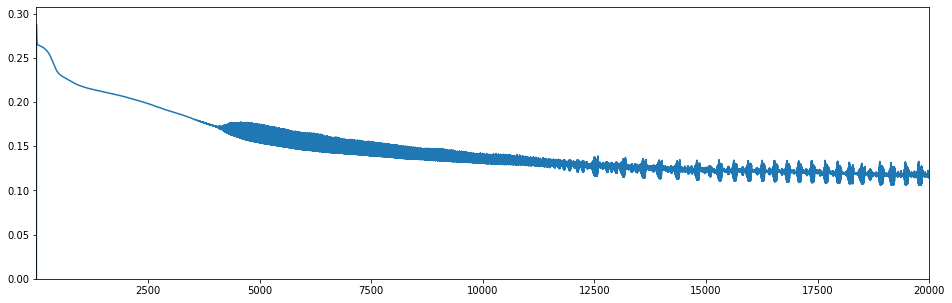

In [650]:
# plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.ylim(0,max(valid_losses)+0.02)
plt.xlim(1,epochs)
plt.plot(valid_losses)
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

# sanity
print(y_pred.shape)
print(y_pred[:1])
print(batch_y.shape)
print(batch_y[:1])

In [653]:
#load the best model
mlp.load_state_dict(torch.load('mlp.model'))

x_test = torch.tensor(X_test,dtype=torch.float,device=device)

#predict
y_pred = mlp(x_test)
y_pred = y_pred.data.cpu().numpy()

x_test.shape[0]

288

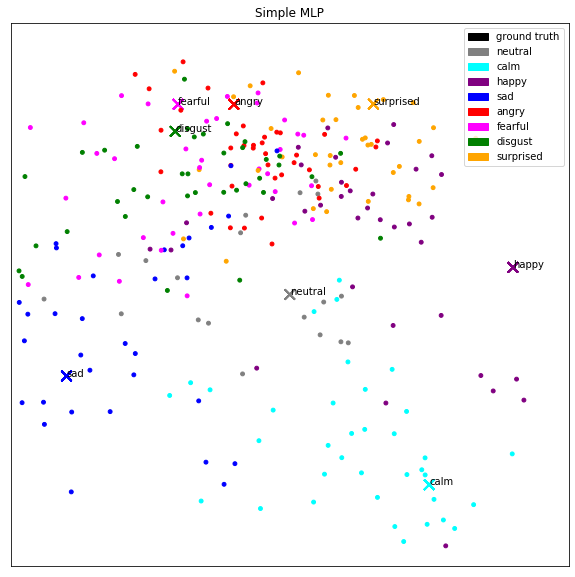

     True x  True y    Pred x    Pred y
0      -0.2     0.7 -0.162283  0.244366
1       0.8     0.1  0.839448 -0.388526
2       0.8     0.1  1.083107 -0.318358
3       0.0     0.0  0.183549 -0.174034
4      -0.2     0.7 -0.163827  0.547950
..      ...     ...       ...       ...
283    -0.4     0.7 -0.507533  0.701306
284     0.5    -0.7  0.473430 -0.644842
285     0.3     0.7  0.144329  0.476346
286     0.3     0.7  0.371282  0.448797
287    -0.2     0.7 -0.382102  0.856071

[288 rows x 4 columns]

Mean Absolute Error: 0.2667166023631581
Mean Squared Error: 0.11606698622921922
Root Mean Squared Error: 0.3406860522962735


In [662]:
# plotting
plt.figure(figsize=(10,10))
plt.title('Simple MLP')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color=colors, s=100, marker='x')
plt.scatter(y_pred[:,0], y_pred[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                       'True y':y_test[:,1],
                       'Pred x':y_pred[:,0], 
                       'Pred y':y_pred[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# MLPRegressor and RandomForestRegressor Sklearn

In [1078]:
mlp_params = {
    'batch_size': 'auto',
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 100, 
    'verbose':1,
    'n_iter_no_change':10,
    'early_stopping':True,
    'random_state':420,
}

In [1079]:
mlp = MLPRegressor(**mlp_params)
mlp.out_activation_ = 'logistic'
mlp.fit(X_train_a, y_train_a)

Iteration 1, loss = 0.14668076
Validation score: -0.003615
Iteration 2, loss = 0.12527926
Validation score: 0.089012
Iteration 3, loss = 0.11602449
Validation score: 0.102063
Iteration 4, loss = 0.11102973
Validation score: 0.124175
Iteration 5, loss = 0.10715313
Validation score: 0.147513
Iteration 6, loss = 0.10391503
Validation score: 0.158160
Iteration 7, loss = 0.10125263


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.166625
Iteration 8, loss = 0.09957487
Validation score: 0.191150
Iteration 9, loss = 0.09706519
Validation score: 0.185267
Iteration 10, loss = 0.09516096
Validation score: 0.203484
Iteration 11, loss = 0.09407358
Validation score: 0.197318
Iteration 12, loss = 0.09244008
Validation score: 0.193500
Iteration 13, loss = 0.09075383
Validation score: 0.211358
Iteration 14, loss = 0.08949642
Validation score: 0.232857
Iteration 15, loss = 0.08836755
Validation score: 0.212877
Iteration 16, loss = 0.08728377
Validation score: 0.228624
Iteration 17, loss = 0.08598950
Validation score: 0.235288
Iteration 18, loss = 0.08502698
Validation score: 0.237742
Iteration 19, loss = 0.08383693
Validation score: 0.225476
Iteration 20, loss = 0.08292646
Validation score: 0.247727


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 21, loss = 0.08175851
Validation score: 0.225471
Iteration 22, loss = 0.08143301
Validation score: 0.254147
Iteration 23, loss = 0.08023223
Validation score: 0.248851
Iteration 24, loss = 0.07895173
Validation score: 0.265479
Iteration 25, loss = 0.07839335
Validation score: 0.267087


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 26, loss = 0.07730976
Validation score: 0.259731
Iteration 27, loss = 0.07672817
Validation score: 0.266935
Iteration 28, loss = 0.07577588
Validation score: 0.274087
Iteration 29, loss = 0.07513588
Validation score: 0.282314
Iteration 30, loss = 0.07409112
Validation score: 0.264824
Iteration 31, loss = 0.07380725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.262744
Iteration 32, loss = 0.07298672
Validation score: 0.288190
Iteration 33, loss = 0.07199430
Validation score: 0.294215
Iteration 34, loss = 0.07184224
Validation score: 0.293445
Iteration 35, loss = 0.07135112
Validation score: 0.302991


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 36, loss = 0.07064779
Validation score: 0.281247
Iteration 37, loss = 0.06954653
Validation score: 0.286971
Iteration 38, loss = 0.06847440
Validation score: 0.282231
Iteration 39, loss = 0.06788804
Validation score: 0.304015
Iteration 40, loss = 0.06698671
Validation score: 0.305866
Iteration 41, loss = 0.06660080
Validation score: 0.299684
Iteration 42, loss = 0.06599237


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.290738
Iteration 43, loss = 0.06575204
Validation score: 0.312425
Iteration 44, loss = 0.06473614
Validation score: 0.307761


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 45, loss = 0.06430979
Validation score: 0.307449
Iteration 46, loss = 0.06384054
Validation score: 0.319460
Iteration 47, loss = 0.06282291
Validation score: 0.316307
Iteration 48, loss = 0.06235000
Validation score: 0.317085
Iteration 49, loss = 0.06206241
Validation score: 0.332412
Iteration 50, loss = 0.06114929
Validation score: 0.333973


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 51, loss = 0.06099537
Validation score: 0.338707
Iteration 52, loss = 0.06012585
Validation score: 0.322920
Iteration 53, loss = 0.05989936
Validation score: 0.340596
Iteration 54, loss = 0.05953338
Validation score: 0.341467
Iteration 55, loss = 0.05907412
Validation score: 0.347438
Iteration 56, loss = 0.05858564
Validation score: 0.342724


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 57, loss = 0.05804212
Validation score: 0.339037
Iteration 58, loss = 0.05822598
Validation score: 0.339404
Iteration 59, loss = 0.05718432
Validation score: 0.329521
Iteration 60, loss = 0.05704001
Validation score: 0.345836
Iteration 61, loss = 0.05615865
Validation score: 0.354421
Iteration 62, loss = 0.05567425
Validation score: 0.353899


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 63, loss = 0.05504894
Validation score: 0.352597
Iteration 64, loss = 0.05465402
Validation score: 0.357121
Iteration 65, loss = 0.05434628
Validation score: 0.366190
Iteration 66, loss = 0.05417749
Validation score: 0.363722
Iteration 67, loss = 0.05407190
Validation score: 0.363768
Iteration 68, loss = 0.05351078
Validation score: 0.360406


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 69, loss = 0.05295535
Validation score: 0.369074
Iteration 70, loss = 0.05287263
Validation score: 0.366533
Iteration 71, loss = 0.05221188
Validation score: 0.364080
Iteration 72, loss = 0.05178759
Validation score: 0.369841
Iteration 73, loss = 0.05145563
Validation score: 0.375097
Iteration 74, loss = 0.05159714
Validation score: 0.370378
Iteration 75, loss = 0.05048739


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.377354
Iteration 76, loss = 0.05050213
Validation score: 0.371045
Iteration 77, loss = 0.05018775
Validation score: 0.369733
Iteration 78, loss = 0.04982281
Validation score: 0.376873
Iteration 79, loss = 0.04915458
Validation score: 0.375031
Iteration 80, loss = 0.04884871


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Validation score: 0.376523
Iteration 81, loss = 0.04854354
Validation score: 0.381147
Iteration 82, loss = 0.04881931
Validation score: 0.379483
Iteration 83, loss = 0.04796348
Validation score: 0.364340
Iteration 84, loss = 0.04757353
Validation score: 0.373447


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 85, loss = 0.04743445
Validation score: 0.387408
Iteration 86, loss = 0.04717252
Validation score: 0.382846
Iteration 87, loss = 0.04716509
Validation score: 0.382742
Iteration 88, loss = 0.04681868
Validation score: 0.387852
Iteration 89, loss = 0.04620933
Validation score: 0.382632
Iteration 90, loss = 0.04661650
Validation score: 0.384839


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 91, loss = 0.04609455
Validation score: 0.376031
Iteration 92, loss = 0.04512402
Validation score: 0.388244
Iteration 93, loss = 0.04549132
Validation score: 0.376609
Iteration 94, loss = 0.04472654
Validation score: 0.384946
Iteration 95, loss = 0.04486968
Validation score: 0.369172


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


Iteration 96, loss = 0.04441623
Validation score: 0.384106
Iteration 97, loss = 0.04377640
Validation score: 0.377190
Iteration 98, loss = 0.04350886
Validation score: 0.392256
Iteration 99, loss = 0.04347758
Validation score: 0.393683
Iteration 100, loss = 0.04315334
Validation score: 0.390913


/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(300,), learning_rate='adaptive',
             learning_rate_init=0.001, max_iter=100, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=420, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

In [1080]:
y_predict_mlp = mlp.predict(X_test)

In [1045]:
rfr_params = {
    'verbose': 10,
    'n_estimators': 100,
    'max_depth': None,
    'random_state': 420,
    'min_samples_split': 4,
    'min_samples_leaf': 3,
}

In [1046]:
# init regr
rfr = RandomForestRegressor(**rfr_params)

In [1047]:
# train the model
print("[*] Training the model...")
rfr.fit(X_train_a, y_train_a)

[*] Training the model...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=420,
                      verbose=10, warm_start=False)

In [1048]:
y_predict_rfr = rfr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


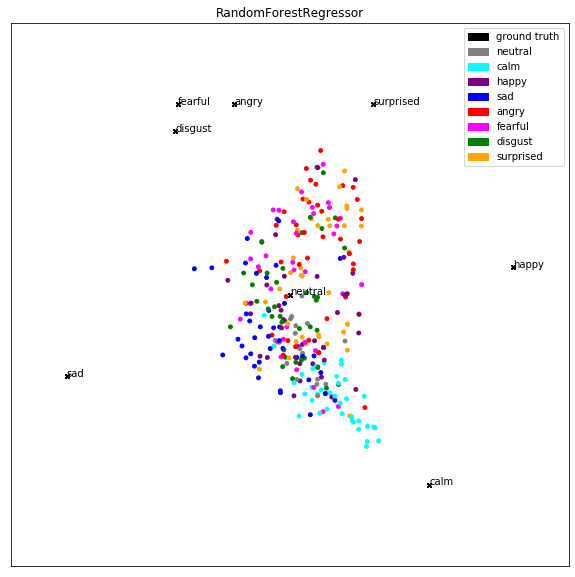

     True x  True y    Pred x    Pred y
0      -0.2     0.7 -0.019893  0.304497
1       0.8     0.1  0.046089 -0.183323
2       0.8     0.1 -0.082013  0.035022
3       0.0     0.0  0.130789 -0.363614
4      -0.2     0.7  0.182037  0.203950
..      ...     ...       ...       ...
283    -0.4     0.7  0.081311  0.320712
284     0.5    -0.7  0.247303 -0.496166
285     0.3     0.7  0.196822  0.454618
286     0.3     0.7  0.207223 -0.109583
287    -0.2     0.7 -0.226757  0.122398

[288 rows x 4 columns]

Mean Absolute Error: 0.43508150231182785
Mean Squared Error: 0.2532238411017731
Root Mean Squared Error: 0.5032135144268018


In [1065]:
# plotting
plt.figure(figsize=(10,10))
plt.title('RandomForestRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_rfr[:,0],y_predict_rfr[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_rfr[:,0], 
                        'Pred y':y_predict_rfr[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_rfr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_rfr)))

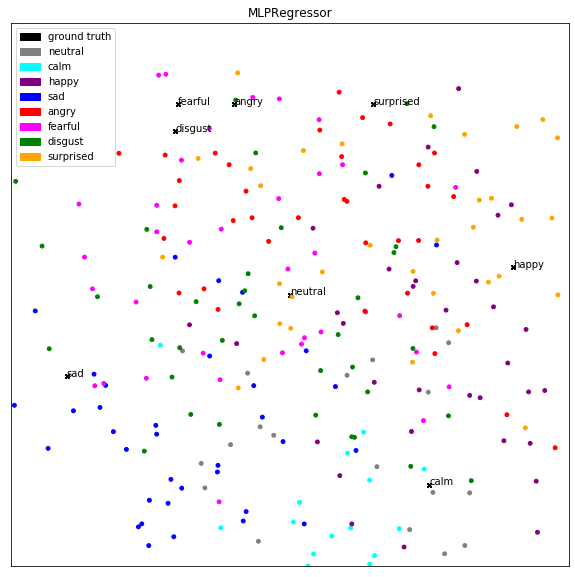

     True x  True y    Pred x    Pred y
0      -0.2     0.7  0.205277  0.342706
1       0.8     0.1  0.883591 -0.686884
2       0.8     0.1  0.730493 -0.045441
3       0.0     0.0  0.644996 -0.729898
4      -0.2     0.7  0.587704  0.360225
..      ...     ...       ...       ...
283    -0.4     0.7 -1.344002  0.967754
284     0.5    -0.7  0.684240 -1.021886
285     0.3     0.7  0.505113  0.657757
286     0.3     0.7  0.961172 -0.001197
287    -0.2     0.7 -0.446297  0.512997

[288 rows x 4 columns]

Mean Absolute Error: 0.4522583608228947
Mean Squared Error: 0.30127970315440855
Root Mean Squared Error: 0.5488895181677352


In [1081]:
# plotting
plt.figure(figsize=(10,10))
plt.title('MLPRegressor')
# im = plt.imread("imshow/circumplex-model.png",0)
# implot = plt.imshow(im,extent=[y_train[:,0].min(),y_train[:,0].max(),y_train[:,1].min(),y_train[:,1].max()])

colors = []

for i in range(len(y_test)):
    for key, value in circumplex_model.items():
        if tuple(y_test[i]) == value[0]:
            colors.append(value[1])

plt.scatter(y_test[:,0], y_test[:,1], color='black', s=15, marker='x')
plt.scatter(y_predict_mlp[:,0],y_predict_mlp[:,1], c=colors, s=15, marker='o')

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.xticks([])
plt.yticks([])

for key, value in circumplex_model.items():
    plt.annotate(key, value[0])

# legend
black_patch = mpatches.Patch(color='black', label='ground truth')
grey_patch = mpatches.Patch(color='grey', label='neutral')
cyan_patch = mpatches.Patch(color='cyan', label='calm')
purple_patch = mpatches.Patch(color='purple', label='happy')
blue_patch = mpatches.Patch(color='blue', label='sad')
red_patch = mpatches.Patch(color='red', label='angry')
magenta_patch = mpatches.Patch(color='magenta', label='fearful')
green_patch = mpatches.Patch(color='green', label='disgust')
orange_patch = mpatches.Patch(color='orange', label='surprised')

plt.legend(handles=[black_patch,
                    grey_patch,
                    cyan_patch,
                    purple_patch,
                    blue_patch,
                    red_patch,
                    magenta_patch,
                    green_patch,
                    orange_patch])

plt.show()

df_rfr = pd.DataFrame({'True x':y_test[:,0], 
                        'True y':y_test[:,1],
                        'Pred x':y_predict_mlp[:,0], 
                        'Pred y':y_predict_mlp[:,1]})
print(df_rfr)
print()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict_mlp))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict_mlp))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict_mlp)))

In [379]:
# save the model
# make result directory if doesn't exist yet
if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(rfr, open("result/rfr.model", "wb"))